# MSIN0114 Dissertation Project 

In [1]:
#Enabling multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import shape
from datetime import datetime, timedelta

#Visualisation packages
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

#Other packages for data preprocessing
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import random
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.model_selection import learning_curve

# Data

### Importing the datasets:

Both internal and external data sources are used for the project. The data provided internally by Data Duopoly is a time series dataset for their new project XPLORFalmouth and ranges from 28th April 2023 to 28th June 2023. It consists of geo-spatial temporal data that tracks users movements overtime in the town. Additionally, there is data on the zones and the zone names (there are 10 zones identified in Falmouth), and data on events happening during that time frame. Furthermore, there is data on shops/activites in different areas in Falmouth. 

To add value to the data provided, external data for weather was merged to build the predictive model and perform analytics. The weather data was sourced from https://www.timeanddate.com/weather/@7291120 for historical weather of Falmouth during the period 28th April 2023 to 28th June 2023.

In [3]:
#Importing the datasets
data = pd.read_csv("data.csv")
events = pd.read_csv("events.csv")
zone_df = pd.read_csv("zones analysis.csv")
weather = pd.read_csv("weather_data.csv")
exhibit = pd.read_csv("exhibit.csv")
exhibit_categories = pd.read_csv("exhibit_category.csv")

**We will have a look at the datasets and their data types and adjust the data types accordingly**

Data

In [4]:
data.head(10)

,Latitude,Longitude,TimeStampUtc,ZoneId,VisitorId,FloorNumber,Id
0,50.150878,-5.088378,28/04/2023 23:55,NaN,1482,0,129016
1,50.150890,-5.088291,28/04/2023 23:54,NaN,1482,0,129015
2,50.150947,-5.088314,28/04/2023 23:53,NaN,1482,0,129014
3,50.150856,-5.088314,28/04/2023 23:53,NaN,1482,0,129013
4,50.150883,-5.088251,28/04/2023 23:53,NaN,1482,0,129012
5,50.150911,-5.088326,28/04/2023 23:52,NaN,1482,0,129011
6,50.150863,-5.088383,28/04/2023 23:52,NaN,1482,0,129010
7,50.150908,-5.088347,28/04/2023 23:51,NaN,1482,0,129009
8,50.150905,-5.088271,28/04/2023 23:51,NaN,1482,0,129008
9,50.150862,-5.088259,28/04/2023 23:51,NaN,1482,0,129007


In [5]:
#Checking the shape of the dataset
num_rows = data.shape[0]
num_cols = data.shape[1]
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 140945
Number of columns: 7


In [6]:
data.dtypes

Latitude        float64
Longitude       float64
TimeStampUtc     object
ZoneId          float64
VisitorId         int64
FloorNumber       int64
Id                int64
dtype: object

In [7]:
#Convert TimeStampUtc from object data type to datetime format
data['TimeStampUtc'] = pd.to_datetime(data['TimeStampUtc'], format='%d/%m/%Y %H:%M')
#Sorting values for consistency
data = data.sort_values('TimeStampUtc')

In [8]:
data.dtypes

Latitude               float64
Longitude              float64
TimeStampUtc    datetime64[ns]
ZoneId                 float64
VisitorId                int64
FloorNumber              int64
Id                       int64
dtype: object

In [9]:
#Converting the longitude and latitude coordinates in "data" to 6 decimal degrees - recommended for precision
data['Longitude'] = data['Longitude'].round(6)
data['Latitude'] = data['Latitude'].round(6)

Events data

In [10]:
events.head(10)

,Id,Title,Body,Images,KeyInfo,StartDateUtc,EndDateUtc,AttractionId,Latitude,Longitude,...,DeletedDateUtc,Icon,RepeatEvery,RepeatUntil,Email,PhoneNumber,WebsiteUrl,IsEventFromGoogle,VenueName,VenueRating
0,1,Geevor Tours,Please visit Geevor website to book and explor...,[],[],2022-06-26 10:00:00.0000000,2022-06-26 16:00:00.0000000,7,50.151785,-5.676026,...,NaN,https://client-uploads-development.s3-eu-west-...,"[1,2,3,4,0]",NaN,enquiries@geevor.com,01736 788662,https://geevor.com/,0,NaN,0.0
1,2,Levant Tours,Book online at the National Trust website,[],[],2021-07-30 11:00:00.0000000,2021-07-30 14:00:00.0000000,7,50.136012,-5.679556,...,NaN,NaN,"[1,2,3,4,0]",2021-10-29 23:00:00.0000000,NaN,NaN,NaN,0,NaN,0.0
2,3,Explore the Botallack Mines and Visitor Centre,Available throughout the day,[],[],2021-07-30 10:00:00.0000000,2021-07-30 14:00:00.0000000,7,50.140296,-5.688836,...,NaN,https://client-uploads-development.s3-eu-west-...,"[5,6,0]",2022-02-27 00:00:00.0000000,NaN,NaN,NaN,0,NaN,0.0
3,4,XplorTINCOAST launch event,Come and join us for the launch of XplorTINCOA...,[],[],2021-08-12 15:00:00.0000000,2021-08-12 17:00:00.0000000,7,50.151455,-5.674685,...,NaN,NaN,[],NaN,NaN,NaN,NaN,0,NaN,0.0
4,5,Cycle Hire Test,Test bike hire,[],[],2021-11-28 10:00:00.0000000,2021-11-28 16:00:00.0000000,7,0.000000,0.000000,...,2021-11-23 14:19:55.6257389,NaN,"[1,3,5,0]",2022-10-31 00:00:00.0000000,NaN,NaN,NaN,0,NaN,0.0
5,6,Levant tours at 11am and 1pm,Book online at the National Trust website,[],[],2022-02-16 10:00:00.0000000,2022-02-16 16:00:00.0000000,7,50.152091,-5.685494,...,NaN,NaN,[3],2022-02-23 00:00:00.0000000,NaN,NaN,NaN,0,NaN,0.0
6,7,Sounds Like...Christmas at Botallack,Join us at Botallack Workshop to enjoy Cornish...,[],[],2021-12-05 11:00:00.0000000,2021-12-05 15:00:00.0000000,7,50.136012,-5.679556,...,NaN,https://client-uploads-development.s3-eu-west-...,[0],2021-12-19 00:00:00.0000000,NaN,NaN,NaN,0,NaN,0.0
7,8,Land's End Cycle Hire......... Bike hire for all,Please contact Peter for enquiries and booking...,[],[],2022-01-11 10:00:00.0000000,2022-01-11 16:00:00.0000000,7,50.129575,-5.493926,...,NaN,https://client-uploads-development.s3-eu-west-...,"[1,2,3,4,5,6,0]",2022-03-30 23:00:00.0000000,NaN,NaN,NaN,0,NaN,0.0
8,9,"Curry night at the Commercial Inn, St Just!",Head to the Commercial Inn for a choice of hom...,[],[],2022-02-23 18:00:00.0000000,2022-02-23 21:00:00.0000000,7,50.124220,-5.679883,...,NaN,NaN,[],2022-02-23 00:00:00.0000000,NaN,NaN,NaN,0,NaN,0.0
9,10,Tours of Levant Mine and Beam Engine,Tours of Levant Mine must be booked in advance...,[],[],2022-06-26 10:30:00.0000000,2022-06-26 16:00:00.0000000,7,50.152404,-5.685307,...,NaN,https://client-uploads-development.s3-eu-west-...,"[1,2,3,4,0]",NaN,levant@nationaltrust.org.uk,01736786156,https://www.nationaltrust.org.uk/levant-mine-a...,0,NaN,0.0


In [11]:
#Checking the shape of the dataset
num_rows = events.shape[0]
num_cols = events.shape[1]
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 938
Number of columns: 22


In [12]:
events.dtypes

Id                     int64
Title                 object
Body                  object
Images                object
KeyInfo               object
StartDateUtc          object
EndDateUtc            object
AttractionId           int64
Latitude             float64
Longitude            float64
CreatedUtc            object
ModifiedUtc           object
DeletedDateUtc        object
Icon                  object
RepeatEvery           object
RepeatUntil           object
Email                 object
PhoneNumber           object
WebsiteUrl            object
IsEventFromGoogle      int64
VenueName             object
VenueRating          float64
dtype: object

In [13]:
#For the necessary columns that we will potentially need, we change their data types to appropriate ones
#Converting "StartDateUtc" and "EndDateUtc" column to datetime type
events['StartDateUtc'] = pd.to_datetime(events['StartDateUtc'])
events['EndDateUtc'] = pd.to_datetime(events['EndDateUtc'])
#Filtering according to date range of project
start_date = pd.to_datetime('2023-04-28')
end_date = pd.to_datetime('2023-06-26')
events = events[(events['StartDateUtc'] >= start_date) & (events['StartDateUtc'] <= end_date)]

In [14]:
#Converting the longitude and latitude coordinates in "events" to 6 decimal degrees - recommended for precision
events['Longitude'] = events['Longitude'].round(6)
events['Latitude'] = events['Latitude'].round(6)

Zone dataset

In [15]:
#The zone data shows the boundry coordinates of the 10 zones Falmouth is divided into
zone_df.head(10)

,Latitude_zone,Longitude_zone,ZoneId,ZoneName
0,50.151925,-5.062811,Zone 1,Maritime and Events square
1,50.151299,-5.064549,Zone 1,Maritime and Events square
2,50.151210,-5.064420,Zone 1,Maritime and Events square
3,50.150461,-5.063444,Zone 1,Maritime and Events square
4,50.149739,-5.062854,Zone 1,Maritime and Events square
5,50.149588,-5.062586,Zone 1,Maritime and Events square
6,50.150186,-5.061545,Zone 1,Maritime and Events square
7,50.150406,-5.060547,Zone 1,Maritime and Events square
8,50.150619,-5.060730,Zone 1,Maritime and Events square
9,50.150495,-5.061331,Zone 1,Maritime and Events square


In [16]:
#Checking the shape of the dataset
num_rows = zone_df.shape[0]
num_cols = zone_df.shape[1]
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 134
Number of columns: 4


In [17]:
zone_df.dtypes

Latitude_zone     float64
Longitude_zone    float64
ZoneId             object
ZoneName           object
dtype: object

In [18]:
#Converting the longitude and latitude coordinates in "zone" to 6 decimal degrees - recommended for precision
zone_df['Longitude_zone'] = zone_df['Longitude_zone'].round(6)
zone_df['Latitude_zone'] = zone_df['Latitude_zone'].round(6)

Weather

In [19]:
weather.head(10)

,Date,Time,Temp,Weather,Wind,Humidity,Barometer,Visibility
0,28/04/2023,00:20,11 °C,Fog.,13 mph,100%,1008 mbar,0 km
1,28/04/2023,01:50,11 °C,Drizzle. Low clouds.,15 mph,94%,1009 mbar,4 km
2,28/04/2023,02:20,10 °C,Low clouds.,15 mph,100%,1009 mbar,4 km
3,28/04/2023,02:50,10 °C,Low clouds.,13 mph,100%,1010 mbar,3 km
4,28/04/2023,03:20,11 °C,Drizzle. Low clouds.,12 mph,94%,1010 mbar,2 km
5,28/04/2023,03:50,11 °C,Low clouds.,9 mph,94%,1010 mbar,3 km
6,28/04/2023,04:20,11 °C,Drizzle. Low clouds.,12 mph,94%,1010 mbar,2 km
7,28/04/2023,04:50,11 °C,Drizzle. Low clouds.,12 mph,94%,1010 mbar,5 km
8,28/04/2023,05:20,11 °C,Low clouds.,12 mph,94%,1011 mbar,NaN
9,28/04/2023,05:50,11 °C,Drizzle. Low clouds.,9 mph,94%,1011 mbar,NaN


In [20]:
#Checking the shape of the dataset
num_rows = weather.shape[0]
num_cols = weather.shape[1]
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 2555
Number of columns: 8


In [21]:
weather.dtypes

Date          object
Time          object
Temp          object
Weather       object
Wind          object
Humidity      object
Barometer     object
Visibility    object
dtype: object

In [22]:
#Convert date column into datetime format and combining to a single column 
weather['Date'] = pd.to_datetime(weather['Date'], format='%d/%m/%Y')
weather['DateTime'] = pd.to_datetime(weather['Date'].dt.strftime('%Y-%m-%d') + ' ' + weather['Time'], format='%Y-%m-%d %H:%M')
weather.drop(['Date', 'Time'], axis=1, inplace=True)

#Sorting datetime column for consistency
weather_sorted = weather.sort_values('DateTime')

In [23]:
#Converting variables to floats and removing units from the column
weather_sorted['Temp'] = weather_sorted['Temp'].str.replace('\xa0°C', '').astype(float)
weather_sorted['Humidity'] = weather_sorted['Humidity'].str.replace('%', '').astype(float)
weather_sorted['Barometer'] = weather_sorted['Barometer'].str.replace('mbar', '').astype(float)
weather_sorted['Visibility'] = weather_sorted['Visibility'].str.replace('\xa0km', '').astype(float)
weather_sorted['Wind'] = weather_sorted['Wind'].replace('No wind', np.nan)
weather_sorted['Wind'] = weather_sorted['Wind'].str.extract('(\d+)', expand=False).astype(float)

In [24]:
weather_sorted

,Temp,Weather,Wind,Humidity,Barometer,Visibility,DateTime
217,11.0,Fog.,14.0,94.0,1023.0,5.0,2023-04-03 00:20:00
218,11.0,Fog.,14.0,94.0,1022.0,6.0,2023-04-03 01:50:00
219,11.0,Fog.,15.0,94.0,1022.0,6.0,2023-04-03 02:20:00
220,11.0,Fog.,15.0,94.0,1021.0,6.0,2023-04-03 03:20:00
221,11.0,Fog.,16.0,94.0,1021.0,7.0,2023-04-03 03:50:00
...,...,...,...,...,...,...,...
2550,16.0,Passing clouds.,8.0,83.0,1018.0,NaN,2023-06-28 21:50:00
2551,16.0,Passing clouds.,6.0,83.0,1018.0,NaN,2023-06-28 22:20:00
2552,16.0,Overcast.,6.0,88.0,1018.0,NaN,2023-06-28 22:50:00
2553,16.0,Overcast.,9.0,83.0,1018.0,NaN,2023-06-28 23:20:00


In [25]:
weather_sorted.dtypes

Temp                 float64
Weather               object
Wind                 float64
Humidity             float64
Barometer            float64
Visibility           float64
DateTime      datetime64[ns]
dtype: object

Exhibit data

In [26]:
exhibit.head(5)

,Id,Title,Body,Images,KeyInfo,StartDateUtc,EndDateUtc,Status,ZoneId,Latitude,...,Minor,CategoryId,SlightlyBusyLimit,VeryBusyLimit,EmailAddress,PhoneNumber,WebsiteUrl,IncludedInPromotion,IsVisibleToMap,SubTitle
0,34,Muddy Beach,Muddy Beach is a family business run by Christ...,[],[],00:00.0,00:00.0,0,NaN,50.167463,...,0,3,0,0,NaN,NaN,NaN,0,1,NaN
1,35,Geevor Tin Mine,Geevor Mine commenced operations in 1906 and w...,[],[],00:00.0,00:00.0,0,16.0,50.151794,...,0,4,10,30,NaN,NaN,NaN,0,1,NaN
2,36,Botallack Mine,The higher of the two engine houses was built ...,[],[],00:00.0,00:00.0,0,17.0,50.141736,...,0,3,10,30,NaN,NaN,NaN,0,1,NaN
3,37,Cape Cornwall,The distinctive headland juts out into the oce...,[],[],00:00.0,00:00.0,0,NaN,50.127189,...,0,3,10,30,NaN,NaN,NaN,0,1,NaN
4,44,West Wheal Owles,The next engine house is the Cargodna (or West...,[],[],00:00.0,00:00.0,0,NaN,50.137367,...,0,3,10,30,NaN,NaN,NaN,0,1,NaN


In [27]:
#Checking the shape of the dataset
num_rows = exhibit.shape[0]
num_cols = exhibit.shape[1]
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 399
Number of columns: 30


In [28]:
exhibit.dtypes

Id                       int64
Title                   object
Body                    object
Images                  object
KeyInfo                 object
StartDateUtc            object
EndDateUtc              object
Status                   int64
ZoneId                 float64
Latitude               float64
Longitude              float64
CreatedUtc              object
ModifiedUtc             object
AttractionId             int64
DeletedDateUtc         float64
Icon                    object
BeaconID                object
BeaconName              object
FloorNumber              int64
Major                    int64
Minor                    int64
CategoryId               int64
SlightlyBusyLimit        int64
VeryBusyLimit            int64
EmailAddress            object
PhoneNumber             object
WebsiteUrl              object
IncludedInPromotion      int64
IsVisibleToMap           int64
SubTitle                object
dtype: object

In [29]:
#Converting the longitude and latitude coordinates in "exhibit" to 6 decimal degrees - recommended for precision
exhibit['Longitude'] = exhibit['Longitude'].round(6)
exhibit['Latitude'] = exhibit['Latitude'].round(6)

In [30]:
exhibit_categories.head(10)

,Description,Id
0,Food and beverage,1
1,Toilets,2
2,Point of interest,3
3,Business,4
4,Bus Stop,6
5,Specialist Retail,7
6,Convenience Retail,8
7,Restaurant / Cafe,9
8,Pub / Nightclub,10
9,Leisure / Activites,11


In [31]:
exhibit_categories.dtypes

Description    object
Id              int64
dtype: object

### Merging the datasets

**First merge the "data" with the "zone_df" data. Doing a left join geospatial merge to the nearest zone for an individual observation.**

We will merge "data" and "zone_df" using geopandas which is a library that handles spatial data. 
We will perform spatial indexing to improve the accuracy of the merge by searching for the closest points in a spatially sorted manner. The longitude and latitude columns from data and zone_df need to be converted into geometry points to create a GeoDataFrame.
Code assistance from: https://geopandas.org/en/stable/docs/user_guide/mergingdata.html

To create the geo dataframes, we used EPSG 4326 CRS (Coordinate Reference System) which is used worlwide for longitude and latitude coordinates. Also known as Global Spherical Mercator https://maps.nls.uk/projects/urbhist/guides_coordinates.html. 

Before we do the merge, we will visualise the area of Falmouth according to the zones segregation to give us an outlook of the zones. The coordinates for Falmouth UK are 50.152573, -5.066270 from: https://www.latlong.net/place/falmouth-cornwall-uk-3593.html

Code assitance to make the polygons and the folium map was from https://gis.stackexchange.com/questions/294206/%D0%A1reating-polygon-from-coordinates-in-geopandas

In [32]:
#Creating polygons to visualise the zones over the map of Falmouth
polygons = []
zone_ids = []
zone_names = []

for zone_id, zone_name in zip(zone_df["ZoneId"].unique(), zone_df["ZoneName"].unique()):
    zone_data = zone_df[zone_df["ZoneId"] == zone_id]
    coordinates = list(zip(zone_data["Longitude_zone"], zone_data["Latitude_zone"]))
    polygon = Polygon(coordinates)
    polygons.append(polygon)
    zone_ids.append(zone_id)
    zone_names.append(zone_name)

#Geodataframe from the polygons
df_for_zones = {"ZoneId": zone_ids, "ZoneName": zone_names, "geometry": polygons}
zones_gdf = gpd.GeoDataFrame(df_for_zones)

#Putting the CRS as EPSG:4326 for degrees
zones_gdf.crs = "EPSG:4326"

#Using a Folium map centered around Falmouth coordinates
falmouth_map = folium.Map(location=[50.152573, -5.066270], zoom_start=14)
geojson = zones_gdf.to_json()

folium.GeoJson(geojson).add_to(falmouth_map)

#Zone labels on map
for x, y, zone_id in zip(zones_gdf.geometry.centroid.x, zones_gdf.geometry.centroid.y, zones_gdf["ZoneId"]):
    folium.Marker(location=[y, x], icon=folium.DivIcon(html=f"<div style='font-weight: bold;'>{zone_id}</div>"), icon_size=(12,12)).add_to(falmouth_map)

falmouth_map

In [33]:
#Save image as html
falmouth_map.save("falmouth_map.html")

In [34]:
#Making sure CRS is EPSG 4326
zones_gdf = zones_gdf.to_crs("EPSG:4326")

In [35]:
print(zones_gdf.crs)

EPSG:4326


In [36]:
zones_gdf

,ZoneId,ZoneName,geometry
0,Zone 1,Maritime and Events square,"POLYGON ((-5.06281 50.15192, -5.06455 50.15130..."
1,Zone 2,The Moor,"POLYGON ((-5.06969 50.15445, -5.06962 50.15419..."
2,Zone 3,Market St,"POLYGON ((-5.06969 50.15445, -5.06962 50.15419..."
3,Zone 4,Church St,"POLYGON ((-5.07020 50.15620, -5.07091 50.15599..."
4,Zone 5,Arwenack St,"POLYGON ((-5.06692 50.15358, -5.06855 50.15284..."
5,Zone 6,Old High St and Greenbank,"POLYGON ((-5.07561 50.16156, -5.07681 50.16115..."
6,Zone 7,Falmouth Marina,"POLYGON ((-5.06419 50.15269, -5.06219 50.15158..."
7,Zone 8,Pendennis,"POLYGON ((-5.04933 50.15335, -5.05087 50.15054..."
8,Zone 9,Gylly Beach,"POLYGON ((-5.05840 50.14670, -5.06029 50.14980..."
9,Zone 10,Woodlane Campus,"POLYGON ((-5.07437 50.14643, -5.06139 50.14944..."


**Merging process**

In [37]:
#Making the "data" dataset a geospatial dataset and setting the CRS as EPSG:4326
geometry_data = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
data_gdf = gpd.GeoDataFrame(data, geometry=geometry_data)

In [38]:
data_gdf.crs = "EPSG:4326"

In [39]:
#Doing the nearest spatial join 
data_with_zones = gpd.sjoin_nearest(data_gdf, zones_gdf, how="left")

#Dropping duplicate observations
subset_columns = [col for col in data_gdf.columns if col != 'ZoneId']
data_with_zones = data_with_zones.drop_duplicates(subset=subset_columns)

In [40]:
data_with_zones

,Latitude,Longitude,TimeStampUtc,ZoneId_left,VisitorId,FloorNumber,Id,geometry,index_right,ZoneId_right,ZoneName
14157,50.155962,-5.087141,2023-04-28 00:25:00,NaN,1447,0,114859,POINT (-5.08714 50.15596),9,Zone 10,Woodlane Campus
14156,50.155962,-5.087141,2023-04-28 00:26:00,NaN,1447,0,114860,POINT (-5.08714 50.15596),9,Zone 10,Woodlane Campus
14155,50.155962,-5.087141,2023-04-28 00:28:00,NaN,1447,0,114861,POINT (-5.08714 50.15596),9,Zone 10,Woodlane Campus
14154,50.155962,-5.087141,2023-04-28 00:29:00,NaN,1447,0,114862,POINT (-5.08714 50.15596),9,Zone 10,Woodlane Campus
14153,50.155962,-5.087141,2023-04-28 00:33:00,NaN,1447,0,114863,POINT (-5.08714 50.15596),9,Zone 10,Woodlane Campus
...,...,...,...,...,...,...,...,...,...,...,...
140442,50.182953,-5.077417,2023-06-28 21:32:00,NaN,2228,0,262097,POINT (-5.07742 50.18295),5,Zone 6,Old High St and Greenbank
140440,50.183011,-5.077349,2023-06-28 21:32:00,NaN,2228,0,262099,POINT (-5.07735 50.18301),5,Zone 6,Old High St and Greenbank
140444,50.183041,-5.077570,2023-06-28 21:32:00,NaN,2228,0,262095,POINT (-5.07757 50.18304),5,Zone 6,Old High St and Greenbank
140443,50.183000,-5.077480,2023-06-28 21:32:00,NaN,2228,0,262096,POINT (-5.07748 50.18300),5,Zone 6,Old High St and Greenbank


### Creating the footfall variable for the model

Footfall is the number of people entering or leaving an area at a given time. Since we have the zones dataset merged to the main dataset we will base our model according to footfall in the 10 zones after every hour.
Therefore, given the nature of the dataset we will create two seperate copies of the dataset. 
One will be to build the predictive model based on footfall in zones after every hour and the other will be the original dataset that we will use for exploratory analysis.
Note we will also use the model dataset we will create for exploratory analysis

In [41]:
#Copy for model
model_df = data_with_zones.copy()

#Copy for exploratory analysis
analysis_df = data_with_zones.copy()

Use the "model_df" to create the footfall variable for number of unique visitors count in each zone after every hour

In [42]:
#Making the TimeStampUtc variable to be after every hour
model_df['Interval'] = model_df['TimeStampUtc'].dt.floor('1h')

In [43]:
#Grouping it by hour, zones, and each unique visitor
footfall_data = model_df.groupby(['Interval', 'ZoneId_right', 'ZoneName'])['VisitorId'].nunique().reset_index()

footfall_data.rename(columns={'VisitorId': 'Footfall'}, inplace=True)

In [44]:
footfall_data

,Interval,ZoneId_right,ZoneName,Footfall
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2
...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1


### Merging process for both datasets for the model and for exploratory analysis

**Merge "footfall_data" with the "weather" data.**

Performed an "asof" merge to match closest key values for the "Interval" (model_df) and "DateTime" (weather_sorted) columns.

Code assistance for the asof merge was from https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html#:~:text=Perform%20a%20merge%20by%20key,be%20sorted%20by%20the%20key.

In [45]:
#Using asof to match the nearest datetime from the weather dataset onto each row in the model_df dataset
footfall_data_2 = pd.merge_asof(footfall_data, weather_sorted, left_on='Interval', right_on='DateTime')

In [46]:
#Dropping the DateTime column
footfall_data_2 = footfall_data_2.drop(['DateTime'], axis=1)

In [47]:
footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Passing clouds.,24.0,82.0,1015.0,8.0
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog.,14.0,94.0,1011.0,NaN
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog.,14.0,94.0,1011.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,More clouds than sun.,12.0,94.0,1018.0,6.0
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Drizzle. More clouds than sun.,13.0,94.0,1018.0,6.0
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Drizzle. More clouds than sun.,12.0,100.0,1018.0,2.0
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Partly sunny.,14.0,88.0,1017.0,NaN


### Including bank holidays in dataset

Given the dataset, there are the following bank holidays:
- Monday, May 1 - Early May bank holiday
- Monday, May 8 - King’s Coronation bank holiday
- Monday, May 29 - Spring bank holiday

In [48]:
#Specifying the bank holidays as a list of days
bank_holidays = [
    pd.Timestamp(2023, 5, 1),  # Early May bank holiday
    pd.Timestamp(2023, 5, 8),  # King’s Coronation bank holiday
    pd.Timestamp(2023, 5, 29)  # Spring bank holiday
]

#Extracting the date part and checking if it is in the list of bank holidays
footfall_data_2['IsBankHoliday'] = footfall_data_2['Interval'].dt.floor('D').isin(bank_holidays)

footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Passing clouds.,24.0,82.0,1015.0,8.0,False
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog.,14.0,94.0,1011.0,NaN,False
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog.,14.0,94.0,1011.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,More clouds than sun.,12.0,94.0,1018.0,6.0,False
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Drizzle. More clouds than sun.,13.0,94.0,1018.0,6.0,False
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Drizzle. More clouds than sun.,12.0,100.0,1018.0,2.0,False
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Partly sunny.,14.0,88.0,1017.0,NaN,False


### Variable indicating if schools are closed or open

We note that schools are closed during the duration of the project and data only during their half term dating 29 May 2023 - 2 June 2023. Additionally, given the public holidays were also school holidays there 1 May 2023, 8 May 2023, and 29 May 2023. Therefore, these are the only dates the schools in Falmouth had holidays. 

For footfall dataset

In [49]:
#Specifying the school and bank holidays as a list of days
school_holidays = [
    pd.Timestamp(2023, 5, 1),  # Early May bank holiday
    pd.Timestamp(2023, 5, 8),  # King’s Coronation bank holiday
    pd.Timestamp(2023, 5, 29), # Spring bank holiday and start of half term holiday
    pd.Timestamp(2023, 5, 30), # School holiday
    pd.Timestamp(2023, 5, 31), # School holiday
    pd.Timestamp(2023, 6, 1),  # School holiday
    pd.Timestamp(2023, 6, 2)   # School holiday
]

#Extracting the date part and checking if it is in the list of bank holidays
footfall_data_2['IsSchoolHoliday'] = footfall_data_2['Interval'].dt.floor('D').isin(school_holidays)

footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Passing clouds.,24.0,82.0,1015.0,8.0,False,False
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,More clouds than sun.,12.0,94.0,1018.0,6.0,False,False
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Drizzle. More clouds than sun.,13.0,94.0,1018.0,6.0,False,False
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Drizzle. More clouds than sun.,12.0,100.0,1018.0,2.0,False,False
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Partly sunny.,14.0,88.0,1017.0,NaN,False,False


### Merge "analysis_df" with "exhibit" - mapped exhibit_data with exhibit_categories under the column CategoryId

Doing this merge for analysis and visualisation purposes

Match the exhibit categories with the exhibit data

In [50]:
#Eliminating categories
categorical_column = 'Description'
categories_to_eliminate = ['Bus Stop', 'Car park', 'Toilets', 'Taxi', 'Train', 'Ferry']

exhibit_filtered = exhibit_categories[~exhibit_categories[categorical_column].isin(categories_to_eliminate)]
exhibit_categories = exhibit_filtered

In [51]:
exhibit_categories

,Description,Id
0,Food and beverage,1
2,Point of interest,3
3,Business,4
5,Specialist Retail,7
6,Convenience Retail,8
7,Restaurant / Cafe,9
8,Pub / Nightclub,10
9,Leisure / Activites,11
10,Culture,12
11,Health and Beauty,13


In [52]:
exhibit_1 = pd.merge(exhibit, exhibit_categories, left_on='CategoryId', right_on='Id', how='left')

In [53]:
exhibit_1

,Id_x,Title,Body,Images,KeyInfo,StartDateUtc,EndDateUtc,Status,ZoneId,Latitude,...,SlightlyBusyLimit,VeryBusyLimit,EmailAddress,PhoneNumber,WebsiteUrl,IncludedInPromotion,IsVisibleToMap,SubTitle,Description,Id_y
0,34,Muddy Beach,Muddy Beach is a family business run by Christ...,[],[],00:00.0,00:00.0,0,NaN,50.167463,...,0,0,NaN,NaN,NaN,0,1,NaN,Point of interest,3.0
1,35,Geevor Tin Mine,Geevor Mine commenced operations in 1906 and w...,[],[],00:00.0,00:00.0,0,16.0,50.151794,...,10,30,NaN,NaN,NaN,0,1,NaN,Business,4.0
2,36,Botallack Mine,The higher of the two engine houses was built ...,[],[],00:00.0,00:00.0,0,17.0,50.141736,...,10,30,NaN,NaN,NaN,0,1,NaN,Point of interest,3.0
3,37,Cape Cornwall,The distinctive headland juts out into the oce...,[],[],00:00.0,00:00.0,0,NaN,50.127189,...,10,30,NaN,NaN,NaN,0,1,NaN,Point of interest,3.0
4,44,West Wheal Owles,The next engine house is the Cargodna (or West...,[],[],00:00.0,00:00.0,0,NaN,50.137367,...,10,30,NaN,NaN,NaN,0,1,NaN,Point of interest,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,490,Harbour 360 view,Click here to view a 360 view of Falmouth Harb...,[],[],00:00.0,00:00.0,0,23.0,50.152559,...,10,20,NaN,NaN,http://360cornwall.uk/360/index.html?s=pano79,0,1,NaN,360 views,22.0
395,491,Falmouth Rugby Club,Please visit the website for the latest fixtur...,[],[],00:00.0,00:00.0,0,19.0,50.151431,...,10,20,info@falmouthrugbyclub.co.uk,+44 1326 311304,https://www.falmouthrugbyclub.co.uk/,0,1,NaN,Leisure / Activites,11.0
396,499,Levant AR Experience,Click the link to see how Levant used to opera...,[],[],00:00.0,00:00.0,0,NaN,50.152349,...,100,200,NaN,NaN,https://www.bit.ly/levantNT,0,1,Explore the mines of Levant with this AR exper...,360 views,22.0
397,503,Levant Winder House AR Tour,Click the link to see how Levant's Winder Hous...,[],[],00:00.0,00:00.0,0,NaN,50.152280,...,100,200,NaN,NaN,https://www.bit.ly/winderNT,0,1,Explore the Winder House at Levant with this A...,360 views,22.0


In [54]:
#Drop columns not needed
exhibit_1 = exhibit_1.drop(["Id_x", "Body", "Images", "KeyInfo", "ZoneId", "StartDateUtc", "EndDateUtc", "Status", "CreatedUtc", "ModifiedUtc", "Icon", "BeaconID", "BeaconName", "FloorNumber", "Major", "Minor", "EmailAddress", "PhoneNumber", "WebsiteUrl", "SubTitle", "Id_y", "IncludedInPromotion", "IsVisibleToMap", "DeletedDateUtc", "CategoryId", "SlightlyBusyLimit", "VeryBusyLimit", "AttractionId"], axis=1)

In [55]:
exhibit_1

,Title,Latitude,Longitude,Description
0,Muddy Beach,50.167463,-5.097468,Point of interest
1,Geevor Tin Mine,50.151794,-5.676175,Business
2,Botallack Mine,50.141736,-5.689132,Point of interest
3,Cape Cornwall,50.127189,-5.707732,Point of interest
4,West Wheal Owles,50.137367,-5.692087,Point of interest
...,...,...,...,...
394,Harbour 360 view,50.152559,-5.064006,360 views
395,Falmouth Rugby Club,50.151431,-5.079563,Leisure / Activites
396,Levant AR Experience,50.152349,-5.684878,360 views
397,Levant Winder House AR Tour,50.152280,-5.684754,360 views


In [56]:
#Converting the longitude and latitude coordinates to geometry points for exhibit_1
exhibit_1_geo = gpd.GeoDataFrame(exhibit_1, geometry=gpd.points_from_xy(exhibit_1['Longitude'], exhibit_1['Latitude']))

In [57]:
#Setting the CRS for exhibit_1_geo to EPSG:4326
exhibit_1_geo.crs = "EPSG:4326" 

In [58]:
exhibit_1_geo

,Title,Latitude,Longitude,Description,geometry
0,Muddy Beach,50.167463,-5.097468,Point of interest,POINT (-5.09747 50.16746)
1,Geevor Tin Mine,50.151794,-5.676175,Business,POINT (-5.67617 50.15179)
2,Botallack Mine,50.141736,-5.689132,Point of interest,POINT (-5.68913 50.14174)
3,Cape Cornwall,50.127189,-5.707732,Point of interest,POINT (-5.70773 50.12719)
4,West Wheal Owles,50.137367,-5.692087,Point of interest,POINT (-5.69209 50.13737)
...,...,...,...,...,...
394,Harbour 360 view,50.152559,-5.064006,360 views,POINT (-5.06401 50.15256)
395,Falmouth Rugby Club,50.151431,-5.079563,Leisure / Activites,POINT (-5.07956 50.15143)
396,Levant AR Experience,50.152349,-5.684878,360 views,POINT (-5.68488 50.15235)
397,Levant Winder House AR Tour,50.152280,-5.684754,360 views,POINT (-5.68475 50.15228)


Merge using nearest neighbour

In [59]:
#Spatial indexes to efficiently match the datapoints
analysis_df.sindex
exhibit_1_geo.sindex

In [60]:
#Before merging we drop "index_right" from analysis_df_2
analysis_df_2 = analysis_df.drop('index_right', axis=1)

In [61]:
#Merging through nearest neighbour spatial join
#The max distance is set to 0.003 degrees i.e., approximately 250 - 350 meters
analysis_df_3 = gpd.sjoin_nearest(analysis_df_2, exhibit_1_geo, how='left', max_distance= 0.003)

In [62]:
analysis_df_3

,Latitude_left,Longitude_left,TimeStampUtc,ZoneId_left,VisitorId,FloorNumber,Id,geometry,ZoneId_right,ZoneName,index_right,Title,Latitude_right,Longitude_right,Description
14157,50.155962,-5.087141,2023-04-28 00:25:00,NaN,1447,0,114859,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14156,50.155962,-5.087141,2023-04-28 00:26:00,NaN,1447,0,114860,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14155,50.155962,-5.087141,2023-04-28 00:28:00,NaN,1447,0,114861,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14154,50.155962,-5.087141,2023-04-28 00:29:00,NaN,1447,0,114862,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14153,50.155962,-5.087141,2023-04-28 00:33:00,NaN,1447,0,114863,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140442,50.182953,-5.077417,2023-06-28 21:32:00,NaN,2228,0,262097,POINT (-5.07742 50.18295),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,NaN
140440,50.183011,-5.077349,2023-06-28 21:32:00,NaN,2228,0,262099,POINT (-5.07735 50.18301),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,NaN
140444,50.183041,-5.077570,2023-06-28 21:32:00,NaN,2228,0,262095,POINT (-5.07757 50.18304),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,NaN
140443,50.183000,-5.077480,2023-06-28 21:32:00,NaN,2228,0,262096,POINT (-5.07748 50.18300),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,NaN


In [63]:
analysis_df_3['Title'].value_counts()

Title
A Trifle Bazaar                                    6330
Dracaena Cross Roads Bus Stop                      3665
Koffiji Cafe Falmouth                              3361
Falmouth University - Penryn Campus                3046
Muddy Beach                                        2303
                                                   ... 
Retro Falmouth supporting Cornwall Hospice Care       2
Amanzi Falmouth                                       2
Mangia                                                1
Wearnes                                               1
Solskinn at the Poly                                  1
Name: count, Length: 307, dtype: int64

### Creating a variable indicating if events are happening in a zone or not

In [64]:
events

,Id,Title,Body,Images,KeyInfo,StartDateUtc,EndDateUtc,AttractionId,Latitude,Longitude,...,DeletedDateUtc,Icon,RepeatEvery,RepeatUntil,Email,PhoneNumber,WebsiteUrl,IsEventFromGoogle,VenueName,VenueRating
771,808,Crowns,Cult 10’s band Crowns return to their homeland...,[],[],2023-04-28 19:30:00,2023-04-28 21:30:00,9,50.153515,-5.067720,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://www.eventbrite.co.uk/e/crowns-tickets-...,1,The Cornish Bank,4.7
772,809,The Wrecking Crew w/ Mr Mogal and Enlish plus ...,"A night of Falmouth's finest hip-hop, with liv...",[],[],2023-04-28 20:00:00,2023-04-29 23:00:00,9,50.151025,-5.064467,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://www.skiddle.com/whats-on/Falmouth/5-De...,1,Five Degrees West,4.4
773,810,CALL MY WINE BLUFF,Welcome to the first CALL MY WINE BLUFF at Upp...,[],[],2023-04-28 00:00:00,2023-04-28 19:00:00,9,50.162614,-5.084646,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://allevents.in/falmouth/call-my-wine-blu...,1,UpperDeck Falmouth,4.3
774,811,Shoddy Theatre presents: A Shoddy Detective An...,Shoddy Theatre presents: A Shoddy Detective An...,[],[],2023-04-28 19:30:00,2023-04-28 22:00:00,9,50.153753,-5.068115,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://falmouth.nub.news/whats-on/theatre/sho...,1,The Poly,4.7
775,812,Baby Paint at the Dracaena Centre,For children up to 2 1/2 years. Babies strip d...,[],[],2023-04-28 13:00:00,2023-04-28 13:00:00,9,50.160761,-5.085072,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://www.eventbrite.co.uk/e/baby-paint-at-t...,1,The Dracaena Centre,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,976,simmerdown // C O N T X T (DJ sets),✨ simmerdown & C O N T X T take to the decks t...,[],[],2023-05-26 21:00:00,2023-05-27 00:00:00,9,50.151260,-5.064774,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://www.eventbrite.co.uk/e/simmerdown-c-o-...,1,Five Degrees West,4.4
934,977,Nos Goes Nordic! Ville & Tommie + Davey & Dyer,Nordic-Cornish duo Ville & Tommie team up with...,[],[],2023-05-26 19:00:00,2023-05-26 22:30:00,9,50.153515,-5.067720,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://www.eventbrite.co.uk/e/nos-goes-nordic...,1,The Cornish Bank,4.8
935,978,Mawnan Film Club - Elvis,Tickets are now available for Mawnan Film Club...,[],[],2023-05-26 00:00:00,2023-05-26 18:30:00,9,50.118303,-5.110688,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://www.ticketsource.co.uk/c-fylm/mawnan-f...,1,Mawnan Memorial Hall,4.6
936,979,Land Of The Giants,The Groove Machine that is The Land Of Giants ...,[],[],2023-05-26 19:30:00,2023-05-26 20:30:00,9,50.262447,-5.046508,...,NaN,https://encrypted-tbn0.gstatic.com/images?q=tb...,[],NaN,NaN,NaN,https://www.eventbrite.co.uk/e/land-of-the-gia...,1,Old Bakery Studios,4.7


Before merging we will remove unnecessary columns

In [65]:
events_2 = events.drop(["Id", "Body", "Images", "KeyInfo", "AttractionId", "VenueRating", "CreatedUtc", "ModifiedUtc", "DeletedDateUtc", "Icon", "RepeatEvery", "RepeatUntil", "Email", "PhoneNumber", "WebsiteUrl", "IsEventFromGoogle"], axis=1)

In [66]:
events_2

,Title,StartDateUtc,EndDateUtc,Latitude,Longitude,VenueName
771,Crowns,2023-04-28 19:30:00,2023-04-28 21:30:00,50.153515,-5.067720,The Cornish Bank
772,The Wrecking Crew w/ Mr Mogal and Enlish plus ...,2023-04-28 20:00:00,2023-04-29 23:00:00,50.151025,-5.064467,Five Degrees West
773,CALL MY WINE BLUFF,2023-04-28 00:00:00,2023-04-28 19:00:00,50.162614,-5.084646,UpperDeck Falmouth
774,Shoddy Theatre presents: A Shoddy Detective An...,2023-04-28 19:30:00,2023-04-28 22:00:00,50.153753,-5.068115,The Poly
775,Baby Paint at the Dracaena Centre,2023-04-28 13:00:00,2023-04-28 13:00:00,50.160761,-5.085072,The Dracaena Centre
...,...,...,...,...,...,...
933,simmerdown // C O N T X T (DJ sets),2023-05-26 21:00:00,2023-05-27 00:00:00,50.151260,-5.064774,Five Degrees West
934,Nos Goes Nordic! Ville & Tommie + Davey & Dyer,2023-05-26 19:00:00,2023-05-26 22:30:00,50.153515,-5.067720,The Cornish Bank
935,Mawnan Film Club - Elvis,2023-05-26 00:00:00,2023-05-26 18:30:00,50.118303,-5.110688,Mawnan Memorial Hall
936,Land Of The Giants,2023-05-26 19:30:00,2023-05-26 20:30:00,50.262447,-5.046508,Old Bakery Studios


In [67]:
#Converting the longitude and latitude coordinates to geometry points
events_2_geo = gpd.GeoDataFrame(events_2, geometry=gpd.points_from_xy(events_2['Longitude'], events_2['Latitude']))

In [68]:
#Setting CRS to EPSG:4326
events_2_geo.crs = "EPSG:4326"

In [69]:
#Spatial indexes to efficiently match the datapoints
events_2_geo.sindex

**From the events dataset, we will check the longitude and latitude columns if an event is happening at a specific time in a zone. We then create a binary column in footfall_data_2 that will match with the events dataset accordingly based on date, time, and zone.**

In [70]:
#Doing the nearest spatial join 
events_with_zones = gpd.sjoin_nearest(events_2_geo, zones_gdf, how="left")

#Dropping duplicate observations
subset_columns = [col for col in events_2_geo.columns if col != 'ZoneId']
events_with_zones = events_with_zones.drop_duplicates(subset=subset_columns)

In [71]:
events_with_zones

,Title,StartDateUtc,EndDateUtc,Latitude,Longitude,VenueName,geometry,index_right,ZoneId,ZoneName
771,Crowns,2023-04-28 19:30:00,2023-04-28 21:30:00,50.153515,-5.067720,The Cornish Bank,POINT (-5.06772 50.15351),1,Zone 2,The Moor
772,The Wrecking Crew w/ Mr Mogal and Enlish plus ...,2023-04-28 20:00:00,2023-04-29 23:00:00,50.151025,-5.064467,Five Degrees West,POINT (-5.06447 50.15102),9,Zone 10,Woodlane Campus
773,CALL MY WINE BLUFF,2023-04-28 00:00:00,2023-04-28 19:00:00,50.162614,-5.084646,UpperDeck Falmouth,POINT (-5.08465 50.16261),5,Zone 6,Old High St and Greenbank
774,Shoddy Theatre presents: A Shoddy Detective An...,2023-04-28 19:30:00,2023-04-28 22:00:00,50.153753,-5.068115,The Poly,POINT (-5.06811 50.15375),1,Zone 2,The Moor
775,Baby Paint at the Dracaena Centre,2023-04-28 13:00:00,2023-04-28 13:00:00,50.160761,-5.085072,The Dracaena Centre,POINT (-5.08507 50.16076),5,Zone 6,Old High St and Greenbank
...,...,...,...,...,...,...,...,...,...,...
933,simmerdown // C O N T X T (DJ sets),2023-05-26 21:00:00,2023-05-27 00:00:00,50.151260,-5.064774,Five Degrees West,POINT (-5.06477 50.15126),4,Zone 5,Arwenack St
934,Nos Goes Nordic! Ville & Tommie + Davey & Dyer,2023-05-26 19:00:00,2023-05-26 22:30:00,50.153515,-5.067720,The Cornish Bank,POINT (-5.06772 50.15351),1,Zone 2,The Moor
935,Mawnan Film Club - Elvis,2023-05-26 00:00:00,2023-05-26 18:30:00,50.118303,-5.110688,Mawnan Memorial Hall,POINT (-5.11069 50.11830),9,Zone 10,Woodlane Campus
936,Land Of The Giants,2023-05-26 19:30:00,2023-05-26 20:30:00,50.262447,-5.046508,Old Bakery Studios,POINT (-5.04651 50.26245),5,Zone 6,Old High St and Greenbank


**Creating variable for "footfall_data_2" from "events_with_zones" based on time, date, and zone of event.**

In [72]:
#Creating new columns in footfall_data_2 to indicate if an event is happening and the corresponding venue name
footfall_data_2['IsEventInZone'] = False
footfall_data_2['VenueName'] = ""

In [73]:
#Creating a for loop that with go over each event based on the start and end times, zones, and venue name where the event is taking place
for _, event in events_with_zones.iterrows():
    start_date = event['StartDateUtc']
    end_date = event['EndDateUtc']
    zone_id = event['ZoneId']
    zone_name = event['ZoneName']
    venue_name = event['VenueName']
    
    #Puting values for 'IsEvent' and 'VenueName' columns created in footfall_data_2 that match the event time and zone
    footfall_data_2.loc[(footfall_data_2['ZoneId_right'] == zone_id) &
                        (footfall_data_2['ZoneName'] == zone_name) &
                        (footfall_data_2['Interval'] >= start_date) &
                        (footfall_data_2['Interval'] < end_date), 'IsEventInZone'] = True
    
    footfall_data_2.loc[(footfall_data_2['ZoneId_right'] == zone_id) &
                        (footfall_data_2['ZoneName'] == zone_name) &
                        (footfall_data_2['Interval'] >= start_date) &
                        (footfall_data_2['Interval'] < end_date), 'VenueName'] = venue_name

In [74]:
footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,VenueName
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Passing clouds.,24.0,82.0,1015.0,8.0,False,False,True,The Rodney Inn
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False,True,The Rodney Inn
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False,True,UpperDeck Falmouth
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False,True,The Rodney Inn
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False,True,UpperDeck Falmouth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,More clouds than sun.,12.0,94.0,1018.0,6.0,False,False,False,
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Drizzle. More clouds than sun.,13.0,94.0,1018.0,6.0,False,False,False,
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Drizzle. More clouds than sun.,12.0,100.0,1018.0,2.0,False,False,False,
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Partly sunny.,14.0,88.0,1017.0,NaN,False,False,False,


### Identifying the most prevalent activities/shops in each zone to include in footfall dataset

We would want to classify each zone based on the activities/things to do/shops that are most prevalant in those zones and include that in the main footfall dataset as a categorical variable. 

Grouping code assistance : https://realpython.com/pandas-groupby/#:~:text=You%20call%20.groupby()%20and,()%20as%20the%20first%20argument.

In [75]:
#Finding the maximum exhibit categories in each zone to include that in the footfall dataset
grouped_analysis = analysis_df_3.groupby(['ZoneId_right', 'Description']).size().reset_index(name='count')

idx = grouped_analysis.groupby('ZoneId_right')['count'].idxmax()

most_prevalent = grouped_analysis.loc[idx, ['ZoneId_right', 'Description']]

most_prevalent

,ZoneId_right,Description
3,Zone 1,Restaurant / Cafe
9,Zone 10,Leisure / Activites
20,Zone 2,Specialist Retail
27,Zone 4,Specialist Retail
34,Zone 5,Restaurant / Cafe
36,Zone 6,Business Services
49,Zone 7,Culture
55,Zone 8,Restaurant / Cafe
58,Zone 9,Leisure / Activites


In [76]:
#Creating column in footfall_data_2 that matches most prominent activity in each zone
#Mapiing zone id to description 
mapping = dict(zip(most_prevalent['ZoneId_right'], most_prevalent['Description']))
footfall_data_2['ProminentActivityInZone'] = footfall_data_2['ZoneId_right'].map(mapping)

In [77]:
footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,VenueName,ProminentActivityInZone
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Passing clouds.,24.0,82.0,1015.0,8.0,False,False,True,The Rodney Inn,Leisure / Activites
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False,True,The Rodney Inn,Leisure / Activites
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False,True,UpperDeck Falmouth,Business Services
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False,True,The Rodney Inn,Leisure / Activites
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False,True,UpperDeck Falmouth,Business Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,More clouds than sun.,12.0,94.0,1018.0,6.0,False,False,False,,Business Services
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Drizzle. More clouds than sun.,13.0,94.0,1018.0,6.0,False,False,False,,Business Services
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Drizzle. More clouds than sun.,12.0,100.0,1018.0,2.0,False,False,False,,Business Services
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Partly sunny.,14.0,88.0,1017.0,NaN,False,False,False,,Business Services


## Feature engineering for datetime variable

Feature engineering for datetime (Interval) variable in the footfall dataset

In [78]:
#Extracting the datetime components from Interval
footfall_data_2['Month'] = footfall_data_2['Interval'].dt.strftime('%B')
footfall_data_2['Hour'] = footfall_data_2['Interval'].dt.hour

In [79]:
footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,VenueName,ProminentActivityInZone,Month,Hour
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Passing clouds.,24.0,82.0,1015.0,8.0,False,False,True,The Rodney Inn,Leisure / Activites,April,0
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False,True,The Rodney Inn,Leisure / Activites,April,6
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False,True,UpperDeck Falmouth,Business Services,April,6
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False,True,The Rodney Inn,Leisure / Activites,April,7
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False,True,UpperDeck Falmouth,Business Services,April,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,More clouds than sun.,12.0,94.0,1018.0,6.0,False,False,False,,Business Services,June,15
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Drizzle. More clouds than sun.,13.0,94.0,1018.0,6.0,False,False,False,,Business Services,June,16
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Drizzle. More clouds than sun.,12.0,100.0,1018.0,2.0,False,False,False,,Business Services,June,17
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Partly sunny.,14.0,88.0,1017.0,NaN,False,False,False,,Business Services,June,19


## Final Data Cleaning

Giving a final clean to both the datasets i.e., "footfall_data_2" and "analysis_df_3".

### Cleaning analysis_df_3

In [80]:
analysis_df_3

,Latitude_left,Longitude_left,TimeStampUtc,ZoneId_left,VisitorId,FloorNumber,Id,geometry,ZoneId_right,ZoneName,index_right,Title,Latitude_right,Longitude_right,Description
14157,50.155962,-5.087141,2023-04-28 00:25:00,NaN,1447,0,114859,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14156,50.155962,-5.087141,2023-04-28 00:26:00,NaN,1447,0,114860,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14155,50.155962,-5.087141,2023-04-28 00:28:00,NaN,1447,0,114861,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14154,50.155962,-5.087141,2023-04-28 00:29:00,NaN,1447,0,114862,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14153,50.155962,-5.087141,2023-04-28 00:33:00,NaN,1447,0,114863,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,253.0,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140442,50.182953,-5.077417,2023-06-28 21:32:00,NaN,2228,0,262097,POINT (-5.07742 50.18295),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,NaN
140440,50.183011,-5.077349,2023-06-28 21:32:00,NaN,2228,0,262099,POINT (-5.07735 50.18301),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,NaN
140444,50.183041,-5.077570,2023-06-28 21:32:00,NaN,2228,0,262095,POINT (-5.07757 50.18304),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,NaN
140443,50.183000,-5.077480,2023-06-28 21:32:00,NaN,2228,0,262096,POINT (-5.07748 50.18300),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,NaN


Dropping columns not needed

In [81]:
analysis_df_3 = analysis_df_3.drop(columns=['ZoneId_left', 'FloorNumber', 'Id', 'index_right'])

In [82]:
analysis_df_3

,Latitude_left,Longitude_left,TimeStampUtc,VisitorId,geometry,ZoneId_right,ZoneName,Title,Latitude_right,Longitude_right,Description
14157,50.155962,-5.087141,2023-04-28 00:25:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14156,50.155962,-5.087141,2023-04-28 00:26:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14155,50.155962,-5.087141,2023-04-28 00:28:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14154,50.155962,-5.087141,2023-04-28 00:29:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14153,50.155962,-5.087141,2023-04-28 00:33:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
...,...,...,...,...,...,...,...,...,...,...,...
140442,50.182953,-5.077417,2023-06-28 21:32:00,2228,POINT (-5.07742 50.18295),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140440,50.183011,-5.077349,2023-06-28 21:32:00,2228,POINT (-5.07735 50.18301),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140444,50.183041,-5.077570,2023-06-28 21:32:00,2228,POINT (-5.07757 50.18304),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140443,50.183000,-5.077480,2023-06-28 21:32:00,2228,POINT (-5.07748 50.18300),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN


Checking for null values

In [83]:
null_values = analysis_df_3.isnull().sum()
null_values

Latitude_left          0
Longitude_left         0
TimeStampUtc           0
VisitorId              0
geometry               0
ZoneId_right           0
ZoneName               0
Title              77245
Latitude_right     77245
Longitude_right    77245
Description        91028
dtype: int64

We will keep the null values as this dataset is used for exploratory purposes only. 

Check for duplicated rows

In [84]:
analysis_duplicate_rows = analysis_df_3.duplicated()
analysis_df_3[analysis_duplicate_rows]

,Latitude_left,Longitude_left,TimeStampUtc,VisitorId,geometry,ZoneId_right,ZoneName,Title,Latitude_right,Longitude_right,Description
14135,50.164528,-5.069146,2023-04-28 07:32:00,1446,POINT (-5.06915 50.16453),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
14138,50.164575,-5.069169,2023-04-28 07:32:00,1446,POINT (-5.06917 50.16457),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
14139,50.164575,-5.069169,2023-04-28 07:32:00,1446,POINT (-5.06917 50.16457),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
14140,50.164575,-5.069169,2023-04-28 07:32:00,1446,POINT (-5.06917 50.16457),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
14136,50.164528,-5.069146,2023-04-28 07:32:00,1446,POINT (-5.06915 50.16453),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
140533,50.169002,-5.106991,2023-06-28 14:30:00,2224,POINT (-5.10699 50.16900),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140532,50.169002,-5.106991,2023-06-28 14:30:00,2224,POINT (-5.10699 50.16900),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140531,50.169002,-5.106991,2023-06-28 14:30:00,2224,POINT (-5.10699 50.16900),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140461,50.169601,-5.107228,2023-06-28 16:43:00,1796,POINT (-5.10723 50.16960),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN


In [85]:
#Drop duplicates
analysis_df_3.drop_duplicates(inplace=True)

In [86]:
analysis_df_3

,Latitude_left,Longitude_left,TimeStampUtc,VisitorId,geometry,ZoneId_right,ZoneName,Title,Latitude_right,Longitude_right,Description
14157,50.155962,-5.087141,2023-04-28 00:25:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14156,50.155962,-5.087141,2023-04-28 00:26:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14155,50.155962,-5.087141,2023-04-28 00:28:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14154,50.155962,-5.087141,2023-04-28 00:29:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14153,50.155962,-5.087141,2023-04-28 00:33:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
...,...,...,...,...,...,...,...,...,...,...,...
140442,50.182953,-5.077417,2023-06-28 21:32:00,2228,POINT (-5.07742 50.18295),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140440,50.183011,-5.077349,2023-06-28 21:32:00,2228,POINT (-5.07735 50.18301),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140444,50.183041,-5.077570,2023-06-28 21:32:00,2228,POINT (-5.07757 50.18304),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140443,50.183000,-5.077480,2023-06-28 21:32:00,2228,POINT (-5.07748 50.18300),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN


Checking data types

In [87]:
analysis_df_3.dtypes

Latitude_left             float64
Longitude_left            float64
TimeStampUtc       datetime64[ns]
VisitorId                   int64
geometry                 geometry
ZoneId_right               object
ZoneName                   object
Title                      object
Latitude_right            float64
Longitude_right           float64
Description                object
dtype: object

Rename columns

In [88]:
# Rename a single column
analysis_df_3.rename(columns={'ZoneId_right': 'ZoneId'}, inplace=True)

### Cleaning footfall_data_2

In [89]:
footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,VenueName,ProminentActivityInZone,Month,Hour
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Passing clouds.,24.0,82.0,1015.0,8.0,False,False,True,The Rodney Inn,Leisure / Activites,April,0
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False,True,The Rodney Inn,Leisure / Activites,April,6
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Drizzle. Low clouds.,9.0,94.0,1011.0,NaN,False,False,True,UpperDeck Falmouth,Business Services,April,6
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False,True,The Rodney Inn,Leisure / Activites,April,7
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog.,14.0,94.0,1011.0,NaN,False,False,True,UpperDeck Falmouth,Business Services,April,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,More clouds than sun.,12.0,94.0,1018.0,6.0,False,False,False,,Business Services,June,15
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Drizzle. More clouds than sun.,13.0,94.0,1018.0,6.0,False,False,False,,Business Services,June,16
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Drizzle. More clouds than sun.,12.0,100.0,1018.0,2.0,False,False,False,,Business Services,June,17
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Partly sunny.,14.0,88.0,1017.0,NaN,False,False,False,,Business Services,June,19


In [90]:
footfall_data_2.dtypes

Interval                   datetime64[ns]
ZoneId_right                       object
ZoneName                           object
Footfall                            int64
Temp                              float64
Weather                            object
Wind                              float64
Humidity                          float64
Barometer                         float64
Visibility                        float64
IsBankHoliday                        bool
IsSchoolHoliday                      bool
IsEventInZone                        bool
VenueName                          object
ProminentActivityInZone            object
Month                              object
Hour                                int32
dtype: object

Check for null values

In [91]:
null_values = footfall_data_2.isnull().sum()
null_values

Interval                      0
ZoneId_right                  0
ZoneName                      0
Footfall                      0
Temp                          0
Weather                       0
Wind                          2
Humidity                      1
Barometer                     5
Visibility                 1319
IsBankHoliday                 0
IsSchoolHoliday               0
IsEventInZone                 0
VenueName                    74
ProminentActivityInZone       0
Month                         0
Hour                          0
dtype: int64

<AxesSubplot:xlabel='Visibility'>

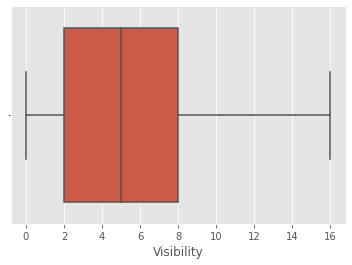

In [92]:
sns.boxplot(x=footfall_data_2['Visibility'])
plt.show()

In [93]:
#Handling the missing values by putting the mean/average of the columns into the NA 
#Calculate the mean 
visibility_mean = footfall_data_2['Visibility'].mean()
wind_mean = footfall_data_2['Wind'].mean()
humidity_mean = footfall_data_2['Humidity'].mean()
barometer_mean = footfall_data_2['Barometer'].mean()
#Replace missing values with the mean
footfall_data_2['Visibility'].fillna(visibility_mean, inplace=True)
footfall_data_2['Wind'].fillna(wind_mean, inplace=True)
footfall_data_2['Humidity'].fillna(humidity_mean, inplace=True)
footfall_data_2['Barometer'].fillna(barometer_mean, inplace=True)

In [94]:
null_values = footfall_data_2.isnull().sum()
null_values

Interval                    0
ZoneId_right                0
ZoneName                    0
Footfall                    0
Temp                        0
Weather                     0
Wind                        0
Humidity                    0
Barometer                   0
Visibility                  0
IsBankHoliday               0
IsSchoolHoliday             0
IsEventInZone               0
VenueName                  74
ProminentActivityInZone     0
Month                       0
Hour                        0
dtype: int64

Check for duplicated rows

In [95]:
footfall_duplicate_rows = footfall_data_2.duplicated()
footfall_data_2[footfall_duplicate_rows]

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,VenueName,ProminentActivityInZone,Month,Hour


No duplicated rows

Classifying the weather column to fewer similar categories

In [96]:
#Checking unique categories in the weather column 
categories = footfall_data_2['Weather'].unique()

for category in categories:
    print(category)

Passing clouds.
Drizzle. Low clouds.
Fog.
Drizzle. Cloudy.
Cloudy.
Mostly cloudy.
Broken clouds.
Partly sunny.
Light rain. Broken clouds.
More clouds than sun.
Low clouds.
Light rain. Low clouds.
Overcast.
Partly cloudy.
Sunny.
Cool.
Scattered clouds.
Light rain. Partly sunny.
Drizzle. More clouds than sun.
Rain. Mostly cloudy.
Light rain. Mostly cloudy.
Light rain. Passing clouds.
Rain. Low clouds.
Heavy rain. Low clouds.
Heavy rain. Partly sunny.
Drizzle. Partly sunny.
Rain. More clouds than sun.
Sprinkles. Broken clouds.
Heavy rain. Cloudy.
Lots of rain. Broken clouds.
Scattered showers. Scattered clouds.
Clear.
Scattered showers. Broken clouds.
Sprinkles. Partly sunny.
Scattered showers. Partly sunny.
Rain. Overcast.
Sprinkles. Scattered clouds.
Mild.
Quite cool.
Refreshingly cool.
Haze.
Light rain. Overcast.
Sprinkles. Overcast.


In [97]:
#Mapping new categories to original categories
category_mapping = {
    'Sunny': ['Sunny.'],
    'Cloudy': ['Cloudy.', 'More clouds than sun.', 'Mostly cloudy.', 'Overcast.'],
    'Heavy rain': [
        'Heavy rain. Broken clouds.', 'Heavy rain. Cloudy.', 'Heavy rain. Low clouds.',
        'Heavy rain. Partly sunny.', 'Lots of rain. Broken clouds.',
        'Lots of rain. More clouds than sun.', 'Rain. Broken clouds.',
        'Rain. Low clouds.', 'Rain. More clouds than sun.', 'Rain. Mostly cloudy.',
        'Rain. Overcast.'
    ],
    'Light rain': [
        'Light rain. Broken clouds.', 'Light rain. Cloudy.', 'Light rain. Low clouds.',
        'Light rain. More clouds than sun.', 'Light rain. Mostly cloudy.',
        'Light rain. Overcast.', 'Light rain. Partly cloudy.', 'Light rain. Partly sunny.',
        'Light rain. Passing clouds.', 'Drizzle. Cloudy.', 'Drizzle. Low clouds.',
        'Drizzle. More clouds than sun.', 'Drizzle. Mostly cloudy.', 'Drizzle. Overcast.',
        'Drizzle. Partly sunny.', 'Scattered showers. Broken clouds.',
        'Scattered showers. Partly sunny.', 'Scattered showers. Scattered clouds.',
        'Sprinkles. Broken clouds.', 'Sprinkles. Overcast.', 'Sprinkles. Partly sunny.',
        'Sprinkles. Scattered clouds.'
    ],
    'Thunderstorm': ['Strong thunderstorms. Cloudy.'],
    'Fog': ['Fog.', 'Haze.'],
    'Broken clouds': ['Broken clouds.', 'Partly cloudy.', 'Partly sunny.', 'Passing clouds.', 'Scattered clouds.'],
    'Clear': ['Clear.'],
    'Cool': ['Cool.', 'Quite cool.', 'Refreshingly cool.'],
    'Low clouds': ['Low clouds.'],
    'Mild': ['Mild.']
}

In [98]:
footfall_data_2['Weather'] = footfall_data_2['Weather'].apply(lambda x: next((k for k, v in category_mapping.items() if x in v), x))

In [99]:
#Checking unique categories in the weather column 
categories = footfall_data_2['Weather'].unique()

for category in categories:
    print(category)

Broken clouds
Light rain
Fog
Cloudy
Low clouds
Sunny
Cool
Heavy rain
Clear
Mild


In [100]:
footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,VenueName,ProminentActivityInZone,Month,Hour
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Broken clouds,24.0,82.0,1015.0,8.000000,False,False,True,The Rodney Inn,Leisure / Activites,April,0
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Light rain,9.0,94.0,1011.0,6.234657,False,False,True,The Rodney Inn,Leisure / Activites,April,6
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Light rain,9.0,94.0,1011.0,6.234657,False,False,True,UpperDeck Falmouth,Business Services,April,6
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog,14.0,94.0,1011.0,6.234657,False,False,True,The Rodney Inn,Leisure / Activites,April,7
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog,14.0,94.0,1011.0,6.234657,False,False,True,UpperDeck Falmouth,Business Services,April,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,Cloudy,12.0,94.0,1018.0,6.000000,False,False,False,,Business Services,June,15
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Light rain,13.0,94.0,1018.0,6.000000,False,False,False,,Business Services,June,16
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Light rain,12.0,100.0,1018.0,2.000000,False,False,False,,Business Services,June,17
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Broken clouds,14.0,88.0,1017.0,6.234657,False,False,False,,Business Services,June,19


**Creating a column specifying the day of the week**

In [101]:
footfall_data_2['DayOfWeek'] = footfall_data_2['Interval'].dt.day_name()

In [102]:
footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,VenueName,ProminentActivityInZone,Month,Hour,DayOfWeek
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Broken clouds,24.0,82.0,1015.0,8.000000,False,False,True,The Rodney Inn,Leisure / Activites,April,0,Friday
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Light rain,9.0,94.0,1011.0,6.234657,False,False,True,The Rodney Inn,Leisure / Activites,April,6,Friday
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Light rain,9.0,94.0,1011.0,6.234657,False,False,True,UpperDeck Falmouth,Business Services,April,6,Friday
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog,14.0,94.0,1011.0,6.234657,False,False,True,The Rodney Inn,Leisure / Activites,April,7,Friday
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog,14.0,94.0,1011.0,6.234657,False,False,True,UpperDeck Falmouth,Business Services,April,7,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,Cloudy,12.0,94.0,1018.0,6.000000,False,False,False,,Business Services,June,15,Wednesday
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Light rain,13.0,94.0,1018.0,6.000000,False,False,False,,Business Services,June,16,Wednesday
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Light rain,12.0,100.0,1018.0,2.000000,False,False,False,,Business Services,June,17,Wednesday
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Broken clouds,14.0,88.0,1017.0,6.234657,False,False,False,,Business Services,June,19,Wednesday


### Correlation matrix

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation Matrix')

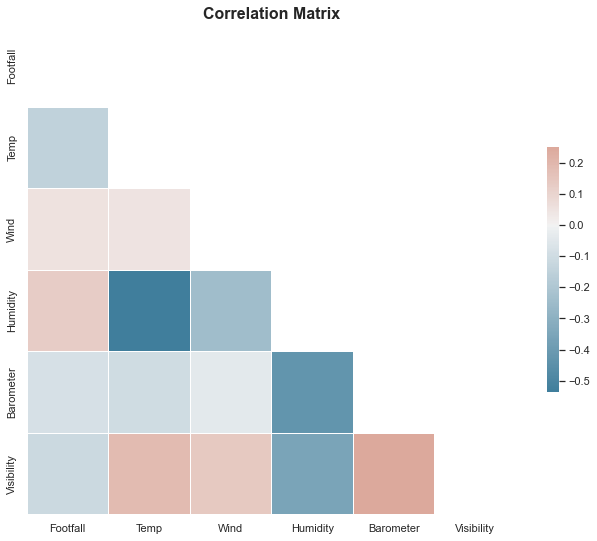

In [103]:
#Numeric columns
numeric_columns = footfall_data_2.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

sns.set(style='white')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

title_font = {'fontsize': 16, 'fontweight': 'bold'}
plt.title('Correlation Matrix', fontdict=title_font)
plt.show()

#### Summary statistics

In [104]:
#Summary statistics
footfall_excluded_interval = footfall_data_2.drop('Interval', axis=1)
footfall_excluded_interval.describe()

,Footfall,Temp,Wind,Humidity,Barometer,Visibility,Hour
count,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000
mean,1.429792,14.585691,10.877071,79.677350,1019.820128,6.234657,12.365190
std,0.840043,3.297767,5.223004,14.073698,5.645206,2.883927,5.456521
min,1.000000,7.000000,1.000000,36.000000,1007.000000,0.000000,0.000000
25%,1.000000,12.000000,7.000000,68.000000,1016.000000,6.234657,8.000000
50%,1.000000,14.000000,10.000000,82.000000,1021.000000,6.234657,12.000000
75%,2.000000,17.000000,14.000000,94.000000,1024.000000,6.234657,17.000000
max,8.000000,24.000000,33.000000,100.000000,1030.000000,16.000000,23.000000


## Data exploratory analysis

Do exploratory analysis for both footfall and analysis datasets

### Footfall dataset analysis

array([[<AxesSubplot:title={'center':'Interval'}>,
        <AxesSubplot:title={'center':'Footfall'}>,
        <AxesSubplot:title={'center':'Temp'}>],
       [<AxesSubplot:title={'center':'Wind'}>,
        <AxesSubplot:title={'center':'Humidity'}>,
        <AxesSubplot:title={'center':'Barometer'}>],
       [<AxesSubplot:title={'center':'Visibility'}>,
        <AxesSubplot:title={'center':'Hour'}>, <AxesSubplot:>]],
      dtype=object)

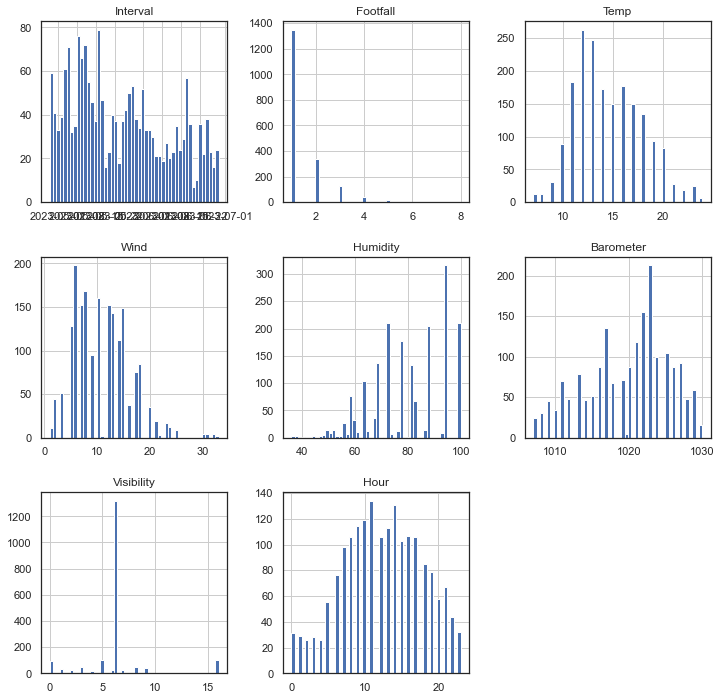

In [105]:
footfall_data_2.hist(bins=50, figsize=(12, 12))
plt.show()

**Heatmap visual of footfall on each week of the dataset on different times of the day**

In [108]:
heatmap_visual = pd.read_csv('heatmap_visual.csv')

In [109]:
heatmap_visual.head(5)

,Time,28/04/2023 - 04/05/2023,05/05/2023 - 11/05/2023,12/05/2023 - 18/05/2023,19/05/2023 - 25/05/2023,26/05/2023 - 01/06/2023,02/06/2023 - 08/06/2023,09/06/2023 - 15/06/2023,16/06/2023 - 22/06/2023,23/06/2023 - 28/06/2023
0,00:00:00,7,7,8,2,3,2,2,2,3.0
1,01:00:00,6,10,5,0,3,2,3,0,1.0
2,02:00:00,5,8,6,0,1,4,0,0,5.0
3,03:00:00,5,9,6,5,0,2,2,0,2.0
4,04:00:00,8,9,5,2,2,2,2,1,0.0


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Footfall each week during different times of the day')

Text(0.5, 48.5, 'Time period')

Text(111.5, 0.5, 'Time of day')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, '28/04/2023 - 04/05/2023'),
  Text(1.5, 0, '05/05/2023 - 11/05/2023'),
  Text(2.5, 0, '12/05/2023 - 18/05/2023'),
  Text(3.5, 0, '19/05/2023 - 25/05/2023'),
  Text(4.5, 0, '26/05/2023 - 01/06/2023'),
  Text(5.5, 0, '02/06/2023 - 08/06/2023'),
  Text(6.5, 0, '09/06/2023 - 15/06/2023'),
  Text(7.5, 0, '16/06/2023 - 22/06/2023'),
  Text(8.5, 0, '23/06/2023 - 28/06/2023')])

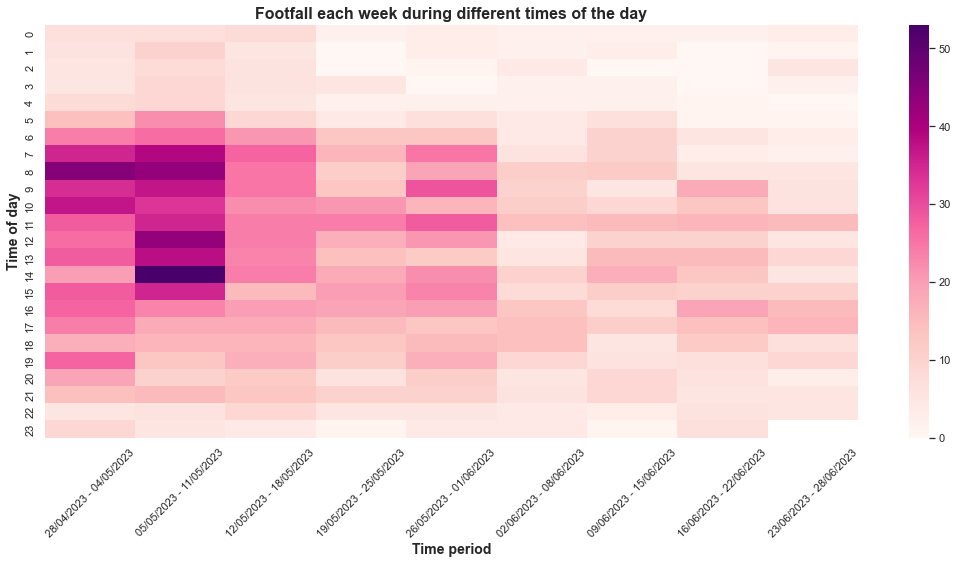

In [110]:
#Remove the time column
heatmap_plot = heatmap_visual.drop(columns='Time')

#Convert to numeric columns 
heatmap_plot = heatmap_plot.apply(pd.to_numeric)

#Heapmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_plot, annot=False, cmap='RdPu', cbar=True)

plt.title('Footfall each week during different times of the day', fontsize=16, fontweight='bold')
plt.xlabel('Time period', fontsize=14, fontweight='bold')
plt.ylabel('Time of day', fontsize=14, fontweight='bold')

plt.xticks(rotation=45)

sns.set(font='Georgia')

plt.tight_layout()

plt.savefig('heatmap_footfall.png') 

plt.show()


In [111]:
footfall_data_2.dtypes

Interval                   datetime64[ns]
ZoneId_right                       object
ZoneName                           object
Footfall                            int64
Temp                              float64
Weather                            object
Wind                              float64
Humidity                          float64
Barometer                         float64
Visibility                        float64
IsBankHoliday                        bool
IsSchoolHoliday                      bool
IsEventInZone                        bool
VenueName                          object
ProminentActivityInZone            object
Month                              object
Hour                                int32
DayOfWeek                          object
TimeIntervals                    category
Date                               object
Time                               object
dtype: object

**Area graph to show total footfall in different zones overtime i.e., 28 April 2023 - 28 June 2023**

Code to make pivot table: https://datatofish.com/pivot-table-python/

<Figure size 864x576 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Footfall')

Text(0.5, 1.0, 'Footfall in Different Zones')

(array([19478., 19485., 19492., 19499., 19509., 19516., 19523., 19530.,
        19539.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

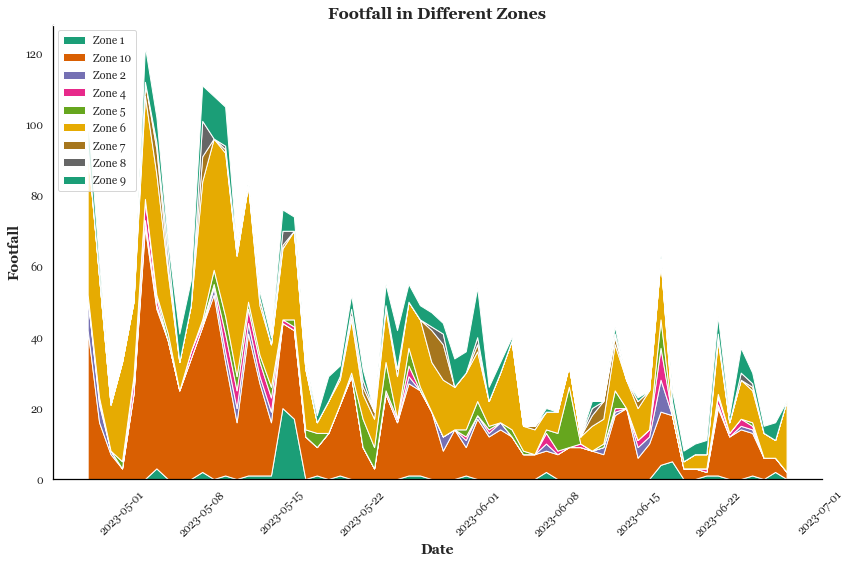

In [112]:
footfall_data_2['Date'] = pd.to_datetime(footfall_data_2['Date'])

# Group by 'ZoneId_right' and 'Date' and calculate the sum of footfall for each group
footfall_grouped = footfall_data_2.groupby(['ZoneId_right', 'Date'])['Footfall'].sum().reset_index()

footfall_pivot = footfall_grouped.pivot(index='Date', columns='ZoneId_right', values='Footfall').fillna(0)

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(12, 8))
palette = sns.color_palette("Dark2", n_colors=10)

#Stacked area chartt
plt.stackplot(footfall_pivot.index, footfall_pivot.values.T, labels=footfall_pivot.columns, colors=palette)

plt.legend(loc='upper left')
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel('Footfall', fontweight='bold', fontsize=14)  
plt.title('Footfall in Different Zones', fontweight='bold', fontsize=16)  

plt.xticks(rotation=45)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()
plt.show()

<Figure size 864x576 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Footfall')

Text(0.5, 1.0, 'Footfall overtime in selected zones')

(array([19478., 19485., 19492., 19499., 19509., 19516., 19523., 19530.,
        19539.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

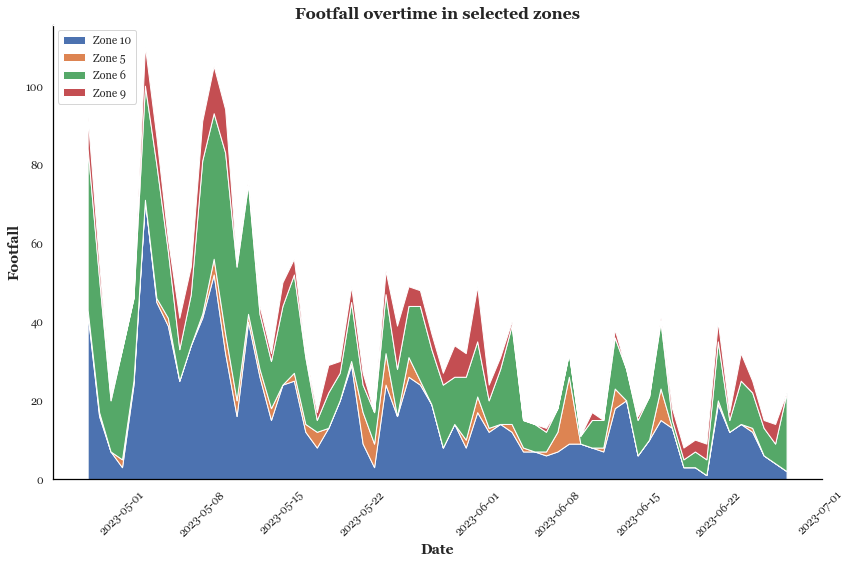

In [113]:
footfall_data_2['Date'] = pd.to_datetime(footfall_data_2['Date'])

#Filter data to include only Zone 10, 6, 9, and 5
selected_zones = ['Zone 10', 'Zone 6', 'Zone 9', 'Zone 5']
footfall_data_filtered = footfall_data_2[footfall_data_2['ZoneId_right'].isin(selected_zones)]

footfall_grouped = footfall_data_filtered.groupby(['ZoneId_right', 'Date'])['Footfall'].sum().reset_index()

footfall_pivot = footfall_grouped.pivot(index='Date', columns='ZoneId_right', values='Footfall').fillna(0)

plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(12, 8))
palette = sns.color_palette("deep", n_colors=4)  

plt.stackplot(footfall_pivot.index, footfall_pivot.values.T, labels=footfall_pivot.columns, colors=palette)

plt.legend(loc='upper left')
plt.xlabel('Date', fontweight='bold', fontsize=14)
plt.ylabel('Footfall', fontweight='bold', fontsize=14)
plt.title('Footfall overtime in selected zones', fontweight='bold', fontsize=16)

plt.xticks(rotation=45)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('stacked_area_chart_top_zones.png')

plt.show()


**Aggregate footfall in each zone from 28 April 2023 - 28 June 2023 with most prominent activity in each zone**

<Figure size 864x432 with 0 Axes>

<AxesSubplot:ylabel='ZoneId_right'>

Text(0.5, 0, 'Footfall')

Text(0, 0.5, 'Zone')

Text(0.5, 1.0, 'Total footfall in each zone from 28 April 2023 - 28 June 2023 with most prominent activity in each zone')

Text(42, 0, 'Restaurant / Cafe')

Text(67, 1, 'Restaurant / Cafe')

Text(69, 2, 'Specialist Retail')

Text(70, 3, 'Culture')

Text(74, 4, 'Specialist Retail')

Text(115, 5, 'Restaurant / Cafe')

Text(230, 6, 'Leisure / Activites')

Text(928, 7, 'Business Services')

Text(1083, 8, 'Leisure / Activites')

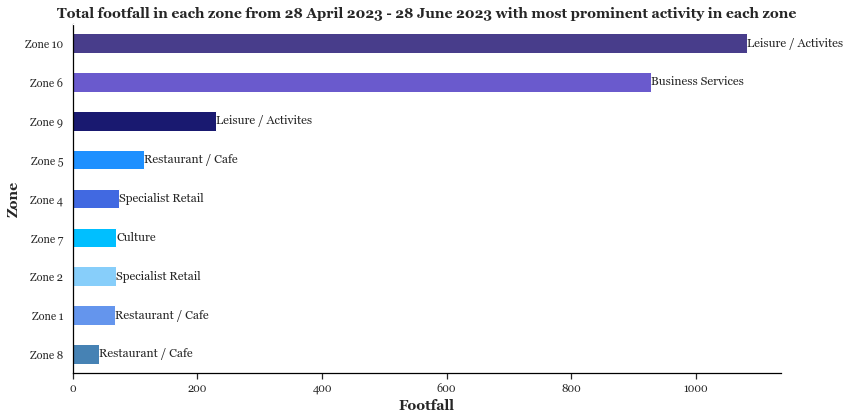

In [115]:
#Group the data and take aggregate footfall
zone_footfall = footfall_data_2.groupby('ZoneId_right')['Footfall'].sum()
zone_footfall = zone_footfall.sort_values(ascending=True)

#Zones and their most prominent activity taken from footfall dataset
zone_activities = {
    'Zone 1': 'Restaurant / Cafe',
    'Zone 2': 'Specialist Retail',
    'Zone 4': 'Specialist Retail',
    'Zone 5': 'Restaurant / Cafe',
    'Zone 6': 'Business Services',
    'Zone 7': 'Culture',
    'Zone 8': 'Restaurant / Cafe',
    'Zone 9': 'Leisure / Activites',
    'Zone 10': 'Leisure / Activites'
}

colours = ['steelblue', 'cornflowerblue', 'lightskyblue', 'deepskyblue', 'royalblue', 'dodgerblue',
          'midnightblue', 'slateblue', 'darkslateblue', 'mediumslateblue']

plt.figure(figsize=(12, 6))
zone_footfall.plot(kind='barh', color=colours)

plt.xlabel('Footfall', fontsize=14, fontweight='bold', fontfamily='Georgia')
plt.ylabel('Zone', fontsize=14, fontweight='bold', fontfamily='Georgia')
plt.title('Total footfall in each zone from 28 April 2023 - 28 June 2023 with most prominent activity in each zone', fontsize=14, fontweight='bold', fontfamily='Georgia')

plt.tick_params(axis='x', which='both', bottom=True)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.gca().set_facecolor('white')

#Labels to bars
for i, value in enumerate(zone_footfall):
    zone_label = f'{zone_activities[zone_footfall.index[i]]}' 
    plt.text(value, i, zone_label, ha='left', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('aggregate_footfall_zones.png', bbox_inches='tight')
plt.show()


**Showing aggregate footfall on each day of the week**

<Figure size 576x432 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 0, 'Footfall')

Text(0, 0.5, 'Day of the Week')

Text(0.5, 1.0, 'Footfall by Day of the Week')

([<matplotlib.axis.YTick at 0x184208e0a60>,
 [Text(0, 0, 'Monday'),
  Text(0, 1, 'Tuesday'),
  Text(0, 2, 'Wednesday'),
  Text(0, 3, 'Thursday'),
  Text(0, 4, 'Friday'),
  Text(0, 5, 'Saturday'),
  Text(0, 6, 'Sunday')])

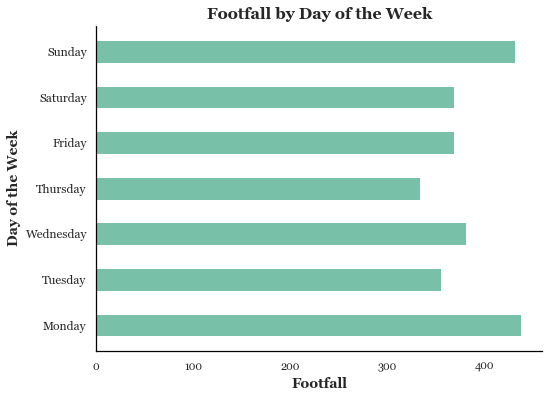

In [117]:
#Group data and get sum of footfall on each day of the week
footfall_by_day = footfall_data_2.groupby('DayOfWeek')['Footfall'].sum()

plt.figure(figsize=(8, 6))
plt.barh(footfall_by_day.index, footfall_by_day.values, color='#78C0A8', height=0.5)

plt.xlabel('Footfall', fontname='Georgia', fontsize=14, fontweight='bold')
plt.ylabel('Day of the Week', fontname='Georgia', fontsize=14, fontweight='bold')
plt.title('Footfall by Day of the Week', fontname='Georgia', fontsize=16, fontweight='bold')

plt.yticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontname='Georgia', fontsize=12)

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.savefig('horizontal_bar_footfall_dayofweek.png')

plt.show()

**Bar graph showing aggregate footfall for different weather categories**

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Weather')

Text(0, 0.5, 'Footfall')

Text(0.5, 1.0, 'Footfall across weather categories')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

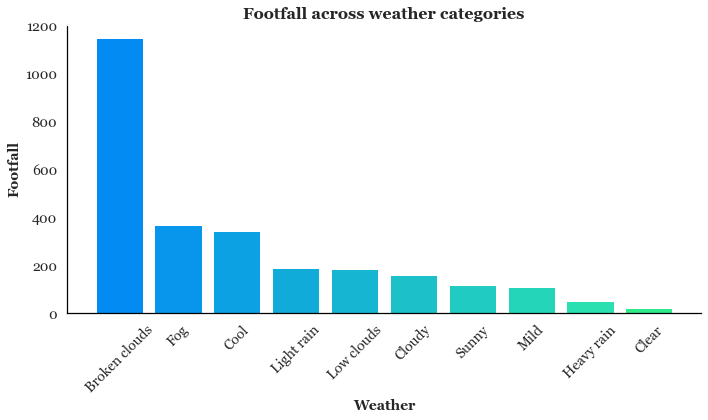

In [118]:
#Group the data by aggregate footfall for each weather category
weather_footfall = footfall_data_2.groupby('Weather')['Footfall'].sum()

weather_footfall_sorted = weather_footfall.sort_values(ascending=False)

colour_palette = ['#028CF3', '#0796EB', '#0CA1E2', '#11ABDA', '#16B6D2',
                 '#1BC0C9', '#20CBC1', '#25D5B9', '#2AE0B0', '#2FEA88']

plt.figure(figsize=(10, 6))  
bars = plt.bar(weather_footfall_sorted.index, weather_footfall_sorted, color=colour_palette)

plt.xlabel('Weather', fontname='Georgia', fontsize=14, fontweight='bold')
plt.ylabel('Footfall', fontname='Georgia', fontsize=14, fontweight='bold')
plt.title('Footfall across weather categories', fontname='Georgia', fontsize=16, fontweight='bold')

plt.xticks(rotation=45, fontname='Georgia', fontsize=14)
plt.yticks(fontname='Georgia', fontsize=14)

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('aggregate footfall across weather categories.png')

plt.show()


**To explain above, this shows most days consisted of broken clouds explaining that having the highest footfall, the limitation is the dataset we have is for only two months. A dataset with more days would provide a more comprehensive result**

In [119]:
#Finding the most frequent weather condition for each day from 28 April - 28 June
most_frequent_weather = footfall_data_2.groupby('Date')['Weather'].apply(lambda x: x.value_counts().idxmax())
weather_counts = most_frequent_weather.value_counts()

for weather, count in weather_counts.items():
    print(f"{weather} = {count} days")

Broken clouds = 37 days
Low clouds = 5 days
Fog = 5 days
Cool = 5 days
Light rain = 3 days
Mild = 3 days
Sunny = 2 days
Cloudy = 2 days


**Creating a line graph to see the relationship between different weather variables and aggregate footfall**

Temperature

Text(0.5, 0, 'Temperature in degrees celsius')

Text(0, 0.5, 'Footfall')

Text(0.5, 1.0, 'Aggregate Footfall by Temperature')

(array([ 5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

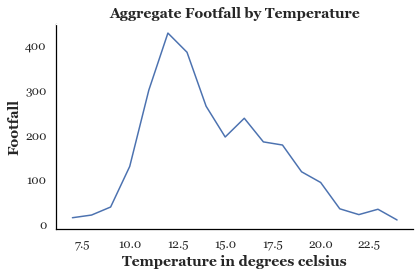

In [120]:
#Grouping data by aggregate footfall for different temperatures
aggregate_data_temp = footfall_data_2.groupby('Temp')['Footfall'].sum()

temperature = aggregate_data_temp.index.tolist()
footfall = aggregate_data_temp.values.tolist()

plt.plot(temperature, footfall)
plt.xlabel('Temperature in degrees celsius', fontsize=14, fontweight='bold')
plt.ylabel('Footfall', fontsize=14, fontweight='bold')
plt.title('Aggregate Footfall by Temperature', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)  

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.rcParams['font.family'] = 'Georgia'

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('aggregate footfall by temperature.png')

plt.show()


Note: this trend for temperature could be explained as there are only a few days where the temperature goes as high 20 degrees plus, most of the temperature is averaged around 10-12 degrees

In [121]:
temp_stats = footfall_data_2['Temp'].describe()
temp_stats

count    1873.000000
mean       14.585691
std         3.297767
min         7.000000
25%        12.000000
50%        14.000000
75%        17.000000
max        24.000000
Name: Temp, dtype: float64

Wind

Text(0.5, 0, 'Wind in mph')

Text(0, 0.5, 'Footfall')

Text(0.5, 1.0, 'Aggregate Footfall by Wind')

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

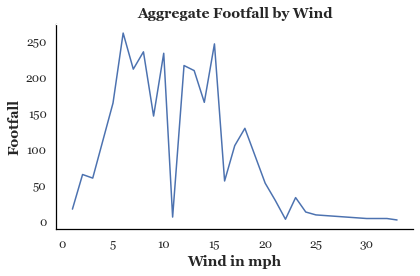

In [122]:
#Grouping data by aggregate footfall for different wind
aggregate_data_wind = footfall_data_2.groupby('Wind')['Footfall'].sum()

wind = aggregate_data_wind.index.tolist()
footfall = aggregate_data_wind.values.tolist()

plt.plot(wind, footfall)
plt.xlabel('Wind in mph', fontsize=14, fontweight='bold')
plt.ylabel('Footfall', fontsize=14, fontweight='bold')
plt.title('Aggregate Footfall by Wind', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)  

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.rcParams['font.family'] = 'Georgia'

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('aggregate footfall by wind.png')

plt.show()

In [123]:
temp_stats = footfall_data_2['Wind'].describe()
temp_stats

count    1873.000000
mean       10.877071
std         5.223004
min         1.000000
25%         7.000000
50%        10.000000
75%        14.000000
max        33.000000
Name: Wind, dtype: float64

Barometer/athmospheric pressure - the higher the reading on the barometer the better the weather

Text(0.5, 0, 'Barometer pressure in mbar')

Text(0, 0.5, 'Footfall')

Text(0.5, 1.0, 'Aggregate Footfall by Barometer pressure')

(array([1005., 1010., 1015., 1020., 1025., 1030., 1035.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

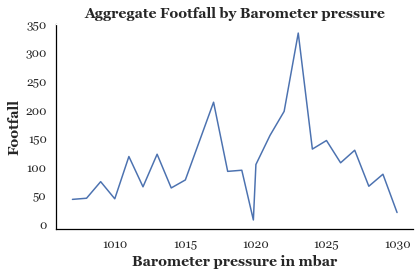

In [124]:
#Grouping data by aggregate footfall for different barometer pressure
aggregate_data_baro = footfall_data_2.groupby('Barometer')['Footfall'].sum()

barometer = aggregate_data_baro.index.tolist()
footfall = aggregate_data_baro.values.tolist()

plt.plot(barometer, footfall)
plt.xlabel('Barometer pressure in mbar', fontsize=14, fontweight='bold')
plt.ylabel('Footfall', fontsize=14, fontweight='bold')
plt.title('Aggregate Footfall by Barometer pressure', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)  

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.rcParams['font.family'] = 'Georgia'

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('aggregate footfall by barometer.png')

plt.show()

In [125]:
temp_stats = footfall_data_2['Barometer'].describe()
temp_stats

count    1873.000000
mean     1019.820128
std         5.645206
min      1007.000000
25%      1016.000000
50%      1021.000000
75%      1024.000000
max      1030.000000
Name: Barometer, dtype: float64

Humidity -  measured from 0-100%, where eg 95% humidity means air has soaked up 95% of moisture

Text(0.5, 0, 'Humdity in %')

Text(0, 0.5, 'Footfall')

Text(0.5, 1.0, 'Aggregate Footfall by Humidity')

(array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

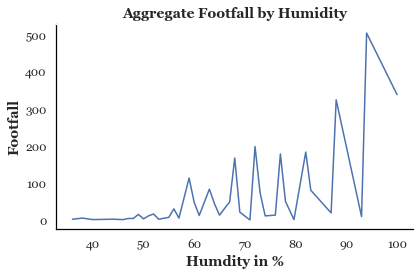

In [126]:
#Grouping data by aggregate footfall for different humidity
aggregate_data_humidity = footfall_data_2.groupby('Humidity')['Footfall'].sum()

humidity = aggregate_data_humidity.index.tolist()
footfall = aggregate_data_humidity.values.tolist()

plt.plot(humidity, footfall)
plt.xlabel('Humdity in %', fontsize=14, fontweight='bold')
plt.ylabel('Footfall', fontsize=14, fontweight='bold')
plt.title('Aggregate Footfall by Humidity', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)  

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.rcParams['font.family'] = 'Georgia'

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('aggregate footfall by humdity.png')

plt.show()

In [127]:
temp_stats = footfall_data_2['Humidity'].describe()
temp_stats

count    1873.000000
mean       79.677350
std        14.073698
min        36.000000
25%        68.000000
50%        82.000000
75%        94.000000
max       100.000000
Name: Humidity, dtype: float64

**Checking if an event happening in each zone affects footfall**

<BarContainer object of 2 artists>

Text(0.5, 0, 'Event in zone')

Text(0, 0.5, 'Average footfall')

Text(0.5, 1.0, 'Impact of events occurring on footfall')

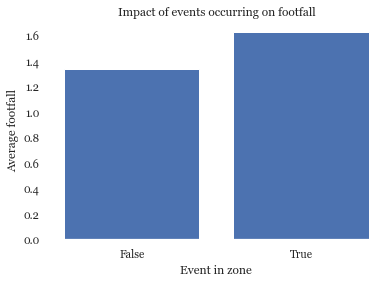

In [128]:
#Basic bar plot that takes the mean footfall
footfall_by_event = footfall_data_2.groupby('IsEventInZone')['Footfall'].mean()
plt.bar(footfall_by_event.index.astype(str), footfall_by_event.values)
plt.xlabel('Event in zone')
plt.ylabel('Average footfall')
plt.title('Impact of events occurring on footfall')
plt.show()

In [129]:
#Counting the amount of occurences of true or false for IsEventInZone for each zone
event_counts_by_zone = footfall_data_2.groupby(['ZoneId_right', 'IsEventInZone']).size().unstack()
#For loop to iterate through
for zone in event_counts_by_zone.index:
    zone_counts = event_counts_by_zone.loc[zone].fillna(0)
    true_count = int(zone_counts.get(True, 0))
    false_count = int(zone_counts.get(False, 0))
    print(f"{zone}: True: {true_count}, False: {false_count}")

Zone 1: True: 0, False: 66
Zone 10: True: 226, False: 416
Zone 2: True: 11, False: 54
Zone 4: True: 0, False: 70
Zone 5: True: 35, False: 55
Zone 6: True: 313, False: 323
Zone 7: True: 3, False: 65
Zone 8: True: 1, False: 38
Zone 9: True: 15, False: 182


<AxesSubplot:xlabel='ZoneId_right'>

Text(0.5, 1.0, 'Impact of events on footfall by zone')

Text(0.5, 0, 'Zone')

Text(0, 0.5, 'Average footfall')

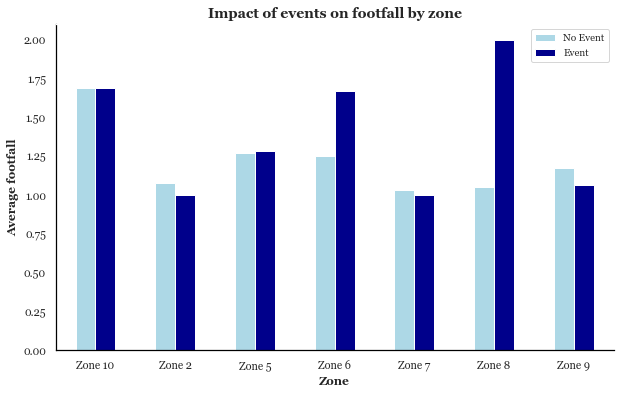

In [130]:
#Creating graph for each zone and IsEventInZone with the average footfall
footfall_event_zone = footfall_data_2.groupby(['IsEventInZone', 'ZoneId_right'])['Footfall'].mean().unstack(level=0)

filtered_footfall_event_zone = footfall_event_zone[footfall_event_zone[True] > 0]
fig, ax = plt.subplots(figsize=(10, 6))

#Bar plot
colours = ['#ADD8E6', '#00008B']  
filtered_footfall_event_zone.plot.bar(rot=0, ax=ax, color=colours)

ax.set_title('Impact of events on footfall by zone', fontsize=14, fontweight='bold')
ax.set_xlabel('Zone', fontweight='bold')
ax.set_ylabel('Average footfall', fontweight='bold')
ax.set_facecolor('white')
ax.legend(['No Event', 'Event'], fontsize=10)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.savefig('Impact of footfall on event by zone.png')

plt.show()

### Analysis df analysis

In [131]:
analysis_df_3

,Latitude_left,Longitude_left,TimeStampUtc,VisitorId,geometry,ZoneId,ZoneName,Title,Latitude_right,Longitude_right,Description
14157,50.155962,-5.087141,2023-04-28 00:25:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14156,50.155962,-5.087141,2023-04-28 00:26:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14155,50.155962,-5.087141,2023-04-28 00:28:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14154,50.155962,-5.087141,2023-04-28 00:29:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
14153,50.155962,-5.087141,2023-04-28 00:33:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe
...,...,...,...,...,...,...,...,...,...,...,...
140442,50.182953,-5.077417,2023-06-28 21:32:00,2228,POINT (-5.07742 50.18295),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140440,50.183011,-5.077349,2023-06-28 21:32:00,2228,POINT (-5.07735 50.18301),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140444,50.183041,-5.077570,2023-06-28 21:32:00,2228,POINT (-5.07757 50.18304),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN
140443,50.183000,-5.077480,2023-06-28 21:32:00,2228,POINT (-5.07748 50.18300),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN


**Checking the number of unique users per day**

In [132]:
#Extract date
analysis_df_3['Date'] = analysis_df_3['TimeStampUtc'].dt.date

#Count the unique visitors for each date
unique_users_per_day = analysis_df_3.groupby('Date')['VisitorId'].nunique()

unique_users_per_day

Date
2023-04-28    32
2023-04-29    18
2023-04-30    11
2023-05-01     7
2023-05-02    12
              ..
2023-06-24     5
2023-06-25    11
2023-06-26     5
2023-06-27     8
2023-06-28     7
Name: VisitorId, Length: 62, dtype: int64

<Figure size 720x432 with 0 Axes>

<BarContainer object of 62 artists>

Text(0.5, 1.0, 'Unique number of users per day (28 April 2023 - 28 June 2023)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of users')

(array([19478., 19485., 19492., 19499., 19509., 19516., 19523., 19530.,
        19539.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

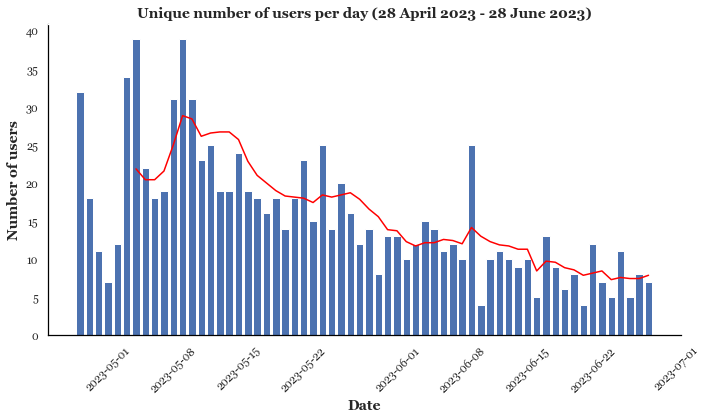

In [133]:
analysis_df_3['Date'] = pd.to_datetime(analysis_df_3['Date'], dayfirst=True)

plt.figure(figsize=(10,6))

#Bar plot
plt.bar(unique_users_per_day.index, unique_users_per_day.values)
rolling_mean = unique_users_per_day.rolling(window=7).mean()

#Linw plot
plt.plot(unique_users_per_day.index.to_numpy(), rolling_mean.to_numpy(), color='red')

plt.title('Unique number of users per day (28 April 2023 - 28 June 2023)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Number of users', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.tight_layout()
plt.savefig('number of users per day.png')

plt.show()

In [134]:
#Top five days with the highest numbers of users
top_five_days = unique_users_per_day.nlargest(5)

print("Top five days with the highest number of users:")
print(top_five_days)

Top five days with the highest number of users:
Date
2023-05-04    39
2023-05-09    39
2023-05-03    34
2023-04-28    32
2023-05-08    31
Name: VisitorId, dtype: int64


In [135]:
#Top five days with the lowest number of users
lowest_five_days = unique_users_per_day.nsmallest(5)

print("Top five days with the lowest number of users:")
print(lowest_five_days)

Top five days with the lowest number of users:
Date
2023-06-10    4
2023-06-21    4
2023-06-16    5
2023-06-24    5
2023-06-26    5
Name: VisitorId, dtype: int64


In [136]:
footfall_data_2

,Interval,ZoneId_right,ZoneName,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,...,IsEventInZone,VenueName,ProminentActivityInZone,Month,Hour,DayOfWeek,TimeIntervals,Date,Time,Week
0,2023-04-28 00:00:00,Zone 10,Woodlane Campus,1,11.0,Broken clouds,24.0,82.0,1015.0,8.000000,...,True,The Rodney Inn,Leisure / Activites,April,0,Friday,9pm-8am,2023-04-28,00:00:00,NaN
1,2023-04-28 06:00:00,Zone 10,Woodlane Campus,1,11.0,Light rain,9.0,94.0,1011.0,6.234657,...,True,The Rodney Inn,Leisure / Activites,April,6,Friday,9pm-8am,2023-04-28,06:00:00,NaN
2,2023-04-28 06:00:00,Zone 6,Old High St and Greenbank,1,11.0,Light rain,9.0,94.0,1011.0,6.234657,...,True,UpperDeck Falmouth,Business Services,April,6,Friday,9pm-8am,2023-04-28,06:00:00,NaN
3,2023-04-28 07:00:00,Zone 10,Woodlane Campus,1,11.0,Fog,14.0,94.0,1011.0,6.234657,...,True,The Rodney Inn,Leisure / Activites,April,7,Friday,9pm-8am,2023-04-28,07:00:00,NaN
4,2023-04-28 07:00:00,Zone 6,Old High St and Greenbank,2,11.0,Fog,14.0,94.0,1011.0,6.234657,...,True,UpperDeck Falmouth,Business Services,April,7,Friday,9pm-8am,2023-04-28,07:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2023-06-28 15:00:00,Zone 6,Old High St and Greenbank,1,18.0,Cloudy,12.0,94.0,1018.0,6.000000,...,False,,Business Services,June,15,Wednesday,8am-6pm,2023-06-28,15:00:00,NaN
1869,2023-06-28 16:00:00,Zone 6,Old High St and Greenbank,4,18.0,Light rain,13.0,94.0,1018.0,6.000000,...,False,,Business Services,June,16,Wednesday,8am-6pm,2023-06-28,16:00:00,NaN
1870,2023-06-28 17:00:00,Zone 6,Old High St and Greenbank,1,17.0,Light rain,12.0,100.0,1018.0,2.000000,...,False,,Business Services,June,17,Wednesday,8am-6pm,2023-06-28,17:00:00,NaN
1871,2023-06-28 19:00:00,Zone 6,Old High St and Greenbank,1,17.0,Broken clouds,14.0,88.0,1017.0,6.234657,...,False,,Business Services,June,19,Wednesday,6pm-9pm,2023-06-28,19:00:00,NaN


In [137]:
analysis_df_3

,Latitude_left,Longitude_left,TimeStampUtc,VisitorId,geometry,ZoneId,ZoneName,Title,Latitude_right,Longitude_right,Description,Date
14157,50.155962,-5.087141,2023-04-28 00:25:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe,2023-04-28
14156,50.155962,-5.087141,2023-04-28 00:26:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe,2023-04-28
14155,50.155962,-5.087141,2023-04-28 00:28:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe,2023-04-28
14154,50.155962,-5.087141,2023-04-28 00:29:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe,2023-04-28
14153,50.155962,-5.087141,2023-04-28 00:33:00,1447,POINT (-5.08714 50.15596),Zone 10,Woodlane Campus,New Bamboo House,50.158773,-5.086579,Restaurant / Cafe,2023-04-28
...,...,...,...,...,...,...,...,...,...,...,...,...
140442,50.182953,-5.077417,2023-06-28 21:32:00,2228,POINT (-5.07742 50.18295),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,2023-06-28
140440,50.183011,-5.077349,2023-06-28 21:32:00,2228,POINT (-5.07735 50.18301),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,2023-06-28
140444,50.183041,-5.077570,2023-06-28 21:32:00,2228,POINT (-5.07757 50.18304),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,2023-06-28
140443,50.183000,-5.077480,2023-06-28 21:32:00,2228,POINT (-5.07748 50.18300),Zone 6,Old High St and Greenbank,NaN,NaN,NaN,NaN,2023-06-28


### Generating the synthetic data

In [138]:
#Dropping columns not needed when created for exploratory analysis
footfall_data_2 = footfall_data_2.drop(['TimeIntervals', 'Date', 'Time', 'Week', 'VenueName', 'ZoneName'], axis=1)

Data synthesis technique called resampling

synthetic data code assistance from: https://practicaldatascience.co.uk/machine-learning/how-to-create-synthetic-data-sets-for-machine-learning

In [139]:
#Ensuring same synthetic data produced each run
np.random.seed(42)

#Creating synthetic data
size = 5000  
indices = np.random.choice(footfall_data_2.index, size=size, replace=True)
synthetic_data = footfall_data_2.loc[indices, :].reset_index(drop=True)

In [140]:
synthetic_data

,Interval,ZoneId_right,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,ProminentActivityInZone,Month,Hour,DayOfWeek
0,2023-05-28 07:00:00,Zone 10,2,12.0,Cool,5.0,77.0,1022.0,6.234657,False,False,True,Leisure / Activites,May,7,Sunday
1,2023-06-09 14:00:00,Zone 10,1,17.0,Broken clouds,24.0,77.0,1010.0,6.234657,False,False,False,Leisure / Activites,June,14,Friday
2,2023-05-18 17:00:00,Zone 1,1,15.0,Broken clouds,13.0,63.0,1028.0,6.234657,False,False,False,Restaurant / Cafe,May,17,Thursday
3,2023-06-01 18:00:00,Zone 10,1,16.0,Broken clouds,12.0,77.0,1022.0,6.234657,False,True,False,Leisure / Activites,June,18,Thursday
4,2023-05-28 09:00:00,Zone 6,1,17.0,Mild,8.0,59.0,1022.0,6.234657,False,False,False,Business Services,May,9,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-05-23 14:00:00,Zone 6,2,16.0,Cloudy,14.0,72.0,1027.0,6.234657,False,False,True,Business Services,May,14,Tuesday
4996,2023-05-08 20:00:00,Zone 10,1,13.0,Low clouds,6.0,100.0,1015.0,7.000000,True,True,False,Leisure / Activites,May,20,Monday
4997,2023-06-04 02:00:00,Zone 6,2,12.0,Broken clouds,5.0,77.0,1021.0,6.234657,False,False,False,Business Services,June,2,Sunday
4998,2023-05-29 00:00:00,Zone 7,1,12.0,Broken clouds,5.0,88.0,1023.0,6.234657,True,True,False,Culture,May,0,Monday


In [141]:
synthetic_data = synthetic_data.sort_values('Interval')

Evaluating the synthetic dataset against the original dataset

In [142]:
#Comparing the summary statistics of the original and synthetic dataset
original_stats = footfall_data_2.describe()
synthetic_stats = synthetic_data.describe()

In [143]:
original_stats

,Interval,Footfall,Temp,Wind,Humidity,Barometer,Visibility,Hour
count,1873,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000
mean,2023-05-24 05:09:03.940202752,1.429792,14.585691,10.877071,79.677350,1019.820128,6.234657,12.365190
min,2023-04-28 00:00:00,1.000000,7.000000,1.000000,36.000000,1007.000000,0.000000,0.000000
25%,2023-05-09 11:00:00,1.000000,12.000000,7.000000,68.000000,1016.000000,6.234657,8.000000
50%,2023-05-21 17:00:00,1.000000,14.000000,10.000000,82.000000,1021.000000,6.234657,12.000000
75%,2023-06-06 11:00:00,2.000000,17.000000,14.000000,94.000000,1024.000000,6.234657,17.000000
max,2023-06-28 21:00:00,8.000000,24.000000,33.000000,100.000000,1030.000000,16.000000,23.000000
std,NaN,0.840043,3.297767,5.223004,14.073698,5.645206,2.883927,5.456521


In [144]:
synthetic_stats

,Interval,Footfall,Temp,Wind,Humidity,Barometer,Visibility,Hour
count,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2023-05-24 14:31:35.039999744,1.433600,14.627400,10.848077,79.355806,1019.855440,6.287059,12.332800
min,2023-04-28 00:00:00,1.000000,7.000000,1.000000,36.000000,1007.000000,0.000000,0.000000
25%,2023-05-09 18:45:00,1.000000,12.000000,7.000000,68.000000,1016.000000,6.234657,9.000000
50%,2023-05-22 12:00:00,1.000000,14.000000,10.000000,78.000000,1021.000000,6.234657,12.000000
75%,2023-06-07 06:00:00,2.000000,17.000000,14.000000,94.000000,1024.000000,6.234657,16.000000
max,2023-06-28 21:00:00,8.000000,24.000000,33.000000,100.000000,1030.000000,16.000000,23.000000
std,NaN,0.846011,3.309858,5.231731,14.059880,5.672795,2.843350,5.443415


The statistics for all the variables are fairly similar

In [145]:
footfall_data_2.dtypes

Interval                   datetime64[ns]
ZoneId_right                       object
Footfall                            int64
Temp                              float64
Weather                            object
Wind                              float64
Humidity                          float64
Barometer                         float64
Visibility                        float64
IsBankHoliday                        bool
IsSchoolHoliday                      bool
IsEventInZone                        bool
ProminentActivityInZone            object
Month                              object
Hour                                int32
DayOfWeek                          object
dtype: object

(array([233., 280., 289., 163., 200., 190., 118., 131., 146., 123.]),
 array([19475.    , 19481.1875, 19487.375 , 19493.5625, 19499.75  ,
        19505.9375, 19512.125 , 19518.3125, 19524.5   , 19530.6875,
        19536.875 ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([609., 696., 767., 456., 556., 518., 302., 357., 397., 342.]),
 array([19475.    , 19481.1875, 19487.375 , 19493.5625, 19499.75  ,
        19505.9375, 19512.125 , 19518.3125, 19524.5   , 19530.6875,
        19536.875 ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Interval')

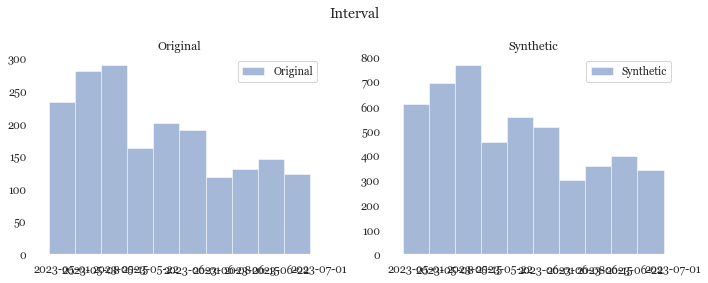

(array([642., 636.,  39., 197.,   0.,  65.,  90.,  70.,  68.,  66.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([1757., 1664.,  519.,   94.,    0.,  165.,  243.,  171.,  183.,
         204.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'ZoneId_right')

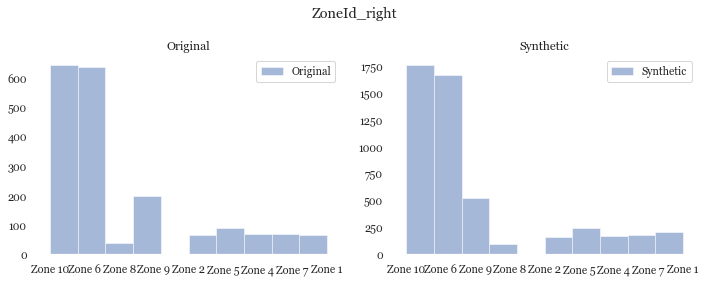

(array([1350.,  337.,  123.,    0.,   42.,   15.,    0.,    2.,    2.,
           2.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([3.613e+03, 8.650e+02, 3.470e+02, 0.000e+00, 1.200e+02, 4.200e+01,
        0.000e+00, 3.000e+00, 4.000e+00, 6.000e+00]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Footfall')

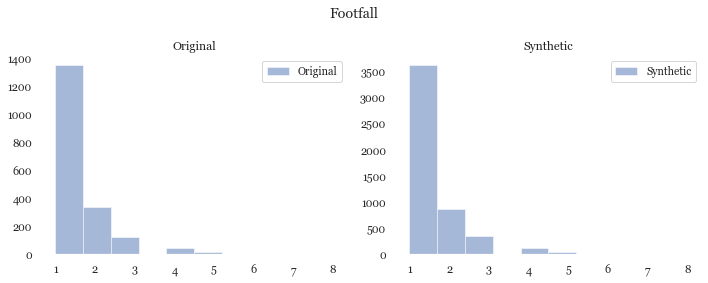

(array([ 24., 119., 446., 247., 323., 326., 135., 176.,  45.,  32.]),
 array([ 7. ,  8.7, 10.4, 12.1, 13.8, 15.5, 17.2, 18.9, 20.6, 22.3, 24. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([  70.,  305., 1183.,  654.,  855.,  855.,  396.,  473.,  129.,
          80.]),
 array([ 7. ,  8.7, 10.4, 12.1, 13.8, 15.5, 17.2, 18.9, 20.6, 22.3, 24. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Temp')

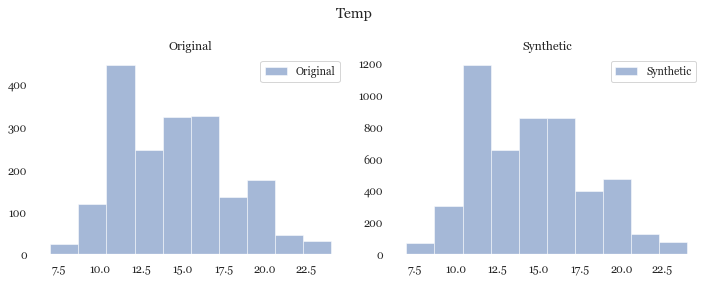

(array([807., 118., 226., 120., 121.,  95., 250.,  28.,  17.,  91.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([2146.,  283.,  570.,  344.,  330.,  252.,  677.,   70.,   50.,
         278.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Weather')

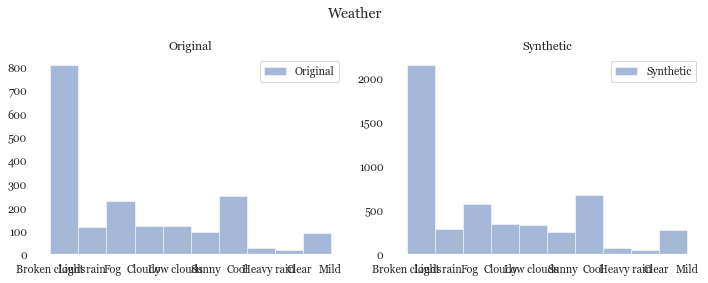

(array([107., 478., 423., 297., 299., 195.,  39.,  21.,   0.,  14.]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([ 294., 1302., 1088.,  776.,  824.,  526.,   89.,   65.,    0.,
          36.]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Wind')

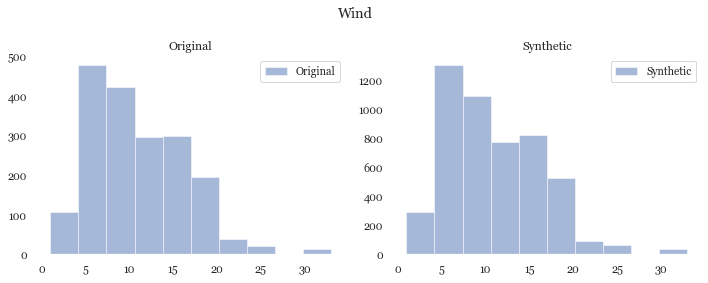

(array([  9.,  13.,  45., 153., 151., 355., 191., 216., 214., 526.]),
 array([ 36. ,  42.4,  48.8,  55.2,  61.6,  68. ,  74.4,  80.8,  87.2,
         93.6, 100. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([  23.,   35.,  124.,  421.,  425.,  956.,  522.,  556.,  568.,
        1370.]),
 array([ 36. ,  42.4,  48.8,  55.2,  61.6,  68. ,  74.4,  80.8,  87.2,
         93.6, 100. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Humidity')

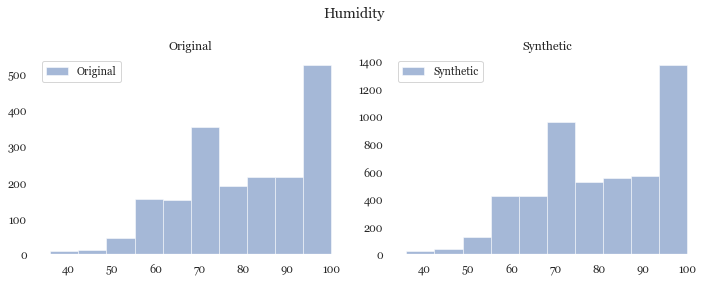

(array([ 99., 104., 127., 185., 202., 163., 486., 205., 179., 123.]),
 array([1007. , 1009.3, 1011.6, 1013.9, 1016.2, 1018.5, 1020.8, 1023.1,
        1025.4, 1027.7, 1030. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([ 280.,  267.,  348.,  478.,  519.,  415., 1290.,  586.,  493.,
         324.]),
 array([1007. , 1009.3, 1011.6, 1013.9, 1016.2, 1018.5, 1020.8, 1023.1,
        1025.4, 1027.7, 1030. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Barometer')

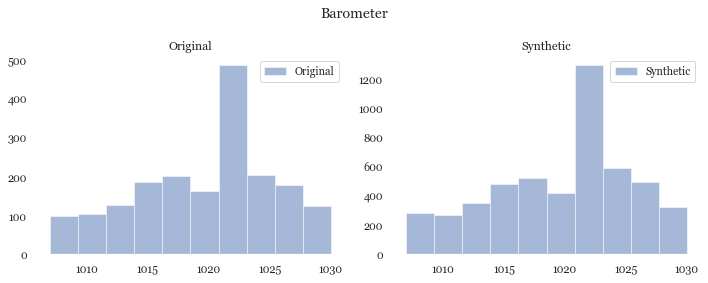

(array([ 124.,   72.,   18., 1451.,   22.,   87.,    0.,    0.,    0.,
          99.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([ 301.,  179.,   45., 3915.,   48.,  248.,    0.,    0.,    0.,
         264.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Visibility')

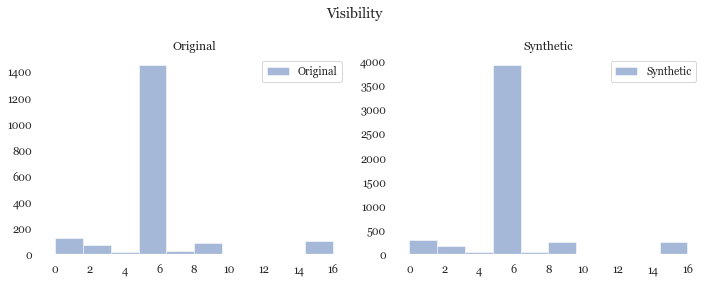

(array([839.,   0., 636.,   0.,   0., 195.,   0., 135.,   0.,  68.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([2276.,    0., 1664.,    0.,    0.,  541.,    0.,  336.,    0.,
         183.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'ProminentActivityInZone')

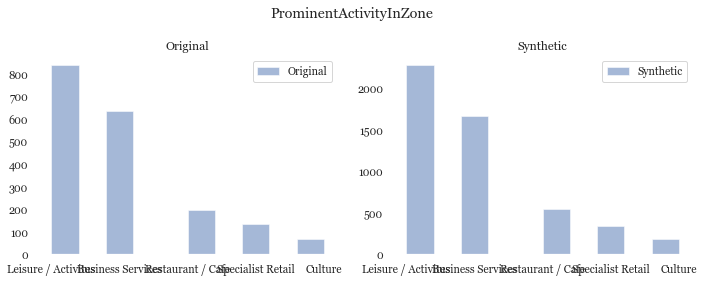

(array([ 110.,    0.,    0.,    0.,    0., 1149.,    0.,    0.,    0.,
         614.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([ 278.,    0.,    0.,    0.,    0., 3072.,    0.,    0.,    0.,
        1650.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Month')

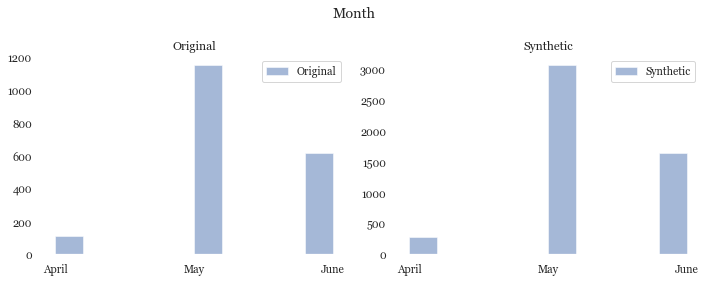

(array([ 86.,  54., 131., 318., 253., 219., 341., 191., 137., 143.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([243., 138., 363., 843., 642., 603., 945., 499., 363., 361.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'Hour')

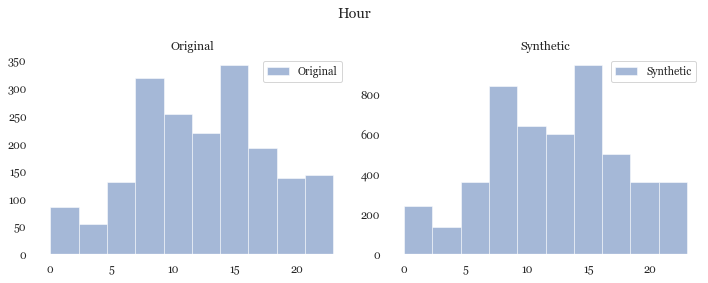

(array([280., 290.,   0., 258.,   0., 267., 259.,   0., 273., 246.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original')

(array([723., 771.,   0., 724.,   0., 720., 738.,   0., 710., 614.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Synthetic')

Text(0.5, 0.98, 'DayOfWeek')

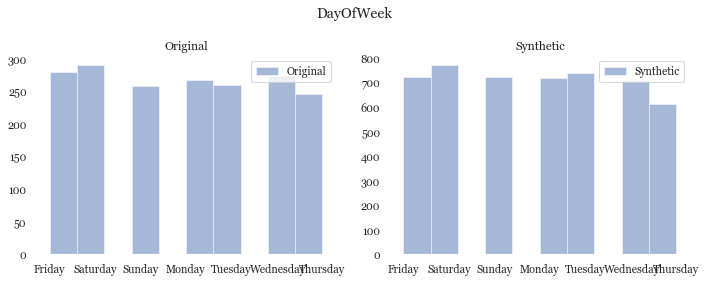

In [146]:
#Using visualisations to check the similarity excluding boolean datatype variables
for column in synthetic_data.select_dtypes(exclude='bool').columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    axes[0].hist(footfall_data_2[column], bins=10, alpha=0.5, label='Original')
    axes[0].set_title('Original')
    axes[0].legend()

    axes[1].hist(synthetic_data[column], bins=10, alpha=0.5, label='Synthetic')
    axes[1].set_title('Synthetic')
    axes[1].legend()

    fig.suptitle(column)
    plt.tight_layout()

    plt.show()


<AxesSubplot:xlabel='IsBankHoliday', ylabel='count'>

Text(0.5, 1.0, 'Original')

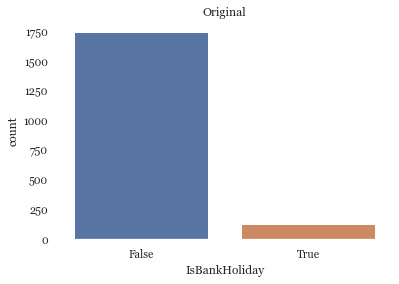

<AxesSubplot:xlabel='IsBankHoliday', ylabel='count'>

Text(0.5, 1.0, 'Synthetic')

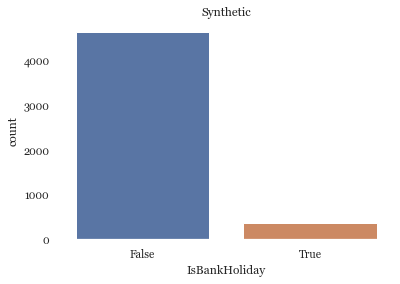

<AxesSubplot:xlabel='IsSchoolHoliday', ylabel='count'>

Text(0.5, 1.0, 'Original')

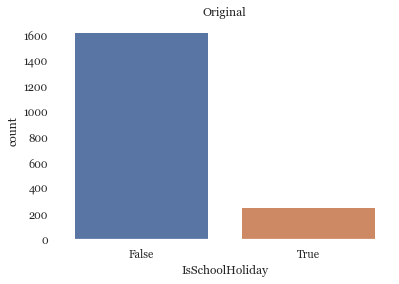

<AxesSubplot:xlabel='IsSchoolHoliday', ylabel='count'>

Text(0.5, 1.0, 'Synthetic')

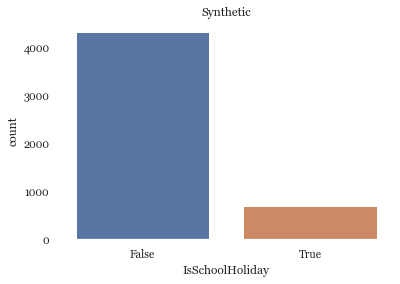

<AxesSubplot:xlabel='IsEventInZone', ylabel='count'>

Text(0.5, 1.0, 'Original')

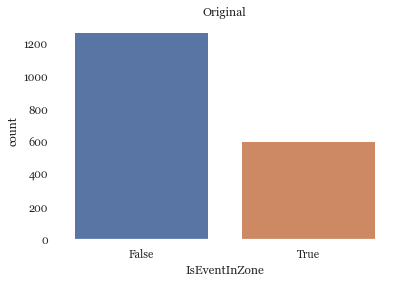

<AxesSubplot:xlabel='IsEventInZone', ylabel='count'>

Text(0.5, 1.0, 'Synthetic')

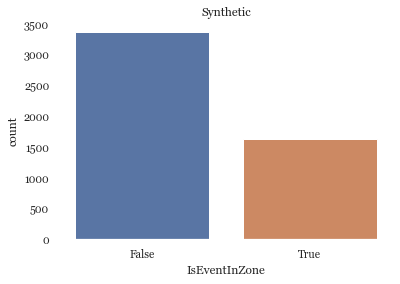

In [147]:
#Using visualisations to check the similarity including boolean datatype variables
for column in synthetic_data.columns:
    if synthetic_data[column].dtype != 'bool':
        continue
        
    sns.countplot(x=column, data=footfall_data_2)
    plt.title('Original')
    plt.show()

    sns.countplot(x=column, data=synthetic_data)
    plt.title('Synthetic')
    plt.show()

In [148]:
#Combining the original footfall data with the synthetic data
footfall_data_full = pd.concat([footfall_data_2, synthetic_data], ignore_index=True)

In [149]:
footfall_data_full

,Interval,ZoneId_right,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,ProminentActivityInZone,Month,Hour,DayOfWeek
0,2023-04-28 00:00:00,Zone 10,1,11.0,Broken clouds,24.0,82.0,1015.0,8.000000,False,False,True,Leisure / Activites,April,0,Friday
1,2023-04-28 06:00:00,Zone 10,1,11.0,Light rain,9.0,94.0,1011.0,6.234657,False,False,True,Leisure / Activites,April,6,Friday
2,2023-04-28 06:00:00,Zone 6,1,11.0,Light rain,9.0,94.0,1011.0,6.234657,False,False,True,Business Services,April,6,Friday
3,2023-04-28 07:00:00,Zone 10,1,11.0,Fog,14.0,94.0,1011.0,6.234657,False,False,True,Leisure / Activites,April,7,Friday
4,2023-04-28 07:00:00,Zone 6,2,11.0,Fog,14.0,94.0,1011.0,6.234657,False,False,True,Business Services,April,7,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6868,2023-06-28 19:00:00,Zone 6,1,17.0,Broken clouds,14.0,88.0,1017.0,6.234657,False,False,False,Business Services,June,19,Wednesday
6869,2023-06-28 21:00:00,Zone 6,1,17.0,Broken clouds,9.0,83.0,1018.0,6.234657,False,False,False,Business Services,June,21,Wednesday
6870,2023-06-28 21:00:00,Zone 6,1,17.0,Broken clouds,9.0,83.0,1018.0,6.234657,False,False,False,Business Services,June,21,Wednesday
6871,2023-06-28 21:00:00,Zone 6,1,17.0,Broken clouds,9.0,83.0,1018.0,6.234657,False,False,False,Business Services,June,21,Wednesday


In [150]:
#Renaming zoneid
footfall_data_full.rename(columns={'ZoneId_right': 'Zone_Id'}, inplace=True)

In [151]:
footfall_data_full.dtypes

Interval                   datetime64[ns]
Zone_Id                            object
Footfall                            int64
Temp                              float64
Weather                            object
Wind                              float64
Humidity                          float64
Barometer                         float64
Visibility                        float64
IsBankHoliday                        bool
IsSchoolHoliday                      bool
IsEventInZone                        bool
ProminentActivityInZone            object
Month                              object
Hour                                int32
DayOfWeek                          object
dtype: object

### Generating additional points for less frequent footfall values

<Figure size 576x432 with 0 Axes>

<AxesSubplot:xlabel='Footfall', ylabel='count'>

Text(0.5, 0, 'Footfall')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of footfall values')

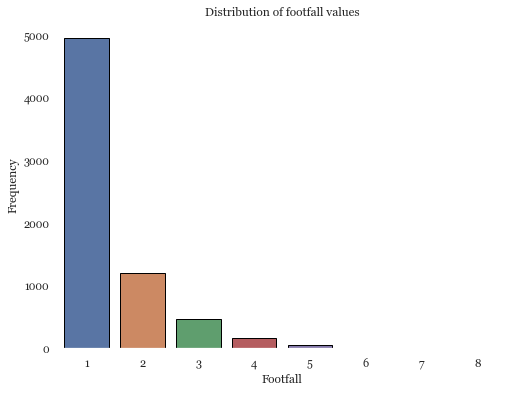

In [152]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Footfall', data=footfall_data_full, edgecolor='black')
plt.xlabel('Footfall')
plt.ylabel('Frequency')
plt.title('Distribution of footfall values')
plt.savefig('distribution_of_footfall.png')
plt.show()

In [153]:
footfall_counts = footfall_data_full['Footfall'].value_counts()
footfall_counts

Footfall
1    4963
2    1202
3     470
4     162
5      57
8       8
7       6
6       5
Name: count, dtype: int64

In [154]:
np.random.seed(42)

desired_count = 200
less_frequent_footfall_values = footfall_counts[footfall_counts < desired_count].index.tolist()

synthetic_data_2 = []

for footfall_value in less_frequent_footfall_values:
    indices = footfall_data_full[footfall_data_full['Footfall'] == footfall_value].index
    num_synthetic_points = desired_count - len(indices)
    synthetic_points_2 = np.random.choice(indices, size=num_synthetic_points, replace=True)
    synthetic_data_2.extend(synthetic_points_2)

synthetic_df_2 = footfall_data_full.loc[synthetic_data_2]

In [155]:
synthetic_df_2

,Interval,Zone_Id,Footfall,Temp,Weather,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,ProminentActivityInZone,Month,Hour,DayOfWeek
2792,2023-05-07 15:00:00,Zone 10,4,14.0,Broken clouds,10.0,88.0,1020.0,6.234657,False,False,False,Leisure / Activites,May,15,Sunday
2710,2023-05-06 15:00:00,Zone 10,4,16.0,Broken clouds,8.0,77.0,1011.0,6.234657,False,False,False,Leisure / Activites,May,15,Saturday
305,2023-05-05 12:00:00,Zone 10,4,13.0,Low clouds,12.0,88.0,1011.0,6.234657,False,False,True,Leisure / Activites,May,12,Friday
2932,2023-05-08 12:00:00,Zone 10,4,13.0,Light rain,12.0,100.0,1017.0,0.000000,True,True,False,Leisure / Activites,May,12,Monday
2436,2023-05-03 15:00:00,Zone 10,4,11.0,Fog,15.0,94.0,1023.0,5.000000,False,False,True,Leisure / Activites,May,15,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,2023-05-04 07:00:00,Zone 10,6,11.0,Broken clouds,18.0,88.0,1009.0,6.000000,False,False,False,Leisure / Activites,May,7,Thursday
2496,2023-05-04 07:00:00,Zone 10,6,11.0,Broken clouds,18.0,88.0,1009.0,6.000000,False,False,False,Leisure / Activites,May,7,Thursday
3450,2023-05-12 12:00:00,Zone 10,6,16.0,Broken clouds,10.0,68.0,1023.0,6.234657,False,False,True,Leisure / Activites,May,12,Friday
238,2023-05-04 07:00:00,Zone 10,6,11.0,Broken clouds,18.0,88.0,1009.0,6.000000,False,False,False,Leisure / Activites,May,7,Thursday


In [156]:
footfall_data_final = pd.concat([footfall_data_full, synthetic_df_2], ignore_index=True)

## Dataset splitting

In [157]:
#sort data
footfall_data_final.sort_values(by='Interval', inplace=True)
footfall_data_final.reset_index(drop=True, inplace=True)

**Augmented Dickey-Fuller test**

This test is used to check if the data is stationary or non-stationary

Code assistance from: https://www.statology.org/dickey-fuller-test-python/

In [158]:
footfall_data_adf = footfall_data_final['Footfall'].values

result_adf = adfuller(footfall_data_adf)
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:', result_adf[4])

ADF Statistic: -6.456169052986762
p-value: 1.4815949339722198e-08
Critical Values: {'1%': -3.4312094806021944, '5%': -2.861919826171502, '10%': -2.566972176990025}


Given the p-value is less than 0.05, we reject the null hypothesis suggesting the data is stationary and there is no timeseries dependecies. 

In [159]:
#Splitting
X = footfall_data_final.drop(columns=['Footfall'])
y = footfall_data_final['Footfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (5344, 15) (5344,)
Testing set shape: (2291, 15) (2291,)


In [160]:
#Creating a copy of the training set
X_train_1 = X_train.copy()

Text(0.5, 0.98, 'Distribution of months and hours in training and testing Sets')

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'Training set - month distribution')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Count')

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'Testing set - month distribution')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Count')

<BarContainer object of 24 artists>

Text(0.5, 1.0, 'Training set - hour distribution')

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Count')

<BarContainer object of 24 artists>

Text(0.5, 1.0, 'Testing set - hour distribution')

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Count')

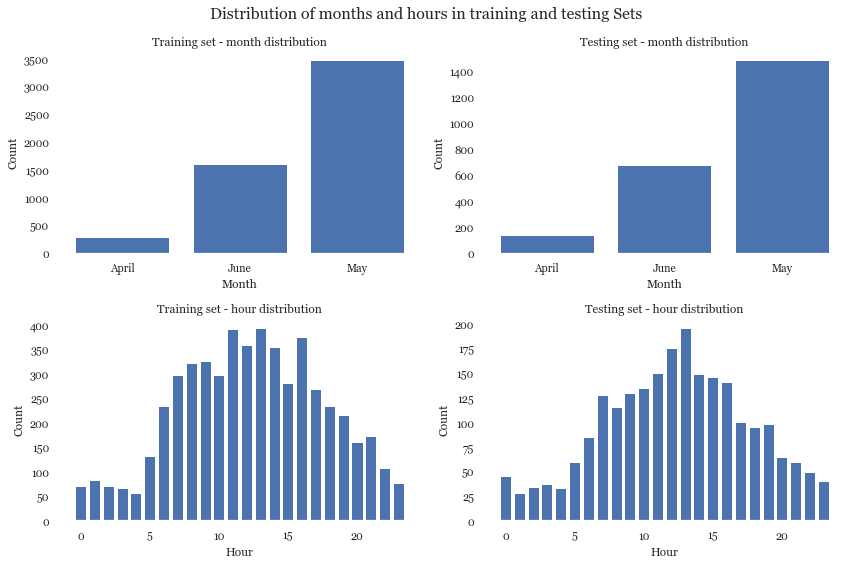

In [161]:
#Checking distribution of month and hour in the training and testing sets
train_month_distribution = X_train['Month'].value_counts().sort_index()
test_month_distribution = X_test['Month'].value_counts().sort_index()
train_hour_distribution = X_train['Hour'].value_counts().sort_index()
test_hour_distribution = X_test['Hour'].value_counts().sort_index()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Distribution of months and hours in training and testing Sets", fontsize=16)

axes[0, 0].bar(train_month_distribution.index, train_month_distribution.values)
axes[0, 0].set_title("Training set - month distribution")
axes[0, 0].set_xlabel("Month")
axes[0, 0].set_ylabel("Count")

axes[0, 1].bar(test_month_distribution.index, test_month_distribution.values)
axes[0, 1].set_title("Testing set - month distribution")
axes[0, 1].set_xlabel("Month")
axes[0, 1].set_ylabel("Count")

axes[1, 0].bar(train_hour_distribution.index, train_hour_distribution.values)
axes[1, 0].set_title("Training set - hour distribution")
axes[1, 0].set_xlabel("Hour")
axes[1, 0].set_ylabel("Count")

axes[1, 1].bar(test_hour_distribution.index, test_hour_distribution.values)
axes[1, 1].set_title("Testing set - hour distribution")
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.savefig('distribution_month_hour.png')
plt.show()

## Data pre-processing

In [162]:
X_train_1.dtypes

Interval                   datetime64[ns]
Zone_Id                            object
Temp                              float64
Weather                            object
Wind                              float64
Humidity                          float64
Barometer                         float64
Visibility                        float64
IsBankHoliday                        bool
IsSchoolHoliday                      bool
IsEventInZone                        bool
ProminentActivityInZone            object
Month                              object
Hour                                int32
DayOfWeek                          object
dtype: object

In [163]:
X_test.dtypes

Interval                   datetime64[ns]
Zone_Id                            object
Temp                              float64
Weather                            object
Wind                              float64
Humidity                          float64
Barometer                         float64
Visibility                        float64
IsBankHoliday                        bool
IsSchoolHoliday                      bool
IsEventInZone                        bool
ProminentActivityInZone            object
Month                              object
Hour                                int32
DayOfWeek                          object
dtype: object

### Performing one-hot encoding

We perform one-hot encoding to "Zone_Id", "Weather", "ProminentActivityInZone", "DayOfWeek", "Month". 

In [164]:
one_hot_encode_columns = ["Zone_Id", "Weather", "ProminentActivityInZone", "DayOfWeek", "Month"]

#Training set
X_train_encoded = pd.get_dummies(X_train_1, columns=one_hot_encode_columns)

#Testing set
X_test_encoded = pd.get_dummies(X_test, columns=one_hot_encode_columns)

In [165]:
X_train_encoded

,Interval,Temp,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,Hour,...,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month_April,Month_June,Month_May
4741,2023-05-27 07:00:00,11.0,10.0,77.0,1026.0,6.234657,False,False,True,7,...,False,False,True,False,False,False,False,False,False,True
1710,2023-05-06 16:00:00,16.0,10.0,72.0,1011.0,6.234657,False,False,False,16,...,False,False,True,False,False,False,False,False,False,True
3641,2023-05-16 16:00:00,15.0,15.0,51.0,1027.0,6.234657,False,False,False,16,...,False,False,False,False,False,True,False,False,False,True
4480,2023-05-25 07:00:00,12.0,8.0,88.0,1028.0,6.234657,False,False,False,7,...,False,False,False,False,True,False,False,False,False,True
1186,2023-05-04 09:00:00,12.0,23.0,88.0,1008.0,3.000000,False,False,False,9,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2023-05-30 16:00:00,16.0,14.0,63.0,1027.0,16.000000,False,True,False,16,...,False,False,False,False,False,True,False,False,False,True
5390,2023-06-01 09:00:00,13.0,20.0,82.0,1023.0,6.234657,False,True,False,9,...,False,False,False,False,True,False,False,False,True,False
860,2023-05-03 14:00:00,11.0,15.0,94.0,1023.0,5.000000,False,False,True,14,...,False,False,False,False,False,False,True,False,False,True
7603,2023-06-28 08:00:00,17.0,8.0,100.0,1019.0,8.000000,False,False,False,8,...,False,False,False,False,False,False,True,False,True,False


### Converting boolean variables to integers

In [166]:
boolean_columns = ['IsBankHoliday', 'IsSchoolHoliday', 'IsEventInZone']

#Training set
X_train_encoded[boolean_columns] = X_train_encoded[boolean_columns].astype(int)

#Testing set
X_test_encoded[boolean_columns] = X_test_encoded[boolean_columns].astype(int)

After all encoding, we rename the columns so we understand

In [167]:
X_train_encoded.rename(columns={
    'Zone_Id_Zone 1': 'ZoneId_Zone1',
    'Zone_Id_Zone 10': 'ZoneId_Zone10',
    'Zone_Id_Zone 2': 'ZoneId_Zone2',
    'Zone_Id_Zone 4': 'ZoneId_Zone4',
    'Zone_Id_Zone 5': 'ZoneId_Zone5',
    'Zone_Id_Zone 6': 'ZoneId_Zone6',
    'Zone_Id_Zone 7': 'ZoneId_Zone7',
    'Zone_Id_Zone 8': 'ZoneId_Zone8',
    'Zone_Id_Zone 9': 'ZoneId_Zone9',
    'Weather_Broken clouds': 'Weather_BrokenClouds',
    'Weather_Heavy rain': 'Weather_HeavyRain',
    'Weather_Light rain': 'Weather_LightRain',
    'Weather_Low clouds': 'Weather_LowClouds',
    'ProminentActivityInZone_Business Services': 'ProminentActivity_BusinessServices',
    'ProminentActivityInZone_Culture': 'ProminentActivity_Culture',
    'ProminentActivityInZone_Leisure / Activites': 'ProminentActivity_LeisureActivities',
    'ProminentActivityInZone_Restaurant / Cafe': 'ProminentActivity_RestaurantCafe',
    'ProminentActivityInZone_Specialist Retail': 'ProminentActivity_SpecialistRetail'
}, inplace=True)

X_train_encoded

,Interval,Temp,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,Hour,...,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month_April,Month_June,Month_May
4741,2023-05-27 07:00:00,11.0,10.0,77.0,1026.0,6.234657,0,0,1,7,...,False,False,True,False,False,False,False,False,False,True
1710,2023-05-06 16:00:00,16.0,10.0,72.0,1011.0,6.234657,0,0,0,16,...,False,False,True,False,False,False,False,False,False,True
3641,2023-05-16 16:00:00,15.0,15.0,51.0,1027.0,6.234657,0,0,0,16,...,False,False,False,False,False,True,False,False,False,True
4480,2023-05-25 07:00:00,12.0,8.0,88.0,1028.0,6.234657,0,0,0,7,...,False,False,False,False,True,False,False,False,False,True
1186,2023-05-04 09:00:00,12.0,23.0,88.0,1008.0,3.000000,0,0,0,9,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2023-05-30 16:00:00,16.0,14.0,63.0,1027.0,16.000000,0,1,0,16,...,False,False,False,False,False,True,False,False,False,True
5390,2023-06-01 09:00:00,13.0,20.0,82.0,1023.0,6.234657,0,1,0,9,...,False,False,False,False,True,False,False,False,True,False
860,2023-05-03 14:00:00,11.0,15.0,94.0,1023.0,5.000000,0,0,1,14,...,False,False,False,False,False,False,True,False,False,True
7603,2023-06-28 08:00:00,17.0,8.0,100.0,1019.0,8.000000,0,0,0,8,...,False,False,False,False,False,False,True,False,True,False


In [168]:
X_test_encoded.rename(columns={
    'Zone_Id_Zone 1': 'ZoneId_Zone1',
    'Zone_Id_Zone 10': 'ZoneId_Zone10',
    'Zone_Id_Zone 2': 'ZoneId_Zone2',
    'Zone_Id_Zone 4': 'ZoneId_Zone4',
    'Zone_Id_Zone 5': 'ZoneId_Zone5',
    'Zone_Id_Zone 6': 'ZoneId_Zone6',
    'Zone_Id_Zone 7': 'ZoneId_Zone7',
    'Zone_Id_Zone 8': 'ZoneId_Zone8',
    'Zone_Id_Zone 9': 'ZoneId_Zone9',
    'Weather_Broken clouds': 'Weather_BrokenClouds',
    'Weather_Heavy rain': 'Weather_HeavyRain',
    'Weather_Light rain': 'Weather_LightRain',
    'Weather_Low clouds': 'Weather_LowClouds',
    'ProminentActivityInZone_Business Services': 'ProminentActivity_BusinessServices',
    'ProminentActivityInZone_Culture': 'ProminentActivity_Culture',
    'ProminentActivityInZone_Leisure / Activites': 'ProminentActivity_LeisureActivities',
    'ProminentActivityInZone_Restaurant / Cafe': 'ProminentActivity_RestaurantCafe',
    'ProminentActivityInZone_Specialist Retail': 'ProminentActivity_SpecialistRetail'
}, inplace=True)

X_test_encoded

,Interval,Temp,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,Hour,...,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month_April,Month_June,Month_May
683,2023-05-03 00:00:00,11.0,15.0,94.0,1023.0,5.000000,0,0,1,0,...,False,False,False,False,False,False,True,False,False,True
6375,2023-06-13 14:00:00,23.0,6.0,74.0,1013.0,6.234657,0,0,0,14,...,False,False,False,False,False,True,False,False,True,False
5804,2023-06-04 18:00:00,20.0,15.0,38.0,1021.0,6.234657,0,0,0,18,...,False,False,False,True,False,False,False,False,True,False
2484,2023-05-10 11:00:00,13.0,17.0,82.0,1016.0,6.234657,0,0,0,11,...,False,False,False,False,False,False,True,False,False,True
4279,2023-05-23 07:00:00,12.0,9.0,88.0,1026.0,6.234657,0,0,1,7,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5786,2023-06-04 15:00:00,20.0,14.0,49.0,1022.0,6.234657,0,0,0,15,...,False,False,False,True,False,False,False,False,True,False
2968,2023-05-12 13:00:00,16.0,6.0,72.0,1024.0,6.234657,0,0,0,13,...,True,False,False,False,False,False,False,False,False,True
3992,2023-05-20 15:00:00,17.0,7.0,68.0,1024.0,6.234657,0,0,1,15,...,False,False,True,False,False,False,False,False,False,True
7207,2023-06-23 09:00:00,19.0,14.0,88.0,1024.0,6.234657,0,0,0,9,...,True,False,False,False,False,False,False,False,True,False


In [169]:
#Converting the boolean values to numeric to run in the models whereby 1 is true and 0 is false 
X_train_encoded['ZoneId_Zone1'] = X_train_encoded['ZoneId_Zone1'].astype(int)
X_train_encoded['ZoneId_Zone10'] = X_train_encoded['ZoneId_Zone10'].astype(int)
X_train_encoded['ZoneId_Zone2'] = X_train_encoded['ZoneId_Zone2'].astype(int)
X_train_encoded['ZoneId_Zone4'] = X_train_encoded['ZoneId_Zone4'].astype(int)
X_train_encoded['ZoneId_Zone5'] = X_train_encoded['ZoneId_Zone5'].astype(int)
X_train_encoded['ZoneId_Zone6'] = X_train_encoded['ZoneId_Zone6'].astype(int)
X_train_encoded['ZoneId_Zone7'] = X_train_encoded['ZoneId_Zone7'].astype(int)
X_train_encoded['ZoneId_Zone8'] = X_train_encoded['ZoneId_Zone8'].astype(int)
X_train_encoded['ZoneId_Zone9'] = X_train_encoded['ZoneId_Zone9'].astype(int)
X_train_encoded['Weather_BrokenClouds'] = X_train_encoded['Weather_BrokenClouds'].astype(int)
X_train_encoded['Weather_Clear'] = X_train_encoded['Weather_Clear'].astype(int)
X_train_encoded['Weather_Cloudy'] = X_train_encoded['Weather_Cloudy'].astype(int)
X_train_encoded['Weather_Cool'] = X_train_encoded['Weather_Cool'].astype(int)
X_train_encoded['Weather_Fog'] = X_train_encoded['Weather_Fog'].astype(int)
X_train_encoded['Weather_HeavyRain'] = X_train_encoded['Weather_HeavyRain'].astype(int)
X_train_encoded['Weather_LightRain'] = X_train_encoded['Weather_LightRain'].astype(int)
X_train_encoded['Weather_LowClouds'] = X_train_encoded['Weather_LowClouds'].astype(int)
X_train_encoded['Weather_Mild'] = X_train_encoded['Weather_Mild'].astype(int)
X_train_encoded['Weather_Sunny'] = X_train_encoded['Weather_Sunny'].astype(int)
X_train_encoded['ProminentActivity_BusinessServices'] = X_train_encoded['ProminentActivity_BusinessServices'].astype(int)
X_train_encoded['ProminentActivity_Culture'] = X_train_encoded['ProminentActivity_Culture'].astype(int)
X_train_encoded['ProminentActivity_LeisureActivities'] = X_train_encoded['ProminentActivity_LeisureActivities'].astype(int)
X_train_encoded['ProminentActivity_RestaurantCafe'] = X_train_encoded['ProminentActivity_RestaurantCafe'].astype(int)
X_train_encoded['ProminentActivity_SpecialistRetail'] = X_train_encoded['ProminentActivity_SpecialistRetail'].astype(int)
X_train_encoded['DayOfWeek_Friday'] = X_train_encoded['DayOfWeek_Friday'].astype(int)
X_train_encoded['DayOfWeek_Monday'] = X_train_encoded['DayOfWeek_Monday'].astype(int)
X_train_encoded['DayOfWeek_Saturday'] = X_train_encoded['DayOfWeek_Saturday'].astype(int)
X_train_encoded['DayOfWeek_Sunday'] = X_train_encoded['DayOfWeek_Sunday'].astype(int)
X_train_encoded['DayOfWeek_Thursday'] = X_train_encoded['DayOfWeek_Thursday'].astype(int)
X_train_encoded['DayOfWeek_Tuesday'] = X_train_encoded['DayOfWeek_Tuesday'].astype(int)
X_train_encoded['DayOfWeek_Wednesday'] = X_train_encoded['DayOfWeek_Wednesday'].astype(int)
X_train_encoded['Month_April'] = X_train_encoded['Month_April'].astype(int)
X_train_encoded['Month_May'] = X_train_encoded['Month_May'].astype(int)
X_train_encoded['Month_June'] = X_train_encoded['Month_June'].astype(int)

In [170]:
#Converting the boolean values to numeric to run in the models whereby 1 is true and 0 is false 
X_test_encoded['ZoneId_Zone1'] = X_test_encoded['ZoneId_Zone1'].astype(int)
X_test_encoded['ZoneId_Zone10'] = X_test_encoded['ZoneId_Zone10'].astype(int)
X_test_encoded['ZoneId_Zone2'] = X_test_encoded['ZoneId_Zone2'].astype(int)
X_test_encoded['ZoneId_Zone4'] = X_test_encoded['ZoneId_Zone4'].astype(int)
X_test_encoded['ZoneId_Zone5'] = X_test_encoded['ZoneId_Zone5'].astype(int)
X_test_encoded['ZoneId_Zone6'] = X_test_encoded['ZoneId_Zone6'].astype(int)
X_test_encoded['ZoneId_Zone7'] = X_test_encoded['ZoneId_Zone7'].astype(int)
X_test_encoded['ZoneId_Zone8'] = X_test_encoded['ZoneId_Zone8'].astype(int)
X_test_encoded['ZoneId_Zone9'] = X_test_encoded['ZoneId_Zone9'].astype(int)
X_test_encoded['Weather_BrokenClouds'] = X_test_encoded['Weather_BrokenClouds'].astype(int)
X_test_encoded['Weather_Clear'] = X_test_encoded['Weather_Clear'].astype(int)
X_test_encoded['Weather_Cloudy'] = X_test_encoded['Weather_Cloudy'].astype(int)
X_test_encoded['Weather_Cool'] = X_test_encoded['Weather_Cool'].astype(int)
X_test_encoded['Weather_Fog'] = X_test_encoded['Weather_Fog'].astype(int)
X_test_encoded['Weather_HeavyRain'] = X_test_encoded['Weather_HeavyRain'].astype(int)
X_test_encoded['Weather_LightRain'] = X_test_encoded['Weather_LightRain'].astype(int)
X_test_encoded['Weather_LowClouds'] = X_test_encoded['Weather_LowClouds'].astype(int)
X_test_encoded['Weather_Mild'] = X_test_encoded['Weather_Mild'].astype(int)
X_test_encoded['Weather_Sunny'] = X_test_encoded['Weather_Sunny'].astype(int)
X_test_encoded['ProminentActivity_BusinessServices'] = X_test_encoded['ProminentActivity_BusinessServices'].astype(int)
X_test_encoded['ProminentActivity_Culture'] = X_test_encoded['ProminentActivity_Culture'].astype(int)
X_test_encoded['ProminentActivity_LeisureActivities'] = X_test_encoded['ProminentActivity_LeisureActivities'].astype(int)
X_test_encoded['ProminentActivity_RestaurantCafe'] = X_test_encoded['ProminentActivity_RestaurantCafe'].astype(int)
X_test_encoded['ProminentActivity_SpecialistRetail'] = X_test_encoded['ProminentActivity_SpecialistRetail'].astype(int)
X_test_encoded['DayOfWeek_Friday'] = X_test_encoded['DayOfWeek_Friday'].astype(int)
X_test_encoded['DayOfWeek_Monday'] = X_test_encoded['DayOfWeek_Monday'].astype(int)
X_test_encoded['DayOfWeek_Saturday'] = X_test_encoded['DayOfWeek_Saturday'].astype(int)
X_test_encoded['DayOfWeek_Sunday'] = X_test_encoded['DayOfWeek_Sunday'].astype(int)
X_test_encoded['DayOfWeek_Thursday'] = X_test_encoded['DayOfWeek_Thursday'].astype(int)
X_test_encoded['DayOfWeek_Tuesday'] = X_test_encoded['DayOfWeek_Tuesday'].astype(int)
X_test_encoded['DayOfWeek_Wednesday'] = X_test_encoded['DayOfWeek_Wednesday'].astype(int)
X_test_encoded['Month_April'] = X_test_encoded['Month_April'].astype(int)
X_test_encoded['Month_May'] = X_test_encoded['Month_May'].astype(int)
X_test_encoded['Month_June'] = X_test_encoded['Month_June'].astype(int)

In [171]:
X_train_encoded

,Interval,Temp,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,Hour,...,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month_April,Month_June,Month_May
4741,2023-05-27 07:00:00,11.0,10.0,77.0,1026.0,6.234657,0,0,1,7,...,0,0,1,0,0,0,0,0,0,1
1710,2023-05-06 16:00:00,16.0,10.0,72.0,1011.0,6.234657,0,0,0,16,...,0,0,1,0,0,0,0,0,0,1
3641,2023-05-16 16:00:00,15.0,15.0,51.0,1027.0,6.234657,0,0,0,16,...,0,0,0,0,0,1,0,0,0,1
4480,2023-05-25 07:00:00,12.0,8.0,88.0,1028.0,6.234657,0,0,0,7,...,0,0,0,0,1,0,0,0,0,1
1186,2023-05-04 09:00:00,12.0,23.0,88.0,1008.0,3.000000,0,0,0,9,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2023-05-30 16:00:00,16.0,14.0,63.0,1027.0,16.000000,0,1,0,16,...,0,0,0,0,0,1,0,0,0,1
5390,2023-06-01 09:00:00,13.0,20.0,82.0,1023.0,6.234657,0,1,0,9,...,0,0,0,0,1,0,0,0,1,0
860,2023-05-03 14:00:00,11.0,15.0,94.0,1023.0,5.000000,0,0,1,14,...,0,0,0,0,0,0,1,0,0,1
7603,2023-06-28 08:00:00,17.0,8.0,100.0,1019.0,8.000000,0,0,0,8,...,0,0,0,0,0,0,1,0,1,0


In [172]:
X_test_encoded

,Interval,Temp,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,Hour,...,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month_April,Month_June,Month_May
683,2023-05-03 00:00:00,11.0,15.0,94.0,1023.0,5.000000,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
6375,2023-06-13 14:00:00,23.0,6.0,74.0,1013.0,6.234657,0,0,0,14,...,0,0,0,0,0,1,0,0,1,0
5804,2023-06-04 18:00:00,20.0,15.0,38.0,1021.0,6.234657,0,0,0,18,...,0,0,0,1,0,0,0,0,1,0
2484,2023-05-10 11:00:00,13.0,17.0,82.0,1016.0,6.234657,0,0,0,11,...,0,0,0,0,0,0,1,0,0,1
4279,2023-05-23 07:00:00,12.0,9.0,88.0,1026.0,6.234657,0,0,1,7,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5786,2023-06-04 15:00:00,20.0,14.0,49.0,1022.0,6.234657,0,0,0,15,...,0,0,0,1,0,0,0,0,1,0
2968,2023-05-12 13:00:00,16.0,6.0,72.0,1024.0,6.234657,0,0,0,13,...,1,0,0,0,0,0,0,0,0,1
3992,2023-05-20 15:00:00,17.0,7.0,68.0,1024.0,6.234657,0,0,1,15,...,0,0,1,0,0,0,0,0,0,1
7207,2023-06-23 09:00:00,19.0,14.0,88.0,1024.0,6.234657,0,0,0,9,...,1,0,0,0,0,0,0,0,1,0


In [173]:
X_train_encoded.dtypes

Interval                               datetime64[ns]
Temp                                          float64
Wind                                          float64
Humidity                                      float64
Barometer                                     float64
Visibility                                    float64
IsBankHoliday                                   int32
IsSchoolHoliday                                 int32
IsEventInZone                                   int32
Hour                                            int32
ZoneId_Zone1                                    int32
ZoneId_Zone10                                   int32
ZoneId_Zone2                                    int32
ZoneId_Zone4                                    int32
ZoneId_Zone5                                    int32
ZoneId_Zone6                                    int32
ZoneId_Zone7                                    int32
ZoneId_Zone8                                    int32
ZoneId_Zone9                

In [174]:
X_train_encoded.shape

(5344, 44)

### Feature Scaling

In [175]:
#Calculating the minimum and maximum of each value
min_vals = X_train_encoded[['Temp', 'Wind', 'Humidity', 'Barometer', 'Visibility']].min()
max_vals = X_train_encoded[['Temp', 'Wind', 'Humidity', 'Barometer', 'Visibility']].max()

#Calculating the range of each feature
range_vals = max_vals - min_vals

print("Range of each feature:\n", range_vals)

Range of each feature:
 Temp          17.0
Wind          32.0
Humidity      64.0
Barometer     23.0
Visibility    16.0
dtype: float64


(array([  65.,  290., 1401.,  797.,  874.,  895.,  375.,  462.,  110.,
          75.]),
 array([ 7. ,  8.7, 10.4, 12.1, 13.8, 15.5, 17.2, 18.9, 20.6, 22.3, 24. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Temperature')

(array([ 276., 1256., 1160.,  956.,  932.,  578.,   92.,   59.,    0.,
          35.]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Wind')

(array([ 463.,  266.,  328.,  481.,  573.,  397., 1467.,  553.,  495.,
         321.]),
 array([1007. , 1009.3, 1011.6, 1013.9, 1016.2, 1018.5, 1020.8, 1023.1,
        1025.4, 1027.7, 1030. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Barometer')

(array([  18.,   29.,  120.,  420.,  408.,  999.,  509.,  572.,  618.,
        1651.]),
 array([ 36. ,  42.4,  48.8,  55.2,  61.6,  68. ,  74.4,  80.8,  87.2,
         93.6, 100. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Humidity')

(array([ 436.,  165.,   46., 4089.,   49.,  300.,    0.,    0.,    0.,
         259.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Visibility')

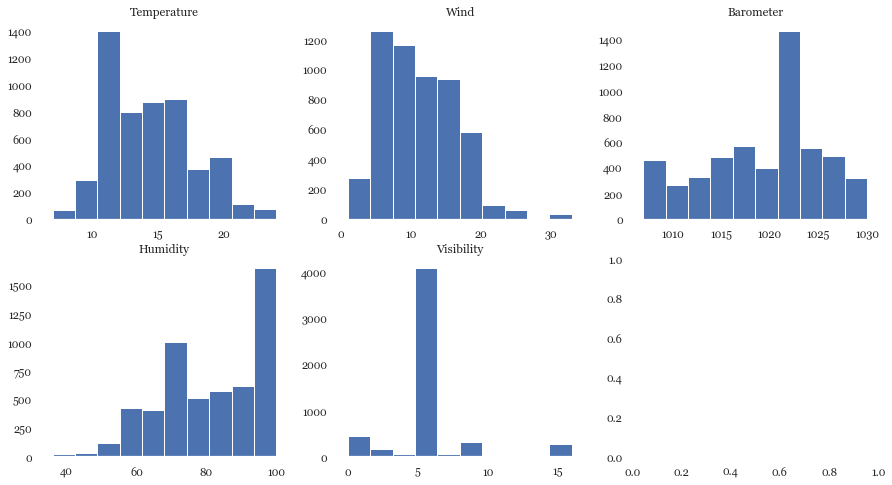

In [176]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

axs[0, 0].hist(X_train_encoded["Temp"])
axs[0, 0].set_title("Temperature")
axs[0, 1].hist(X_train_encoded["Wind"])
axs[0, 1].set_title("Wind")
axs[0, 2].hist(X_train_encoded["Barometer"])
axs[0, 2].set_title("Barometer")
axs[1, 0].hist(X_train_encoded["Humidity"])
axs[1, 0].set_title("Humidity")
axs[1, 1].hist(X_train_encoded["Visibility"])
axs[1, 1].set_title("Visibility")
plt.savefig('scaling_weather.png')
plt.show()

<Figure size 576x432 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x18427578eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x184275786a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18427578bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x1842756c130>],
 'fliers': [<matplotlib.lines.Line2D at 0x1842756c910>],
 'means': []}

Text(0.5, 0, 'Temp')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Box Plot of Temp')

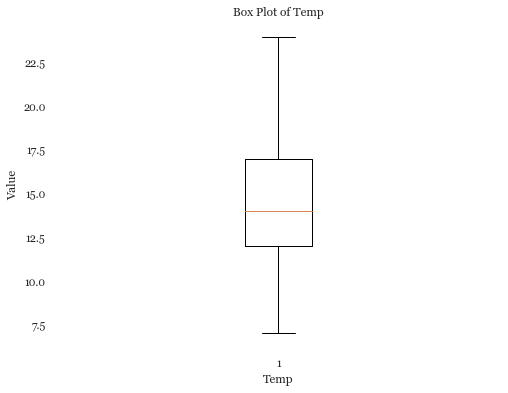

<Figure size 576x432 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x184275134f0>,
 'caps': [<matplotlib.lines.Line2D at 0x184275539d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18427513bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x18427553370>],
 'fliers': [<matplotlib.lines.Line2D at 0x18427553640>],
 'means': []}

Text(0.5, 0, 'Wind')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Box Plot of Wind')

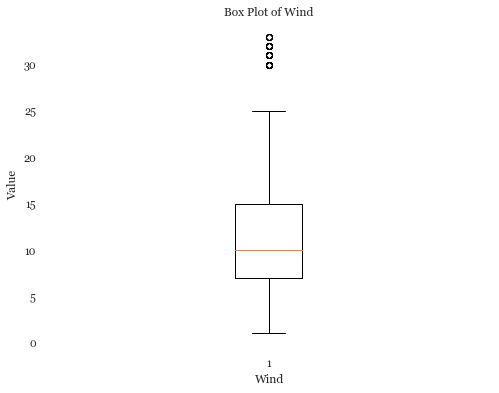

<Figure size 576x432 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x1842747ac40>,
 'caps': [<matplotlib.lines.Line2D at 0x184273d1460>,
 'boxes': [<matplotlib.lines.Line2D at 0x184273d18b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1842738d9a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1842738d040>],
 'means': []}

Text(0.5, 0, 'Humidity')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Box Plot of Humidity')

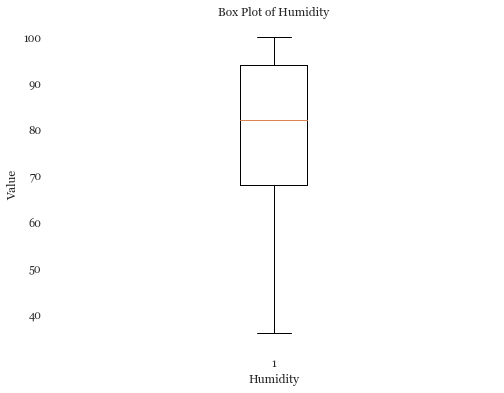

<Figure size 576x432 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x18427336280>,
 'caps': [<matplotlib.lines.Line2D at 0x18423cbdcd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18423c86340>],
 'medians': [<matplotlib.lines.Line2D at 0x18423cbd670>],
 'fliers': [<matplotlib.lines.Line2D at 0x18423cbd910>],
 'means': []}

Text(0.5, 0, 'Barometer')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Box Plot of Barometer')

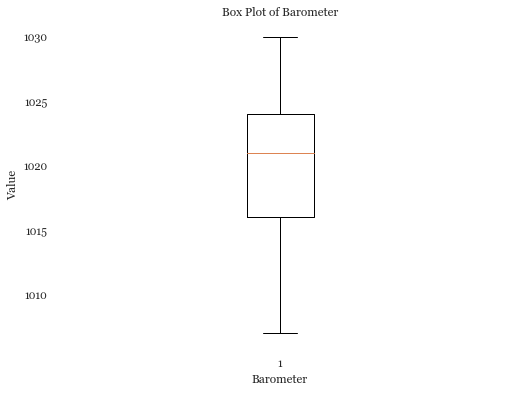

<Figure size 576x432 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x18423c298b0>,
 'caps': [<matplotlib.lines.Line2D at 0x18423c294c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18423c29100>],
 'medians': [<matplotlib.lines.Line2D at 0x18423c094c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18423c09940>],
 'means': []}

Text(0.5, 0, 'Visibility')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Box Plot of Visibility')

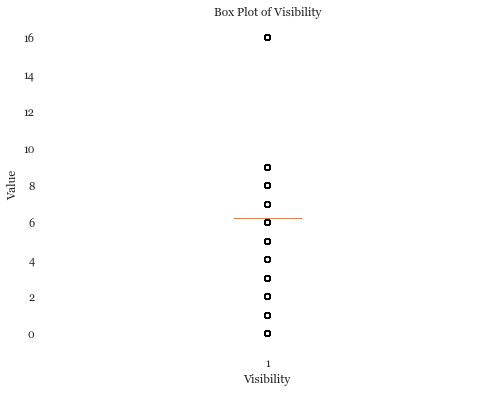

In [177]:
#Box plots
numerical_columns = ['Temp', 'Wind', 'Humidity', 'Barometer', 'Visibility']

for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(X_train_encoded[column].dropna())
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.title(f'Box Plot of {column}')
    plt.show()

With there being outliers present in "Wind" and "Visibility" we will scale this feature using robust scaling as robust to outliers

In [178]:
#Using robust scaler
columns_to_scale = ['Temp', 'Humidity', 'Visibility', 'Barometer', 'Wind']

scaler = RobustScaler()
X_train_encoded[columns_to_scale] = scaler.fit_transform(X_train_encoded[columns_to_scale])
X_test_encoded[columns_to_scale] = scaler.transform(X_test_encoded[columns_to_scale])

In [179]:
X_train_encoded

,Interval,Temp,Wind,Humidity,Barometer,Visibility,IsBankHoliday,IsSchoolHoliday,IsEventInZone,Hour,...,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month_April,Month_June,Month_May
4741,2023-05-27 07:00:00,-0.6,0.000,-0.192308,0.625,0.000000,0,0,1,7,...,0,0,1,0,0,0,0,0,0,1
1710,2023-05-06 16:00:00,0.4,0.000,-0.384615,-1.250,0.000000,0,0,0,16,...,0,0,1,0,0,0,0,0,0,1
3641,2023-05-16 16:00:00,0.2,0.625,-1.192308,0.750,0.000000,0,0,0,16,...,0,0,0,0,0,1,0,0,0,1
4480,2023-05-25 07:00:00,-0.4,-0.250,0.230769,0.875,0.000000,0,0,0,7,...,0,0,0,0,1,0,0,0,0,1
1186,2023-05-04 09:00:00,-0.4,1.625,0.230769,-1.625,-3.234657,0,0,0,9,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2023-05-30 16:00:00,0.4,0.500,-0.730769,0.750,9.765343,0,1,0,16,...,0,0,0,0,0,1,0,0,0,1
5390,2023-06-01 09:00:00,-0.2,1.250,0.000000,0.250,0.000000,0,1,0,9,...,0,0,0,0,1,0,0,0,1,0
860,2023-05-03 14:00:00,-0.6,0.625,0.461538,0.250,-1.234657,0,0,1,14,...,0,0,0,0,0,0,1,0,0,1
7603,2023-06-28 08:00:00,0.6,-0.250,0.692308,-0.250,1.765343,0,0,0,8,...,0,0,0,0,0,0,1,0,1,0


## Scaling footfall

We normalised footfall by taking the total footfall for each zone and dividing each footfall observation/row with the total footfall in that zone, this eliminates the zones being of different sizes. 

**Normalising training set**

In [180]:
#Combining footfall from y_train with the zone_id columns from X_train_encoded 
footfall_train = pd.DataFrame({'Footfall': y_train})
X_train_zones = X_train_encoded[['ZoneId_Zone1', 'ZoneId_Zone10', 'ZoneId_Zone2', 'ZoneId_Zone4', 'ZoneId_Zone5', 'ZoneId_Zone6', 'ZoneId_Zone7', 'ZoneId_Zone8', 'ZoneId_Zone9']]
footfall_train = pd.concat([footfall_train, X_train_zones], axis=1)

In [181]:
#Total footfall for each zone in the training set
zone_footfall_train = footfall_train.groupby(X_train_zones.columns.tolist())['Footfall'].sum().reset_index()
zone_footfall_train.rename(columns={'Footfall': 'TotalFootfall'}, inplace=True)

In [182]:
zone_footfall_train

,ZoneId_Zone1,ZoneId_Zone10,ZoneId_Zone2,ZoneId_Zone4,ZoneId_Zone5,ZoneId_Zone6,ZoneId_Zone7,ZoneId_Zone8,ZoneId_Zone9,TotalFootfall
0,0,0,0,0,0,0,0,0,1,590
1,0,0,0,0,0,0,0,1,0,100
2,0,0,0,0,0,0,1,0,0,176
3,0,0,0,0,0,1,0,0,0,2777
4,0,0,0,0,1,0,0,0,0,306
5,0,0,0,1,0,0,0,0,0,190
6,0,0,1,0,0,0,0,0,0,179
7,0,1,0,0,0,0,0,0,0,5746
8,1,0,0,0,0,0,0,0,0,211


In [183]:
y_train

4741    2
1710    2
3641    1
4480    1
1186    2
       ..
5226    1
5390    3
860     1
7603    1
7270    1
Name: Footfall, Length: 5344, dtype: int64

In [184]:
#Map each row's zone to its corresponding total footfall 
y_train_with_zones = pd.merge(y_train, X_train_zones, left_index=True, right_index=True)
y_train_with_zones['ZoneId'] = y_train_with_zones[X_train_zones.columns.tolist()].apply(tuple, axis=1)

In [185]:
#Dictionary mapping ZoneId to TotalFootfall from zone_footfall_train
zone_footfall_dict = zone_footfall_train.set_index(X_train_zones.columns.tolist())['TotalFootfall'].to_dict()

In [186]:
#Map the ZoneId to TotalFootfall using the dictionary
y_train_with_zones['TotalFootfallInZone'] = y_train_with_zones['ZoneId'].map(zone_footfall_dict)

In [187]:
#Dividing the footfall in each row by the total footfall of its zone
y_train_with_zones['NormalisedFootfall'] = y_train_with_zones['Footfall'] / y_train_with_zones['TotalFootfallInZone']

In [188]:
# Extract the 'NormalisedFootfall' column as the final normalised footfall for y_train
y_train_normalised = y_train_with_zones['NormalisedFootfall']

In [189]:
y_train_normalised

4741    0.000348
1710    0.003390
3641    0.004739
4480    0.001695
1186    0.003390
          ...   
5226    0.000360
5390    0.005085
860     0.000360
7603    0.000360
7270    0.000174
Name: NormalisedFootfall, Length: 5344, dtype: float64

**Normalising testing set**

In [190]:
#Combining footfall from y_test with the zone_id columns from X_test_encoded
footfall_test = pd.DataFrame({'Footfall': y_test})
X_test_zones = X_test_encoded[['ZoneId_Zone1', 'ZoneId_Zone10', 'ZoneId_Zone2', 'ZoneId_Zone4', 'ZoneId_Zone5', 'ZoneId_Zone6', 'ZoneId_Zone7', 'ZoneId_Zone8', 'ZoneId_Zone9']]
footfall_test = pd.concat([footfall_test, X_test_zones], axis=1)

In [191]:
#Map each row's zone to its corresponding total footfall using the dictionary
y_test_with_zones = pd.merge(y_test, X_test_zones, left_index=True, right_index=True)
y_test_with_zones['ZoneId'] = y_test_with_zones[X_test_zones.columns.tolist()].apply(tuple, axis=1)

In [192]:
#Map the ZoneId to TotalFootfall using the dictionary
y_test_with_zones['TotalFootfallInZone'] = y_test_with_zones['ZoneId'].map(zone_footfall_dict)

In [193]:
#Divide the footfall in each row by the total footfall of its zone
y_test_with_zones['NormalisedFootfall'] = y_test_with_zones['Footfall'] / y_test_with_zones['TotalFootfallInZone']

In [194]:
#Extract the 'NormalisedFootfall' column as the final normalised footfall for y_test
y_test_normalised = y_test_with_zones['NormalisedFootfall']

In [195]:
y_test_normalised 

683     0.000360
6375    0.000720
5804    0.000174
2484    0.005263
4279    0.000720
          ...   
5786    0.000360
2968    0.001695
3992    0.000360
7207    0.000174
2818    0.000522
Name: NormalisedFootfall, Length: 2291, dtype: float64

## Models

Dropping "Interval" variables for train and test before running the models. 

In [196]:
X_train_encoded = X_train_encoded.drop("Interval", axis=1)
X_test_encoded = X_test_encoded.drop("Interval", axis=1)

## Random forest model

In [197]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [198]:
#Fitting model to training data
rf_model.fit(X_train_encoded, y_train_normalised)

RandomForestRegressor(random_state=42)

In [199]:
#Predictions on test data
y_pred_rfmodel_normalised = rf_model.predict(X_test_encoded)

In [200]:
#Reverse scaling
y_pred_rfmodel_actual = y_pred_rfmodel_normalised * y_test_with_zones['TotalFootfallInZone']
y_pred_rfmodel_actual

683     1.00
6375    1.73
5804    1.07
2484    1.00
4279    1.99
        ... 
5786    1.27
2968    1.00
3992    1.01
7207    1.00
2818    2.97
Name: TotalFootfallInZone, Length: 2291, dtype: float64

In [201]:
#Evaluate models performance
mse = mean_squared_error(y_test, y_pred_rfmodel_actual)
mae = mean_absolute_error(y_test, y_pred_rfmodel_actual)
mape_rf_model = 100 * np.mean(np.abs((y_test - y_pred_rfmodel_actual) / y_test))
r2 = r2_score(y_test, y_pred_rfmodel_actual)
n_samples = len(y_test)
n_predictors = X_train_encoded.shape[1]
adjusted_r2 = 1 - (1 - r2) * ((n_samples - 1) / (n_samples - n_predictors - 1))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape_rf_model)
print("R-squared (R2):", r2)
print("Adjusted R-squared:", adjusted_r2)

Mean Squared Error (MSE): 0.032559107903017755
Mean Absolute Error (MAE): 0.07445226055987307
Mean Absolute Percentage Error (MAPE): 5.491760712490519
R-squared (R2): 0.9894062307888688
Adjusted R-squared: 0.9892035017830483


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Actual Footfall')

Text(0, 0.5, 'Predicted Footfall')

Text(0.5, 1.0, 'Actual vs. Predicted Balanced Footfall (Random Forest Model)')

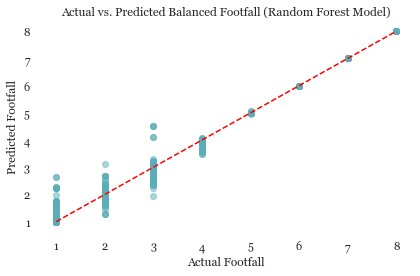

In [202]:
#Visualise
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_rfmodel_actual, alpha=0.5, color='#5BAEB7')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel("Actual Footfall")
plt.ylabel("Predicted Footfall")
plt.title("Actual vs. Predicted Balanced Footfall (Random Forest Model)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('actualvspredictedbasemodel_rf_balanced.png')
plt.show()

**Hyperparameter tuning for random forest model**

We use GridSearchCV for hyperparameter tuning to find the optimal hyperparameters for the random forest model

Cross validation: technique used to estimate the performance of a machine learning model on an independent dataset (test set) by partitioning the training data into multiple subsets (folds). The model is trained on some folds and evaluated on the remaining fold. This process is repeated multiple times, and the performance is averaged to obtain a more robust estimate of the model's performance.

In [203]:
random.seed(42)
np.random.seed(42)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

rf_model = RandomForestRegressor()
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_rf.fit(X_train_encoded, y_train_normalised)

best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error')

In [204]:
best_params_rf

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

In [205]:
best_model_rf

RandomForestRegressor(max_depth=20, n_estimators=200)

Performing cross validation for random forest model to provide a more robust estimate of the models performance.

In [206]:
cv_scores_rf = cross_val_score(best_model_rf, X_train_encoded, y_train_normalised, cv=5, scoring='r2')

mean_cv_score_rf = np.mean(cv_scores_rf)
std_cv_score_rf = np.std(cv_scores_rf)

print("Cross-validation R-squared scores:", cv_scores_rf)
print("Mean R-squared score:", mean_cv_score_rf)
print("Standard deviation of R-squared scores:", std_cv_score_rf)

Cross-validation R-squared scores: [0.96149873 0.98213337 0.98509664 0.98088195 0.9440394 ]
Mean R-squared score: 0.9707300156530154
Standard deviation of R-squared scores: 0.015729614776123595


Learning curve to check for overfitting or underfitting

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Number of Training Samples')

Text(0, 0.5, 'R-squared (R2)')

Text(0.5, 1.0, 'Learning Curve Random Forest Model')

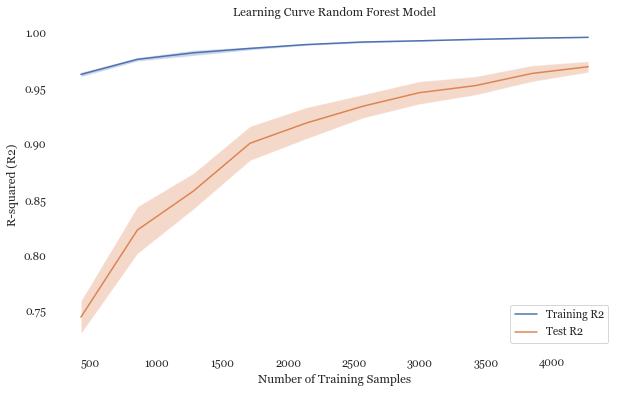

In [207]:
#Learning curve using the test set as the validation set
train_sizes, train_scores, test_scores = learning_curve(
    best_model_rf, X_train_encoded, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='r2', random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training R2')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
plt.plot(train_sizes, test_mean, label='Test R2')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3)
plt.xlabel('Number of Training Samples')
plt.ylabel('R-squared (R2)')
plt.title('Learning Curve Random Forest Model')
plt.legend()
plt.grid()
plt.savefig('learning curve_rf.png')
plt.show()

In [208]:
#Predictions using the best model on the test data
y_pred_rfmodel_normalised_final = best_model_rf.predict(X_test_encoded)

#Reverse scale
y_pred_rfmodel_actual_final = y_pred_rfmodel_normalised_final * y_test_with_zones['TotalFootfallInZone']

#Evaluating model
mse_final_rf = mean_squared_error(y_test, y_pred_rfmodel_actual_final)
mae_final_rf = mean_absolute_error(y_test, y_pred_rfmodel_actual_final)
mape_final_rf = 100 * np.mean(np.abs((y_test - y_pred_rfmodel_actual_final) / y_test))
r2_final_rf = r2_score(y_test, y_pred_rfmodel_actual_final)
n_samples = len(y_test)
n_predictors = X_train_encoded.shape[1]
adjusted_r2_final_rf = 1 - (1 - r2_final_rf) * ((n_samples - 1) / (n_samples - n_predictors - 1))

print("Final Mean Squared Error:", mse_final_rf)
print("Final Mean Absolute Error:", mae_final_rf)
print("Mean Absolute Percentage Error (MAPE):", mape_final_rf)
print("Final R-squared:", r2_final_rf)
print("Adjusted R-squared:", adjusted_r2_final_rf)

Final Mean Squared Error: 0.03932355782243851
Final Mean Absolute Error: 0.08932159422927377
Mean Absolute Percentage Error (MAPE): 6.6341936817814275
Final R-squared: 0.9872052791688166
Adjusted R-squared: 0.9869604313736493


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Actual Footfall')

Text(0, 0.5, 'Predicted Footfall')

Text(0.5, 1.0, 'Actual vs. Predicted Footfall (Random Forest Model)')

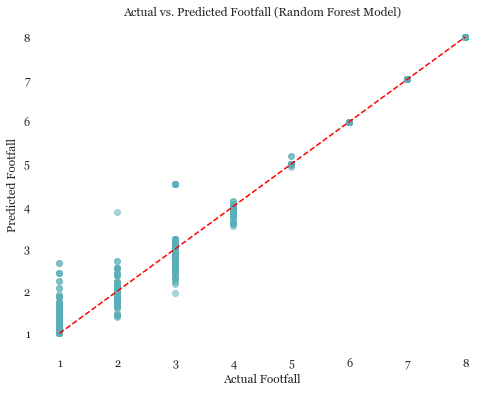

In [209]:
#Visualise
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rfmodel_actual_final, alpha=0.5, color='#5BAEB7')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel("Actual Footfall")
plt.ylabel("Predicted Footfall")
plt.title("Actual vs. Predicted Footfall (Random Forest Model)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('finalactualpredicted_rfmodel.png')
plt.show()

Feature importance for the final random forest model

<Figure size 800x500 with 0 Axes>

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x18419d0c3d0>,
 [Text(0, 0, 'ProminentActivity_RestaurantCafe'),
  Text(0, 1, 'ProminentActivity_SpecialistRetail'),
  Text(0, 2, 'ZoneId_Zone8'),
  Text(0, 3, 'ZoneId_Zone7'),
  Text(0, 4, 'ProminentActivity_Culture'),
  Text(0, 5, 'ZoneId_Zone9'),
  Text(0, 6, 'Hour'),
  Text(0, 7, 'Barometer'),
  Text(0, 8, 'Visibility'),
  Text(0, 9, 'Wind')])

Text(0.5, 0, 'Feature Importance')

Text(0, 0.5, 'Feature Name')

Text(0.5, 1.0, 'Top 10 Feature Importances')

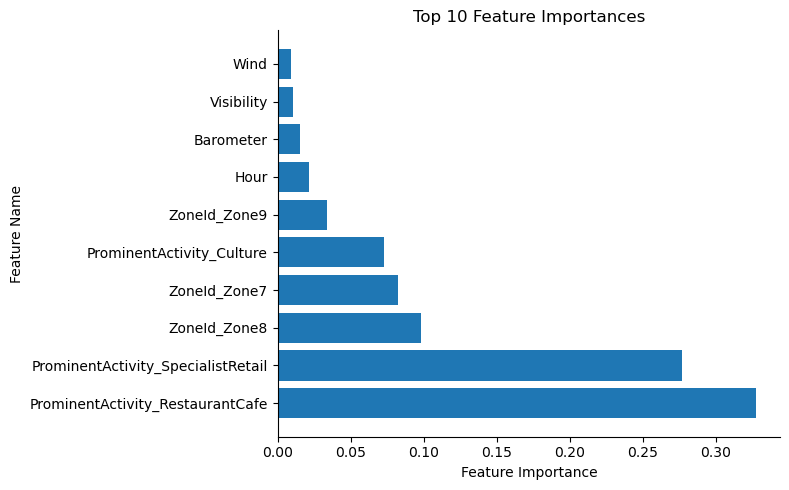

In [210]:
#Checking feature importance
feature_importances = best_model_rf.feature_importances_
feature_names = X_train_encoded.columns.tolist()

sorted_importances, sorted_features = zip(*sorted(zip(feature_importances, feature_names), reverse=True))
top_n = 10

plt.style.use('default')
plt.style.use({'figure.facecolor':'white'})
#Bar plot
plt.figure(figsize=(8, 5))
plt.barh(range(top_n), sorted_importances[:top_n])
plt.yticks(range(top_n), sorted_features[:top_n])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('feature_importance_graph_final_rf.png')
plt.show()

## XG Boost - Gradient Boosting Machine

Building the basic model

In [211]:
#Call or start model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

In [212]:
#Train model
xgb_model.fit(X_train_encoded, y_train_normalised)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [213]:
#Mke predictions
y_pred_xgb_model_normalised = xgb_model.predict(X_test_encoded)

In [214]:
#Reverse scaling
y_pred_xgb_model_actual = y_pred_xgb_model_normalised * y_test_with_zones['TotalFootfallInZone']

In [215]:
#Evaluate model
mse_xgb_model = mean_squared_error(y_test, y_pred_xgb_model_actual)
mae_xgb_model = mean_absolute_error(y_test, y_pred_xgb_model_actual)
mape_xgb_model = 100 * np.mean(np.abs((y_test - y_pred_xgb_model_actual) / y_test))
r2_xgb_model = r2_score(y_test, y_pred_xgb_model_actual)
n_samples = len(y_test)
n_predictors = X_train_encoded.shape[1]
adjusted_r2_xgb_model = 1 - (1 - r2_xgb_model) * ((n_samples - 1) / (n_samples - n_predictors - 1))

print("Mean Squared Error (MSE):", mse_xgb_model)
print("Mean Absolute Error (MAE):", mae_xgb_model)
print("Mean Absolute Percentage Error (MAPE):", mape_xgb_model)
print("R-squared (R2):", r2_xgb_model)
print("Adjusted R-squared:", adjusted_r2_xgb_model)

Mean Squared Error (MSE): 0.667455313983396
Mean Absolute Error (MAE): 0.5520727560217958
Mean Absolute Percentage Error (MAPE): 34.30413971823562
R-squared (R2): 0.7828298129007442
Adjusted R-squared: 0.7786739081186934


<Figure size 600x400 with 0 Axes>

Text(0.5, 0, 'Actual Footfall')

Text(0, 0.5, 'Predicted Footfall')

Text(0.5, 1.0, 'Actual vs. Predicted Balanced Footfall (XGBoost Model)')

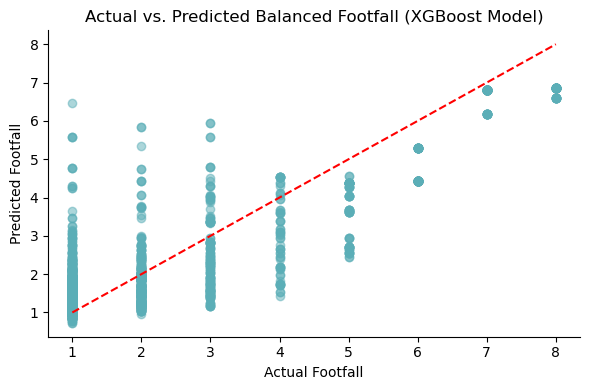

In [216]:
#Visualise
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_xgb_model_actual, alpha=0.5, color='#5BAEB7')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel("Actual Footfall")
plt.ylabel("Predicted Footfall")
plt.title("Actual vs. Predicted Balanced Footfall (XGBoost Model)")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig('actualvspredictedbasemodel_xgb_balanced.png')
plt.show()

Hyperparameter tuning

In [217]:
random.seed(42)
np.random.seed(42)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_xgb.fit(X_train_encoded, y_train_normalised)

best_params_xgb = grid_search_xgb.best_params_
best_model_xgb = grid_search_xgb.best_estimator_

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [218]:
best_model_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [219]:
best_params_xgb

{'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 7,
 'subsample': 0.8}

Performing cross validation for XGBoost model to provide a more robust estimate of the models performance.

In [220]:
#Perform cv on entire training dataset
cv_scores_xgb = cross_val_score(best_model_xgb, X_train_encoded, y_train_normalised, cv=5, scoring='r2')

mean_cv_score_xgb = np.mean(cv_scores_xgb)
std_cv_score_xgb = np.std(cv_scores_xgb)

print("Cross-validation R-squared scores:", cv_scores_xgb)
print("Mean R-squared score:", mean_cv_score_xgb)
print("Standard deviation of R-squared scores:", std_cv_score_xgb)

Cross-validation R-squared scores: [0.9414403  0.9595683  0.96813942 0.96634777 0.93728256]
Mean R-squared score: 0.9545556713765165
Standard deviation of R-squared scores: 0.012798998855601066


Learning curve to check for overfitting or underfitting

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Number of Training Samples')

Text(0, 0.5, 'R-squared (R2)')

Text(0.5, 1.0, 'Learning Curve XGBoost model')

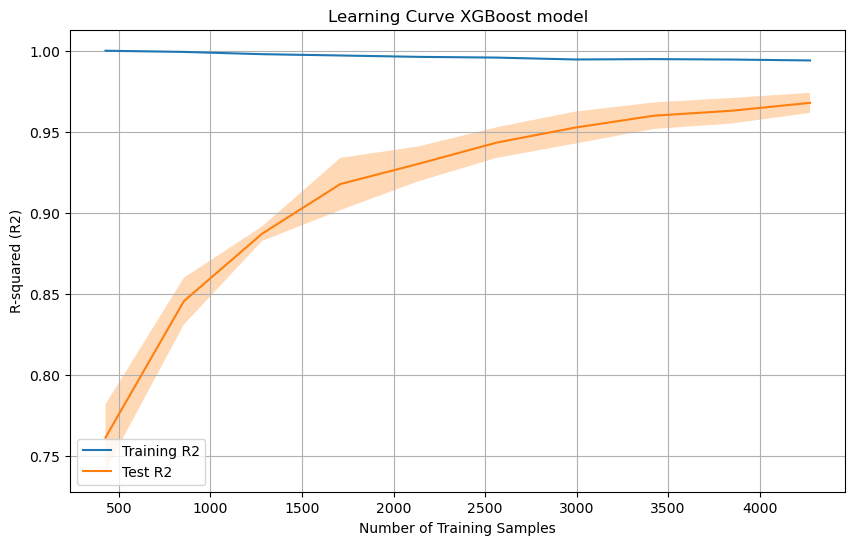

In [221]:
#Learning curve using the test set as the validation set
train_sizes, train_scores, test_scores = learning_curve(
    best_model_xgb, X_train_encoded, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='r2', random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training R2')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
plt.plot(train_sizes, test_mean, label='Test R2')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3)
plt.xlabel('Number of Training Samples')
plt.ylabel('R-squared (R2)')
plt.title('Learning Curve XGBoost model')
plt.legend()
plt.grid()
plt.show()

They are converging and generalizing better as more data points are added, however, need more data so the gap becomes smaller

Training the final model for XGBoost

In [222]:
#Predictions on test data using best model for hyperparameter tuning 
y_pred_xgb_model_normalised_final = best_model_xgb.predict(X_test_encoded)

#Reverse scaling
y_pred_xgb_model_actual_final = y_pred_xgb_model_normalised_final * y_test_with_zones['TotalFootfallInZone']

#Evaluate model
mse_xgb_model_final = mean_squared_error(y_test, y_pred_xgb_model_actual_final)
mae_xgb_model_final = mean_absolute_error(y_test, y_pred_xgb_model_actual_final)
mape_xgb_model_final = 100 * np.mean(np.abs((y_test - y_pred_xgb_model_actual_final) / y_test))
r2_xgb_model_final = r2_score(y_test, y_pred_xgb_model_actual_final)
n_samples = len(y_test)
n_predictors = X_train_encoded.shape[1]
adjusted_r2_xgb_model_final = 1 - (1 - r2_xgb_model_final) * ((n_samples - 1) / (n_samples - n_predictors - 1))


print("Mean Squared Error (MSE):", mse_xgb_model_final)
print("Mean Absolute Error (MAE):", mae_xgb_model_final)
print("Mean Absolute Percentage Error (MAPE):", mape_xgb_model_final)
print("R-squared (R2):", r2_xgb_model_final)
print("Adjusted R-squared:", adjusted_r2_xgb_model_final)

Mean Squared Error (MSE): 0.5584835193816243
Mean Absolute Error (MAE): 0.5143519775201579
Mean Absolute Percentage Error (MAPE): 31.794347883836398
R-squared (R2): 0.8182860067858034
Adjusted R-squared: 0.8148086139472585


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Actual Footfall')

Text(0, 0.5, 'Predicted Footfall')

Text(0.5, 1.0, 'Actual vs. Predicted Footfall (XGBoost Model)')

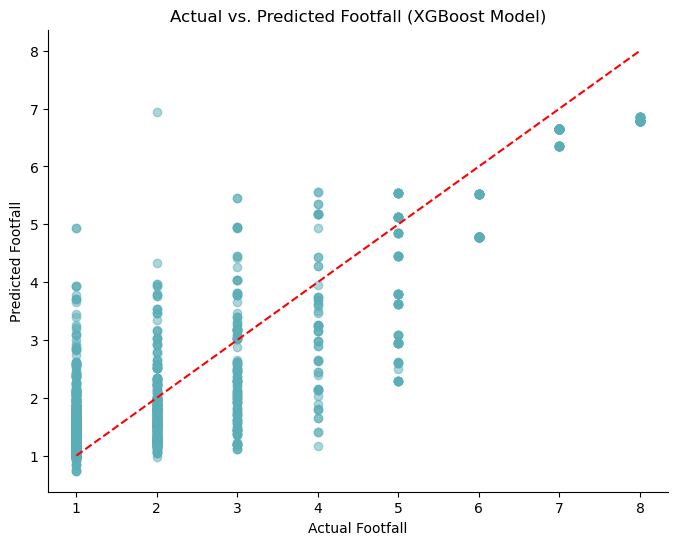

In [223]:
#Visualise
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb_model_actual_final, alpha=0.5, color='#5BAEB7')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel("Actual Footfall")
plt.ylabel("Predicted Footfall")
plt.title("Actual vs. Predicted Footfall (XGBoost Model)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

## Linear regression model

In [224]:
#Linear regression model
linear_model = LinearRegression()

linear_model.fit(X_train_encoded, y_train_normalised)

LinearRegression()

In [225]:
#Predictions on test data
y_pred_linear_model = linear_model.predict(X_test_encoded)

In [226]:
#Reverse scaling
y_pred_linear_model_actual = y_pred_linear_model * y_test_with_zones['TotalFootfallInZone']

In [227]:
#Evaluation metrics
mse_linear_model = mean_squared_error(y_test, y_pred_linear_model_actual)
mae_linear_model = mean_absolute_error(y_test, y_pred_linear_model_actual)
mape_linear_model = 100 * np.mean(np.abs((y_test - y_pred_linear_model_actual) / y_test))
r2_linear_model = r2_score(y_test, y_pred_linear_model_actual)
n_samples = len(y_test)
n_predictors = X_train_encoded.shape[1]
adjusted_r2_linear_model = 1 - (1 - r2_linear_model) * ((n_samples - 1) / (n_samples - n_predictors - 1))

print("Mean Squared Error (MSE):", mse_linear_model)
print("Mean Absolute Error (MAE):", mae_linear_model)
print("Mean Absolute Percentage Error (MAPE):", mape_linear_model)
print("R-squared (R2):", r2_linear_model)
print("Adjusted R-squared:", adjusted_r2_linear_model)

Mean Squared Error (MSE): 1.8193606777200426
Mean Absolute Error (MAE): 0.9150922946474319
Mean Absolute Percentage Error (MAPE): 54.59251183430719
R-squared (R2): 0.4080339305062156
Adjusted R-squared: 0.3967056968665926


Regularisation technique in the aim of improving model performance (Lasso or L1 regularization) using GridSearchCV

In [228]:
#Finding optimal alpha to use in lasso 
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]  
lasso_model = Lasso()

param_grid = {'alpha': alphas}

grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_encoded, y_train_normalised)

best_alpha_grid_lasso = grid_search_lasso.best_params_['alpha']
best_lasso_model_grid = Lasso(alpha=best_alpha_grid_lasso)

best_lasso_model_grid.fit(X_train_encoded, y_train_normalised)
y_pred_lasso_grid = best_lasso_model_grid.predict(X_test_encoded)

y_pred_lasso_grid_actual = y_pred_lasso_grid * y_test_with_zones['TotalFootfallInZone']

mse_lasso_grid = mean_squared_error(y_test, y_pred_lasso_grid_actual)
mae_lasso_grid = mean_absolute_error(y_test, y_pred_lasso_grid_actual)
mape_lasso_grid = 100 * np.mean(np.abs((y_test - y_pred_lasso_grid_actual) / y_test))
r2_lasso_grid = r2_score(y_test, y_pred_lasso_grid_actual)
n_samples = len(y_test)
n_predictors = X_train_encoded.shape[1]
adjusted_r2_lasso_grid = 1 - (1 - r2_lasso_grid) * ((n_samples - 1) / (n_samples - n_predictors - 1))

print("Best alpha (Grid Search):", best_alpha_grid_lasso)
print("MSE with Grid Search:", mse_lasso_grid)
print("MAE withGrid Search:", mae_lasso_grid)
print("MAPE with Grid Search:", mape_lasso_grid)
print("R2 with Grid Search:", r2_lasso_grid)
print("Adjusted R-squared with Grid Search:", adjusted_r2_linear_model)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='neg_mean_squared_error')

Lasso(alpha=0.001)

Best alpha (Grid Search): 0.001
MSE with Grid Search: 26.10435589124833
MAE withGrid Search: 4.0931896028980885
MAPE with Grid Search: 314.398857628635
R2 with Grid Search: -7.493584116028163
Adjusted R-squared with Grid Search: 0.3967056968665926


Cross validation

In [229]:
#Perform cv on entire training dataset
cv_scores_linear_model = cross_val_score(linear_model, X_train_encoded, y_train_normalised, cv=5, scoring='r2')

mean_cv_score_linear_model = np.mean(cv_scores_linear_model)
std_cv_score_linear_model = np.std(cv_scores_linear_model)

print("Cross-validation R-squared scores:", cv_scores_linear_model)
print("Mean R-squared score:", mean_cv_score_linear_model)
print("Standard deviation of R-squared scores:", std_cv_score_linear_model)

Cross-validation R-squared scores: [0.89372292 0.91029803 0.89628811 0.91096125 0.88440356]
Mean R-squared score: 0.8991347723346349
Standard deviation of R-squared scores: 0.010187090978651505


Learning curve for linear regression model

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Number of Training Samples')

Text(0, 0.5, 'R-squared (R2)')

Text(0.5, 1.0, 'Learning Curve Linear Regression model')

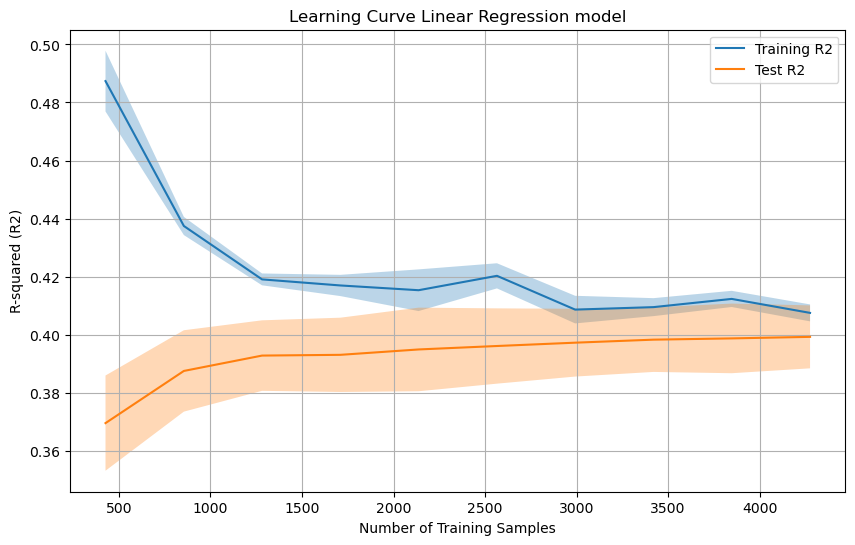

In [230]:
#Learning curve using the test set as the validation set
train_sizes, train_scores, test_scores = learning_curve(
    linear_model, X_train_encoded, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='r2', random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training R2')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
plt.plot(train_sizes, test_mean, label='Test R2')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3)
plt.xlabel('Number of Training Samples')
plt.ylabel('R-squared (R2)')
plt.title('Learning Curve Linear Regression model')
plt.legend()
plt.grid()
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Actual Footfall')

Text(0, 0.5, 'Predicted Footfall')

Text(0.5, 1.0, 'Actual vs. Predicted Footfall (Linear Regression Model)')

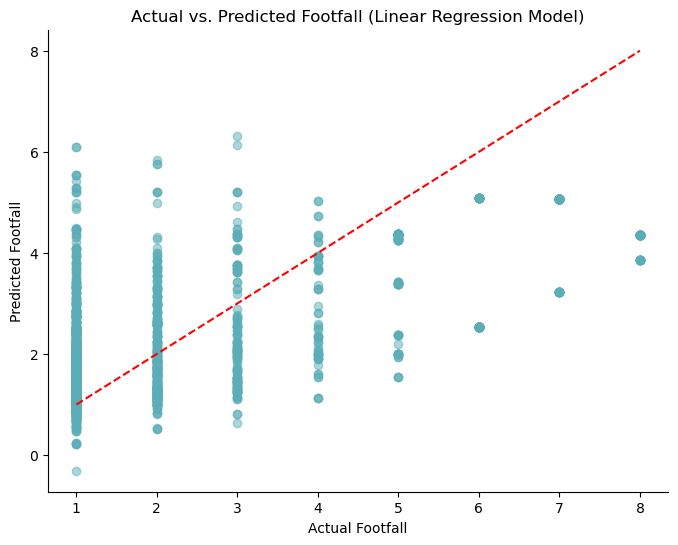

In [231]:
#Visualise
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear_model_actual, alpha=0.5, color='#5BAEB7')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel("Actual Footfall")
plt.ylabel("Predicted Footfall")
plt.title("Actual vs. Predicted Footfall (Linear Regression Model)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

## Decision tree

In [232]:
dt_model = DecisionTreeRegressor(random_state=42)

#Fit model
dt_model.fit(X_train_encoded, y_train_normalised)

DecisionTreeRegressor(random_state=42)

In [233]:
#Predictions on test data
y_pred_dt_model = dt_model.predict(X_test_encoded)

In [234]:
#Reverse scaling
y_pred_dt_model_actual = y_pred_dt_model * y_test_with_zones['TotalFootfallInZone']

In [235]:
#Evaluation metrics
mse_dt_model = mean_squared_error(y_test, y_pred_dt_model_actual)
mae_dt_model = mean_absolute_error(y_test, y_pred_dt_model_actual)
mape_dt_model = 100 * np.mean(np.abs((y_test - y_pred_dt_model_actual) / y_test))
r2_dt_model = r2_score(y_test, y_pred_dt_model_actual)
n_samples = len(y_test)
n_predictors = X_train_encoded.shape[1]
adjusted_r2_dt_model = 1 - (1 - r2_dt_model) * ((n_samples - 1) / (n_samples - n_predictors - 1))

print("Mean Squared Error (MSE):", mse_dt_model)
print("Mean Absolute Error (MAE):", mae_dt_model)
print("Mean Absolute Percentage Error (MAPE):", mape_dt_model)
print("R-squared (R2):", r2_dt_model)
print("Adjusted R-squared:", adjusted_r2_dt_model)

Mean Squared Error (MSE): 0.04839048108388658
Mean Absolute Error (MAE): 0.025151573213089033
Mean Absolute Percentage Error (MAPE): 1.8714135636721745
R-squared (R2): 0.9842551709295821
Adjusted R-squared: 0.983953868014572


<Figure size 600x400 with 0 Axes>

Text(0.5, 0, 'Actual Footfall')

Text(0, 0.5, 'Predicted Footfall')

Text(0.5, 1.0, 'Actual vs. Predicted Balanced Footfall (Decision Tree Model)')

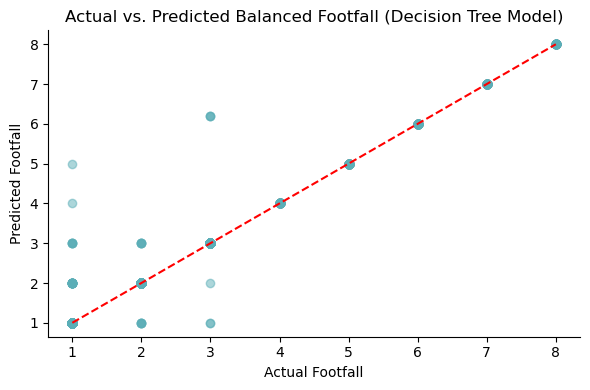

In [236]:
#Visualise
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_dt_model_actual, alpha=0.5, color='#5BAEB7')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel("Actual Footfall")
plt.ylabel("Predicted Footfall")
plt.title("Actual vs. Predicted Balanced Footfall (Decision Tree Model)")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig('actualvspredictedbasemodel_dt_balanced.png')
plt.show()

Hyperparameter tuning

In [237]:
random.seed(42)
np.random.seed(42)

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search_dt = GridSearchCV(dt_model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_dt.fit(X_train_encoded, y_train_normalised)

best_params_dt = grid_search_dt.best_params_
best_model_dt = grid_search_dt.best_estimator_


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [238]:
best_params_dt

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Cross validation

In [239]:
#Perform cv on entire training dataset
cv_scores_dt = cross_val_score(best_model_dt, X_train_encoded, y_train_normalised, cv=5, scoring='r2')

mean_cv_score_dt = np.mean(cv_scores_dt)
std_cv_score_dt = np.std(cv_scores_dt)

print("Cross-validation R-squared scores:", cv_scores_dt)
print("Mean R-squared score:", mean_cv_score_dt)
print("Standard deviation of R-squared scores:", std_cv_score_dt)

Cross-validation R-squared scores: [0.96643919 0.9798185  0.98649033 0.97794045 0.92500948]
Mean R-squared score: 0.9671395884282198
Standard deviation of R-squared scores: 0.022033163873188242


Learning curve for decision tree

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Number of Training Samples')

Text(0, 0.5, 'R-squared (R2)')

Text(0.5, 1.0, 'Learning Curve Decision tree')

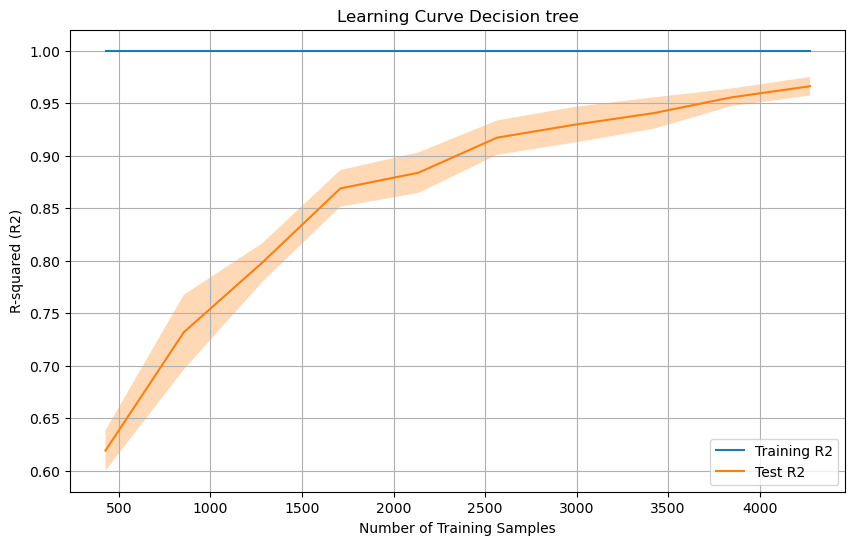

In [240]:
#Learning curve using the test set as the validation set
train_sizes, train_scores, test_scores = learning_curve(
    best_model_dt, X_train_encoded, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='r2', random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training R2')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
plt.plot(train_sizes, test_mean, label='Test R2')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3)
plt.xlabel('Number of Training Samples')
plt.ylabel('R-squared (R2)')
plt.title('Learning Curve Decision tree')
plt.legend()
plt.grid()
plt.savefig('learning curve_dt.png')
plt.show()

In [241]:
#Predictions on test data using best model for hyperparameter tuning 
y_pred_dt_model_normalised_final = best_model_dt.predict(X_test_encoded)

#Reverse scaling
y_pred_dt_model_actual_final = y_pred_dt_model_normalised_final * y_test_with_zones['TotalFootfallInZone']

#Evaluate model
mse_dt_model_final = mean_squared_error(y_test, y_pred_dt_model_actual_final)
mae_dt_model_final = mean_absolute_error(y_test, y_pred_dt_model_actual_final)
mape_dt_model_final = 100 * np.mean(np.abs((y_test - y_pred_dt_model_actual_final) / y_test))
r2_dt_model_final = r2_score(y_test, y_pred_dt_model_actual_final)
n_samples = len(y_test)
n_predictors = X_train_encoded.shape[1]
adjusted_r2_dt_model_final = 1 - (1 - r2_dt_model_final) * ((n_samples - 1) / (n_samples - n_predictors - 1))


print("Mean Squared Error (MSE):", mse_dt_model_final)
print("Mean Absolute Error (MAE):", mae_dt_model_final)
print("Mean Absolute Percentage Error (MAPE):", mape_dt_model_final)
print("R-squared (R2):", r2_dt_model_final)
print("Adjusted R-squared:", adjusted_r2_dt_model_final)

Mean Squared Error (MSE): 0.04839048108388658
Mean Absolute Error (MAE): 0.025151573213089033
Mean Absolute Percentage Error (MAPE): 1.8714135636721745
R-squared (R2): 0.9842551709295821
Adjusted R-squared: 0.983953868014572


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Actual Footfall')

Text(0, 0.5, 'Predicted Footfall')

Text(0.5, 1.0, 'Actual vs. Predicted Footfall (Decision Tree Model)')

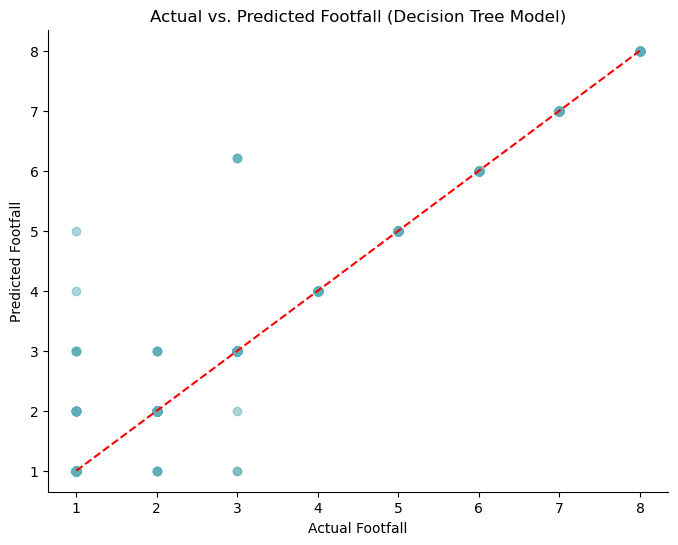

In [242]:
#Visualise
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_dt_model_actual_final, alpha=0.5, color='#5BAEB7')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel("Actual Footfall")
plt.ylabel("Predicted Footfall")
plt.title("Actual vs. Predicted Footfall (Decision Tree Model)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

**Creating cross validation graph**

<Figure size 600x400 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x184273bfdf0>,
 'caps': [<matplotlib.lines.Line2D at 0x1842739a3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x184273bfaf0>,
 'medians': [<matplotlib.lines.Line2D at 0x1842739a970>,
 'fliers': [<matplotlib.lines.Line2D at 0x1842739af10>,
 'means': [<matplotlib.lines.Line2D at 0x1842739ac40>,
  <matplotlib.lines.Line2D at 0x18422744340>]}

Text(0, 0.5, 'R-squared')

(0.9, 1.0)

Text(0.5, 1.0, 'Cross-validation R-squared scores for Random Forest and Decision Tree models')

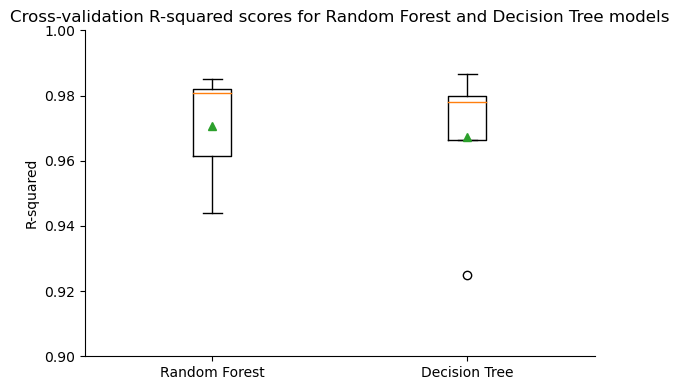

In [243]:
cv_scores = [cv_scores_rf, cv_scores_dt]
models = ['Random Forest', 'Decision Tree']

plt.figure(figsize=(6, 4))
plt.boxplot(cv_scores, labels=models, showmeans=True)
plt.ylabel('R-squared')
plt.ylim(0.9, 1)  
plt.title('Cross-validation R-squared scores for Random Forest and Decision Tree models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('crossvalidation_dt_and_rf.png')

plt.show()